<a href="https://colab.research.google.com/github/nallagondu/postgres/blob/main/postgres_training_2_Replicaiotns_Physical_and_logical_replication_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Replicaiotns : Physical and logical replication

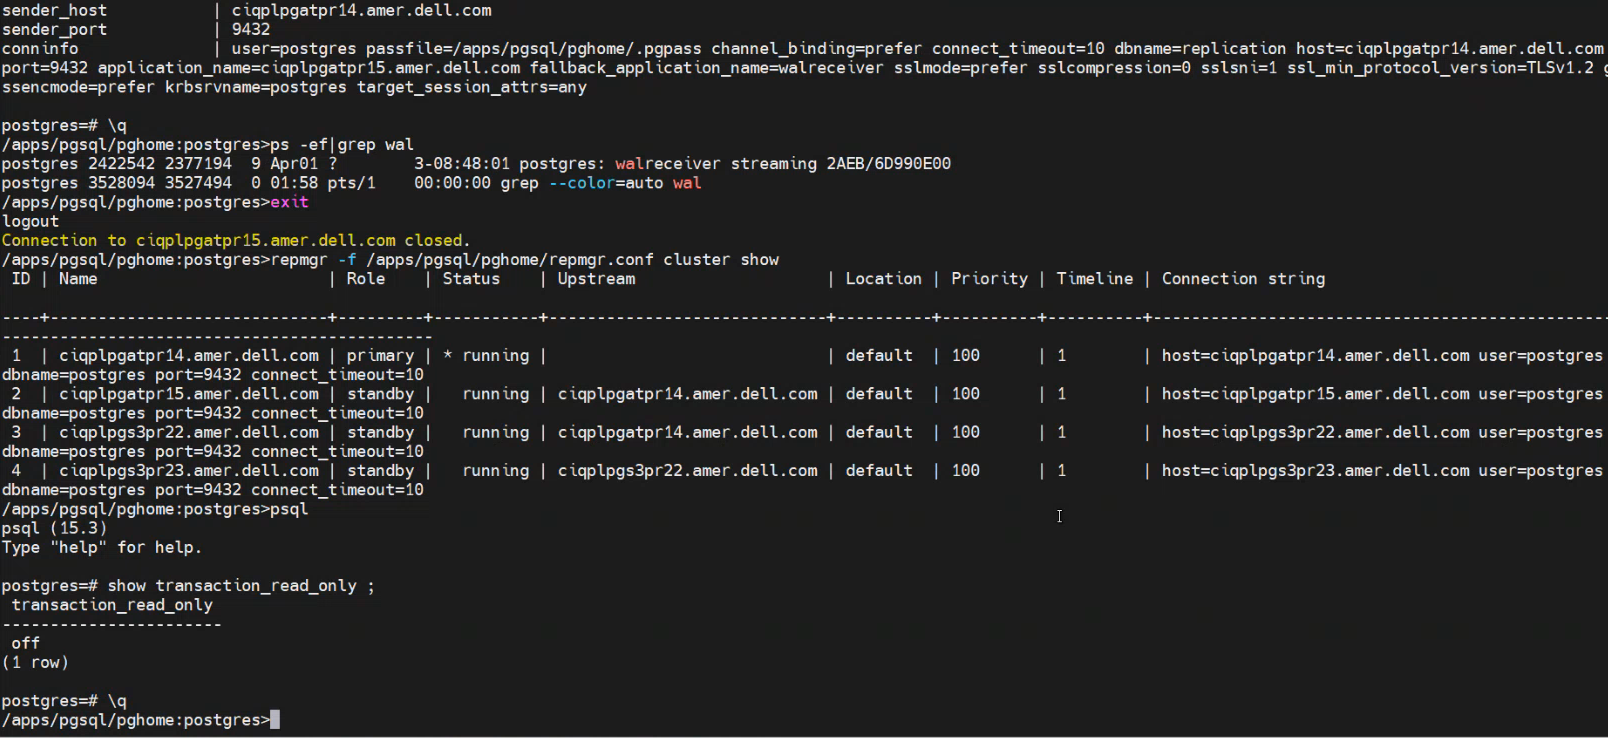

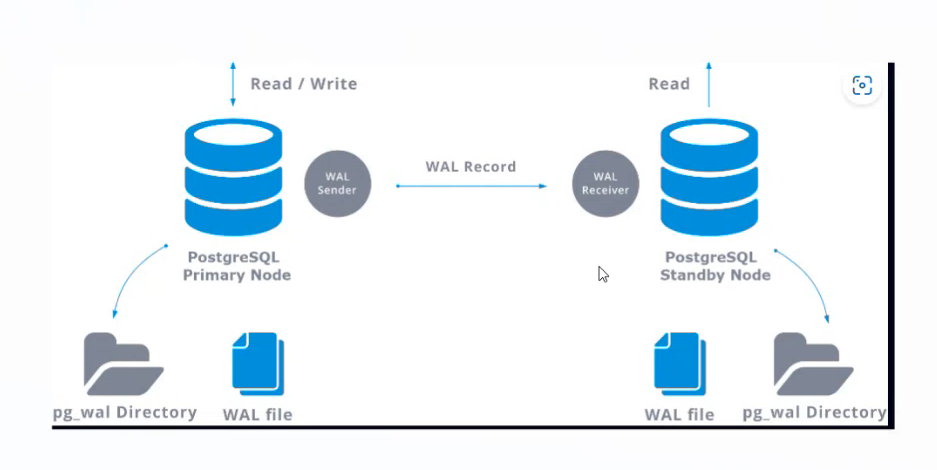

For replication set up we have : repmanager and patroni
previously we have repmanager now we are using patroni : auto



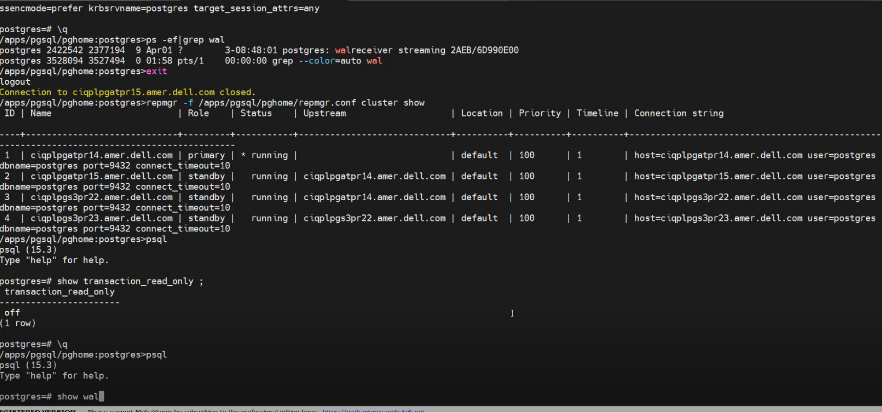



Cascading replication :


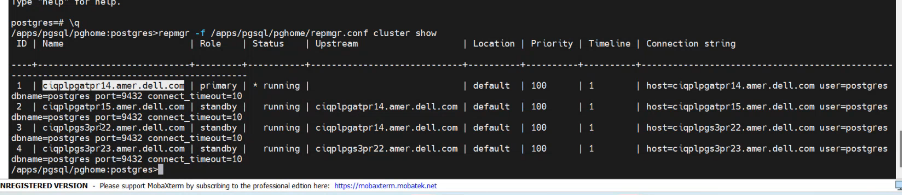

Stand by to the standby



PostgreSQL Replication – Overview
📌 Two Types of Replication
Type	Description	Key Use Case
Physical (Streaming)	Byte-by-byte WAL file transfer from primary to standby.	High Availability, Disaster Recovery
Logical	Table/object-level replication using logical decoding.	Partial replication, cross-version

Basic Architecture – Physical (Streaming) Replication
📌 Architecture Diagram
pgsql
Copy
Edit
      +-----------------+              +------------------+
      |   Primary Node  |  WAL Sender  |   Standby Node   |
      | (Active, Writable)| ---------> | (Passive, Read-only) |
      +-----------------+              +------------------+

    WAL Files (Write-Ahead Logs) continuously stream from Primary to Standby

| Tool                             | Purpose                                     | Auto Failover | Comment               |
| -------------------------------- | ------------------------------------------- | ------------- | --------------------- |
| **PGBaseBackup**                 | Native tool for base backup and replication | ❌             | Manual setup          |
| **Replication Manager (repmgr)** | Manages replication and manual failover     | ❌             | Easy to use           |
| **Patroni**                      | Automatic HA, etcd-based cluster management | ✅             | Preferred for Auto-HA |


| Component            | Description                                            |
| -------------------- | ------------------------------------------------------ |
| **Primary**          | Writes all transactions; streams WALs to standbys      |
| **Standby**          | Read-only node; applies WALs from Primary              |
| **WAL Sender**       | Background process on Primary that streams WAL         |
| **WAL Receiver**     | Background process on Standby that receives WAL        |
| **Replication Slot** | Prevents WAL deletion until a standby confirms receipt |


Cascading Replication
📌 Architecture
scss
Copy
Edit
Primary (PR14)
   ├── Standby1 (PR15)
   ├── Standby2 (PR22)
          └── Cascaded Standby (PR23)
Cascaded replication reduces load on the primary node

PR23 pulls WALs from PR22 instead of PR14 directly

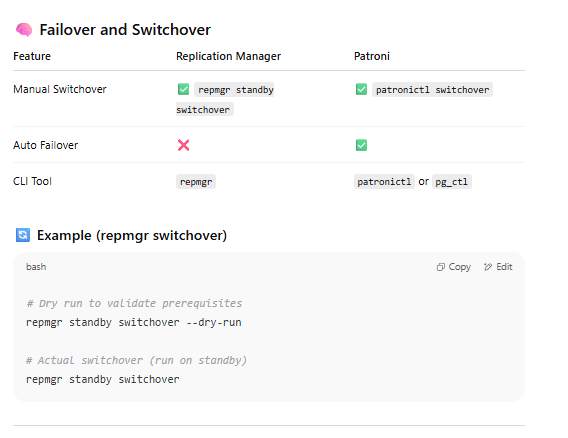

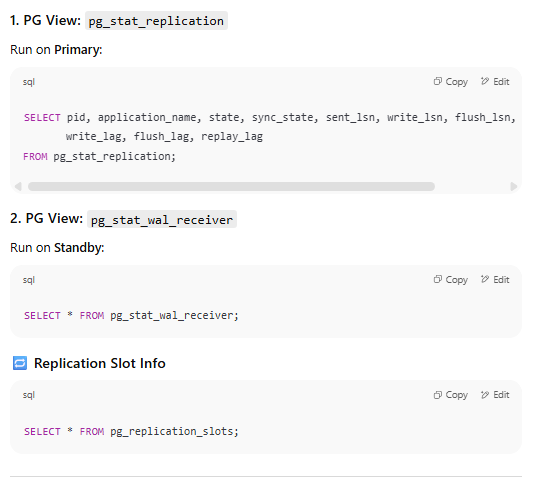

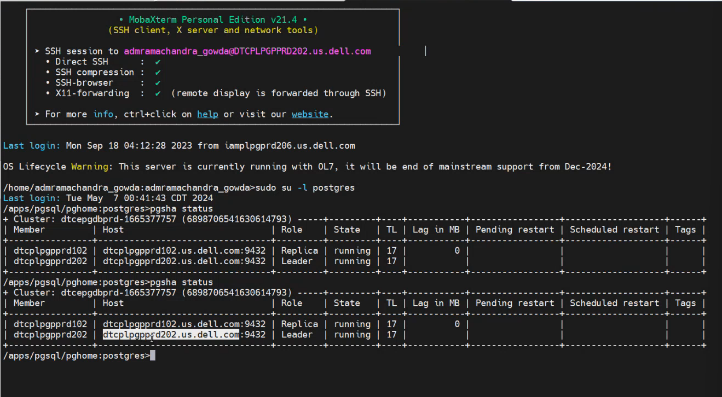

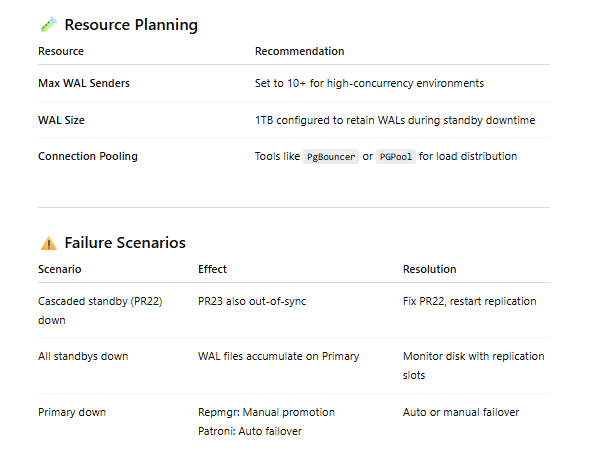

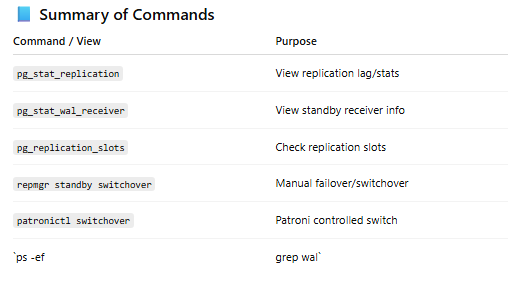

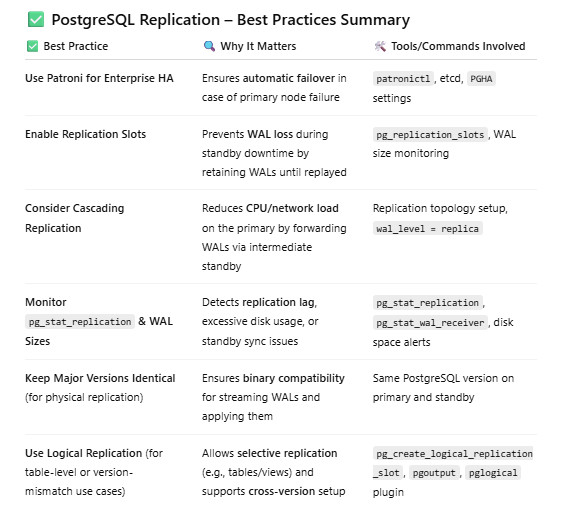

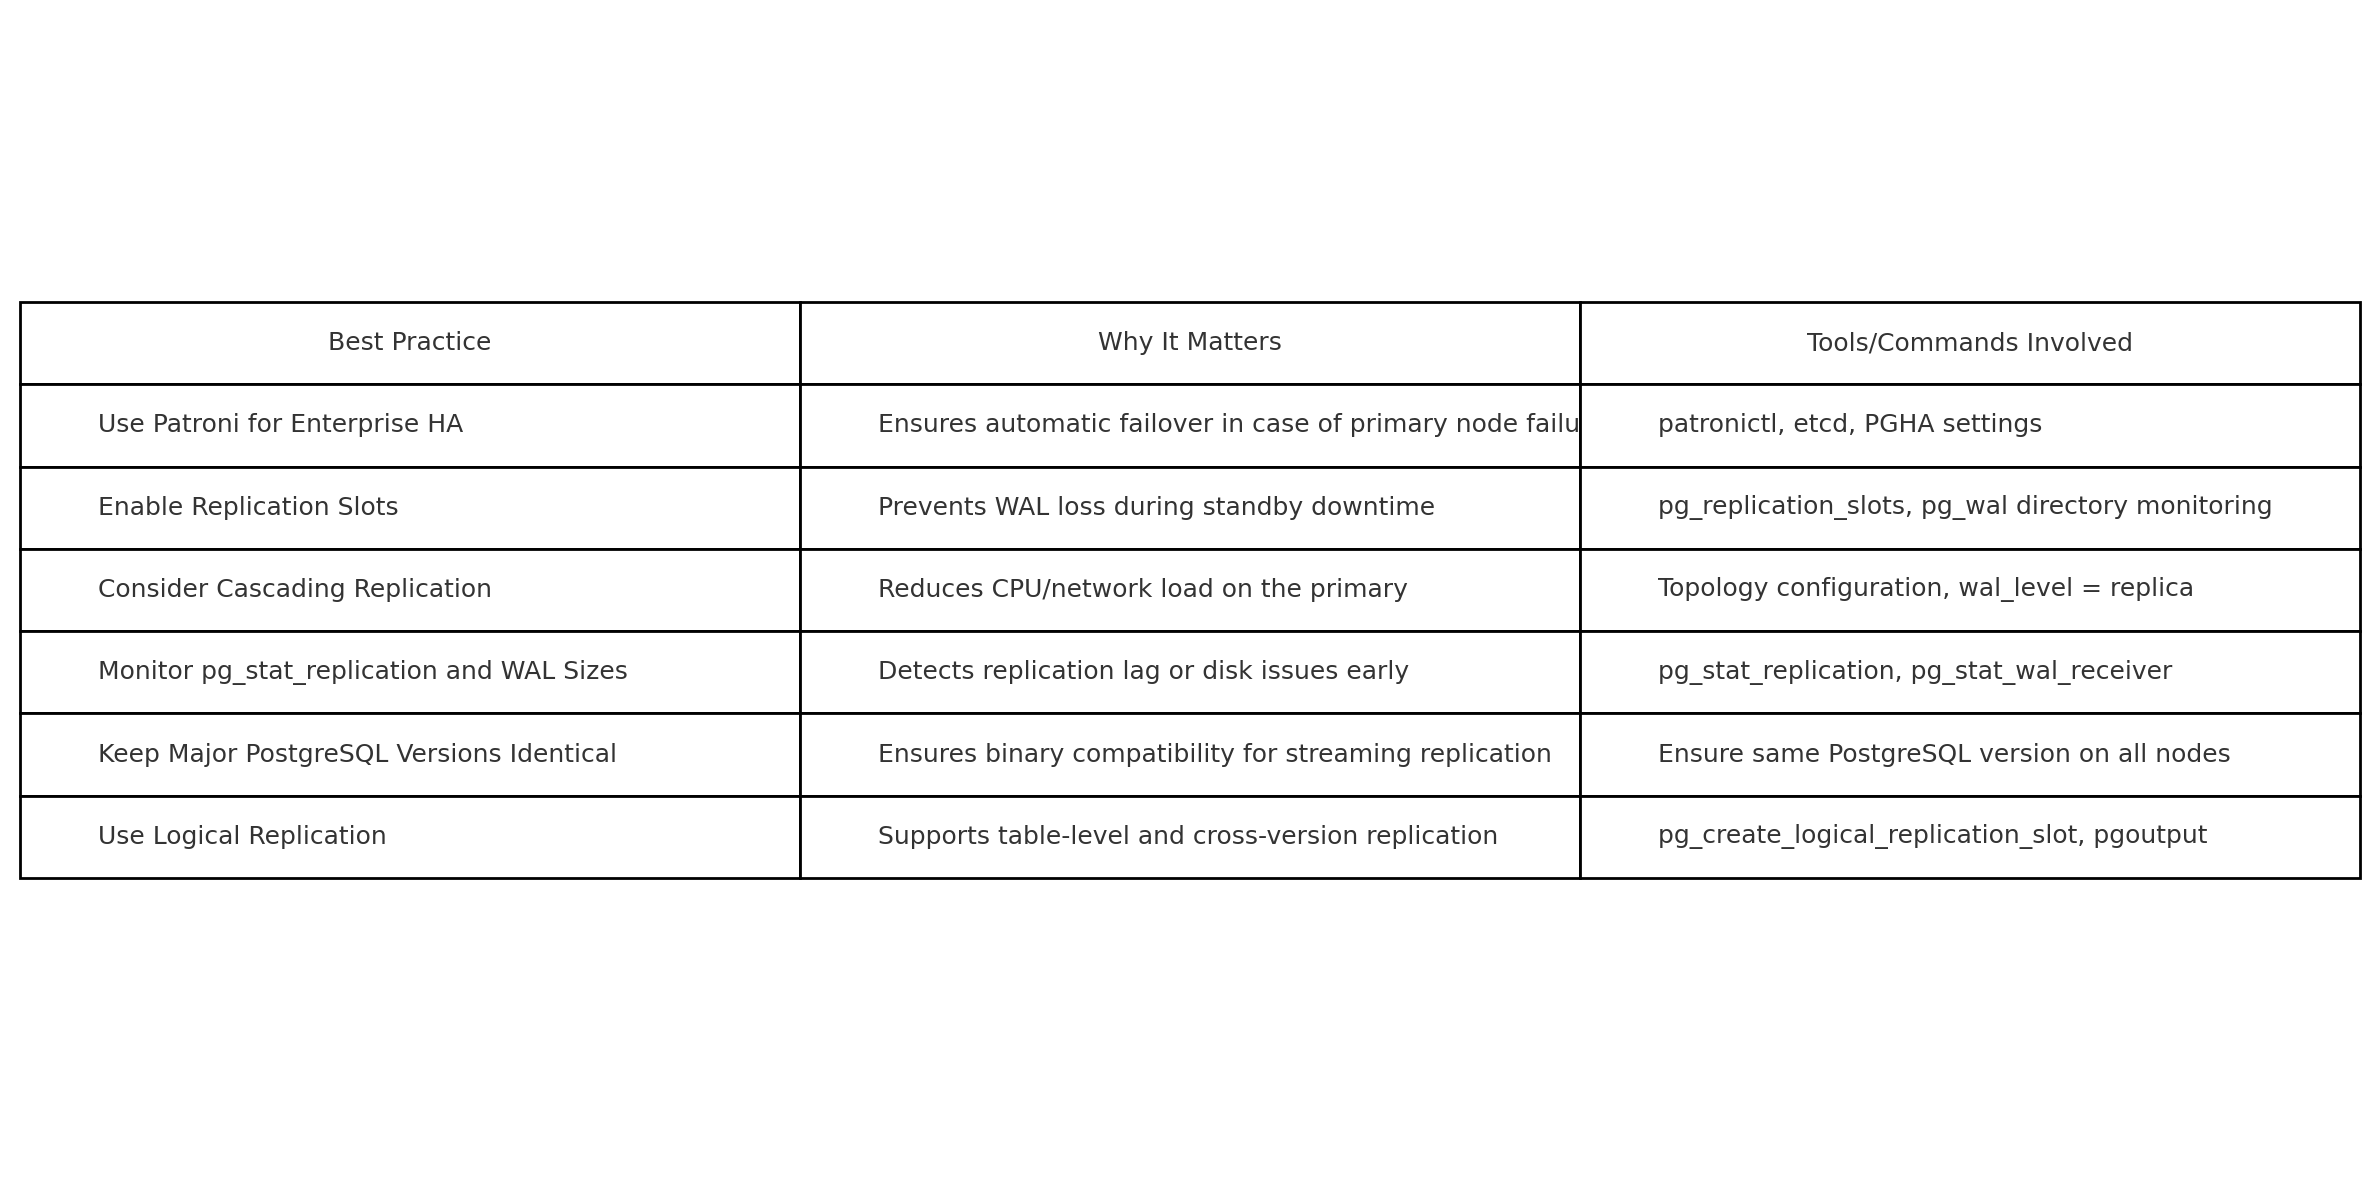

**Here are the filtered Q&A highlights from the PostgreSQL Replication KT session (May 7, 2024) — structured clearly for documentation, interview prep, or reference:**




✅ Q1: What are the differences between Replication Manager and Patroni?
🗣️ Questioner: Varaprasad, Devi
🧑‍🏫 Answer by: Gowda, Ramachandra
📝 Answer:

Both handle replication.

RepManager is user-friendly but requires manual failover.

Patroni is less friendly UI-wise but supports automatic failover with HA configurations (e.g., timeout of 120 seconds).

✅ Q2: Is there a limitation on the number of standby nodes connected to a primary?
🗣️ Questioner: Varaprasad, Devi
🧑‍🏫 Answer:

No fixed limit on standby nodes.

But to reduce bandwidth/CPU impact, use cascading replication (standby connected to another standby).

✅ Q3: Can DDLs be run on standby to reduce primary node load?
🗣️ Questioner: Varaprasad, Devi
🧑‍🏫 Answer:

No writes or DDLs allowed on standby.

Standbys are read-only; application must configure connection strings accordingly.

✅ Q4: What happens if an upstream cascading standby (e.g., PR22) goes down?
🗣️ Questioner: Kaoy, Hooi Min
🧑‍🏫 Answer:

Downstream standby (e.g., PR23) won’t get updated until PR22 is back.

Manual rebuild or reattach may be required if outage is long.



✅ Q5: Can Patroni be used for DR (Disaster Recovery)?
🗣️ Questioner: Varaprasad, Devi
🧑‍🏫 Answer:

Yes, Patroni works for both HA and DR use cases across data centers.

✅ Q6: How long can standby stay down without breaking replication?
🗣️ Questioner: KS, Nandan
🧑‍🏫 Answer:

WAL retention is configured up to 1TB, which covers approx. 12–16 hours of downtime in high-load systems (like CloudIQ).

✅ Q7: Is load balancing used between primary and standby?
🗣️ Questioner: KS, Nandan
🧑‍🏫 Answer:

Not used in this setup.

Tools like PgBouncer and PGPool can be used if required.

Here, connection limit set to 1000 was sufficient.

✅ Q8: What are Replication Slots?
🗣️ Questioner: Pinnapati, Mohanraj
🧑‍🏫 Answer:

Ensures WAL files are retained until the standby successfully replays them.

Prevents WAL loss during standby downtime.

✅ Q9: Will WAL size grow if standby is down?
🗣️ Questioner: Pinnapati, Mohanraj
🧑‍🏫 Answer:

Yes. WAL size increases until standby comes back and syncs.

Replication slot ensures they’re not deleted prematurely.

✅ Q10: What processes manage WAL transfer?
🧑‍🏫 Answer:

WAL Sender: Runs on primary.

WAL Receiver: Runs on standby.

Maximum 10 WAL senders can be configured.

✅ Q11: How to monitor replication status?
🧑‍🏫 Answer:

Use SQL:

sql
Copy
Edit
SELECT * FROM pg_stat_replication;
Check replay_lag, flush_lag, write_lag

Also:

sql
Copy
Edit
SELECT * FROM pg_stat_wal_receiver;
✅ Q12: Can pg_sh_status be used with RepManager?
🗣️ Questioner: Varaprasad, Devi
🧑‍🏫 Answer:

No, pg_sh_status is only used in Patroni-based setups.

✅ Q13: How to do a manual switchover in RepManager?
🧑‍🏫 Answer:

From standby node:

bash
Copy
Edit
repmgr standby switchover --dry-run  # validate
repmgr standby switchover            # perform switchover
✅ Q14: How to validate WAL streaming from standby?
🧑‍🏫 Answer:

On standby:

sql
Copy
Edit
SELECT * FROM pg_stat_wal_receiver;


replication slots

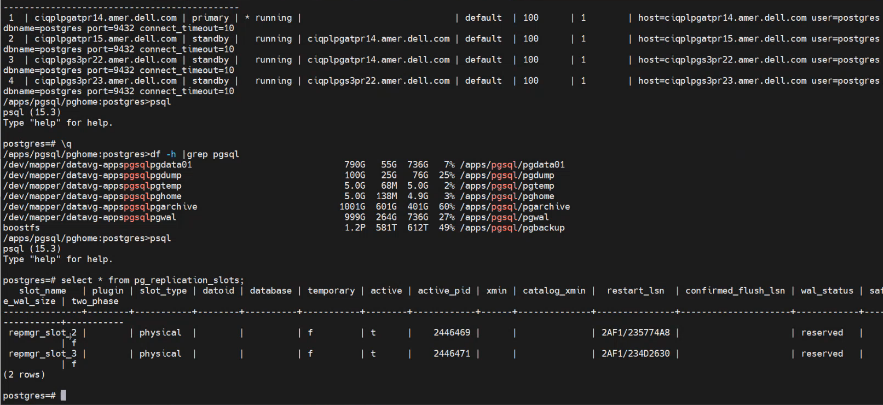

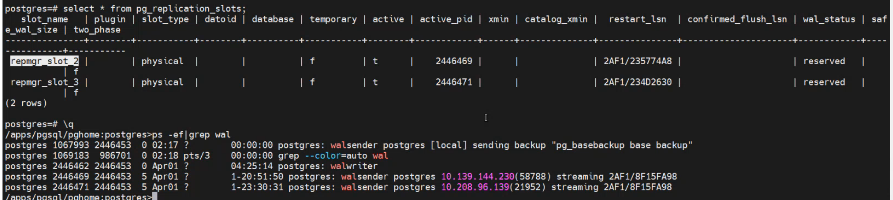

# Show max_wal_senders ;


repmgr -f /apps/pgsql/pghome/repmgr.conf cluster show

select * from pg_stat_activity limit 5;
select usename,state,count(*) from pg_stat_activity group by usename,state;
select client_addr,state,count(pid) from pg_stat_activity group by client_addr,state order by client_addr;

Blocking session
select pg_blocking_pids(pid) as blocked_by from pg_stat_activity where cardinality(pg_blocking_pids(pid)) > 0;
select pg_terminate_backend(85788);

/apps/pgsql/pghome:postgres>hostname
ciqplpgatpr14.amer.dell.com
/apps/pgsql/pghome:postgres>repmgr -f /apps/pgsql/pghome/repmgr.conf cluster show
 ID | Name                        | Role    | Status    | Upstream                    | Location | Priority | Timeline | Connection string                              
----+-----------------------------+---------+-----------+-----------------------------+----------+----------+----------+---------------------------------------------------------------------------------------------
 1  | ciqplpgatpr14.amer.dell.com | primary | * running |                             | default  | 100      | 1        | host=ciqplpgatpr14.amer.dell.com user=postgres dbname=postgres port=9432 connect_timeout=10
 2  | ciqplpgatpr15.amer.dell.com | standby |   running | ciqplpgatpr14.amer.dell.com | default  | 100      | 1        | host=ciqplpgatpr15.amer.dell.com user=postgres dbname=postgres port=9432 connect_timeout=10
 3  | ciqplpgs3pr22.amer.dell.com | standby |   running | ciqplpgatpr14.amer.dell.com | default  | 100      | 1        | host=ciqplpgs3pr22.amer.dell.com user=postgres dbname=postgres port=9432 connect_timeout=10
 4  | ciqplpgs3pr23.amer.dell.com | standby |   running | ciqplpgs3pr22.amer.dell.com | default  | 100      | 1        | host=ciqplpgs3pr23.amer.dell.com user=postgres dbname=postgres port=9432 connect_timeout=10
/apps/pgsql/pghome:postgres>alias
alias egrep='egrep --color=auto'
alias fgrep='fgrep --color=auto'
alias grep='grep --color=auto'
alias l.='ls -d .* --color=auto'
alias ll='ls -l --color=auto'
alias ls='ls --color=auto'
alias pgreloadcfg='pg_ctl reload'
alias pgrestart='sudo /usr/bin/systemctl restart postgresql-15'
alias pgstart='sudo /usr/bin/systemctl start postgresql-15'
alias pgstatus='sudo /usr/bin/systemctl status postgresql-15'
alias pgstop='sudo /usr/bin/systemctl stop postgresql-15'
alias xzegrep='xzegrep --color=auto'
alias xzfgrep='xzfgrep --color=auto'
alias xzgrep='xzgrep --color=auto'
alias zegrep='zegrep --color=auto'
alias zfgrep='zfgrep --color=auto'
alias zgrep='zgrep --color=auto'
/apps/pgsql/pghome:postgres>pgstatus
● postgresql-15.service - PostgreSQL 15 database server
   Loaded: loaded (/usr/lib/systemd/system/postgresql-15.service; enabled; vendor preset: disabled)
  Drop-In: /etc/systemd/system/postgresql-15.service.d
           └─override.conf
   Active: active (running) since Mon 2024-04-01 03:37:34 EDT; 1 months 0 days ago
     Docs: https://www.postgresql.org/docs/15/static/
 Main PID: 2446453 (postmaster)
    Tasks: 238 (limit: 821478)
   Memory: 121.5G
   CGroup: /system.slice/postgresql-15.service
           ├─2446453 /usr/pgsql-15/bin/postmaster -D /apps/pgsql/pgdata01/ciqp
           ├─2446456 postgres: logger
           ├─2446459 postgres: checkpointer
           ├─2446460 postgres: background writer
           ├─2446462 postgres: walwriter
           ├─2446463 postgres: autovacuum launcher
           ├─2446464 postgres: archiver last was 0000000100002336000000B4
           ├─2446465 postgres: logical replication launcher
           ├─2446469 postgres: walsender postgres 10.139.144.230(58788) streaming 2336/B5882208
           ├─2446471 postgres: walsender postgres 10.208.96.139(21952) streaming 2336/B5882208
           ├─3451932 postgres: ciquser prd_dataapidb 10.218.162.244(47562) idle
           ├─3452079 postgres: ciquser prd_dataapidb 10.218.162.74(39630) idle
           ├─3452080 postgres: ciquser prd_dataapidb 10.218.162.248(47320) idle
           ├─3452653 postgres: ciquser prd_dataapidb 10.218.162.74(39656) idle
           ├─3452704 postgres: ciquser prd_dataapidb 10.218.162.74(39668) idle
           ├─3452728 postgres: ciquser prd_dataapidb 10.218.162.237(56410) idle
           ├─3452767 postgres: ciquser prd_dataapidb 10.218.162.74(37450) UPDATE
           ├─3452768 postgres: ciquser prd_dataapidb 10.218.162.91(38844) UPDATE
           ├─3452769 postgres: ciquser prd_dataapidb 10.218.162.79(34766) UPDATE
           ├─3452770 postgres: ciquser prd_dataapidb 10.218.162.190(53910) idle
           ├─3452771 postgres: ciquser prd_dataapidb 10.218.162.202(40802) idle
           ├─3452775 postgres: ciquser prd_dataapidb 10.218.162.244(49652) idle
           ├─3452778 postgres: ciquser prd_dataapidb 10.218.162.218(46896) idle
           ├─3452779 postgres: ciquser prd_dataapidb 10.218.162.74(37456) idle
           ├─3452781 postgres: ciquser prd_dataapidb 10.218.162.79(34776) idle
           ├─3452783 postgres: ciquser prd_dataapidb 10.218.162.74(37466) UPDATE
           ├─3452785 postgres: ciquser prd_dataapidb 10.218.162.168(39660) UPDATE
           ├─3452797 postgres: ciquser prd_dataapidb 10.218.162.91(34350) idle

/apps/pgsql/pghome:postgres>cd /apps/pgsql/pgdata01/ciqp
/apps/pgsql/pgdata01/ciqp:postgres>ls -ltr
total 80
lrwxrwxrwx 1 postgres postgres    22 Mar 14 02:17 pg_wal -> /apps/pgsql/pgwal/ciqp
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_commit_ts
-rw------- 1 postgres postgres     3 Mar 14 02:17 PG_VERSION
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_twophase
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_tblspc
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_snapshots
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_serial
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_notify
drwx------ 4 postgres postgres    36 Mar 14 02:17 pg_multixact
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_dynshmem
-rw------- 1 postgres postgres    88 Mar 14 02:17 postgresql.auto.conf
-rw------- 1 postgres postgres  1636 Mar 14 02:17 pg_ident.conf
-rw------- 1 postgres postgres 29495 Mar 14 02:17 postgresql.conf
-rw------- 1 postgres postgres  5283 Mar 14 02:17 pg_hba.conf
drwx------ 2 postgres postgres   188 Mar 20 00:00 log
drwx------ 2 postgres postgres    35 Apr  1 03:37 pg_stat_tmp
-rw------- 1 postgres postgres    60 Apr  1 03:37 postmaster.opts
drwx------ 2 postgres postgres     6 Apr  1 03:37 pg_stat
-rw------- 1 postgres postgres   101 Apr  1 03:37 postmaster.pid
drwx------ 4 postgres postgres    48 Apr  1 04:08 pg_replslot
drwx------ 8 postgres postgres    77 Apr  6 02:24 base
-rw------- 1 postgres postgres  1436 Apr  6 04:28 init_postgres.conf
-rw------- 1 postgres postgres    30 May  2 00:00 current_logfiles
drwx------ 4 postgres postgres    68 May  2 02:03 pg_logical
drwx------ 2 postgres postgres  4096 May  2 02:04 pg_xact
drwx------ 2 postgres postgres  4096 May  2 02:04 global
drwx------ 2 postgres postgres   330 May  2 02:04 pg_subtrans
/apps/pgsql/pgdata01/ciqp:postgres>cat postgresql.conf
# -----------------------------
# PostgreSQL configuration file
# -----------------------------
#
# This file consists of lines of the form:
#
#   name = value
#
# (The "=" is optional.)  Whitespace may be used.  Comments are introduced with
# "#" anywhere on a line.  The complete list of parameter names and allowed
# values can be found in the PostgreSQL documentation.
#
# The commented-out settings shown in this file represent the default values.
# Re-commenting a setting is NOT sufficient to revert it to the default value;
# you need to reload the server.
#
# This file is read on server startup and when the server receives a SIGHUP
# signal.  If you edit the file on a running system, you have to SIGHUP the
# server for the changes to take effect, run "pg_ctl reload", or execute
# "SELECT pg_reload_conf()".  Some parameters, which are marked below,
# require a server shutdown and restart to take effect.
#
# Any parameter can also be given as a command-line option to the server, e.g.,
# "postgres -c log_connections=on".  Some parameters can be changed at run time
# with the "SET" SQL command.
#
# Memory units:  B  = bytes            Time units:  us  = microseconds
#                kB = kilobytes                     ms  = milliseconds
#                MB = megabytes                     s   = seconds
#                GB = gigabytes                     min = minutes
#                TB = terabytes                     h   = hours
#                                                   d   = days


#------------------------------------------------------------------------------
# FILE LOCATIONS
#------------------------------------------------------------------------------

# The default values of these variables are driven from the -D command-line
# option or PGDATA environment variable, represented here as ConfigDir.

#data_directory = 'ConfigDir'           # use data in another directory
                                        # (change requires restart)
#hba_file = 'ConfigDir/pg_hba.conf'     # host-based authentication file
                                        # (change requires restart)
#ident_file = 'ConfigDir/pg_ident.conf' # ident configuration file
                                        # (change requires restart)

# If external_pid_file is not explicitly set, no extra PID file is written.
#external_pid_file = ''                 # write an extra PID file
                                        # (change requires restart)


#------------------------------------------------------------------------------
# CONNECTIONS AND AUTHENTICATION
#------------------------------------------------------------------------------

# - Connection Settings -

#listen_addresses = 'localhost'         # what IP address(es) to listen on;
                                        # comma-separated list of addresses;
                                        # defaults to 'localhost'; use '*' for all
                                        # (change requires restart)
#port = 5432                            # (change requires restart)
max_connections = 100                   # (change requires restart)
#superuser_reserved_connections = 3     # (change requires restart)
#unix_socket_directories = '/var/run/postgresql, /tmp'  # comma-separated list of directories
                                        # (change requires restart)
#unix_socket_group = ''                 # (change requires restart)
#unix_socket_permissions = 0777         # begin with 0 to use octal notation
                                        # (change requires restart)
#bonjour = off                          # advertise server via Bonjour
                                        # (change requires restart)
#bonjour_name = ''                      # defaults to the computer name
                                        # (change requires restart)

# - TCP settings -
# see "man tcp" for details

#tcp_keepalives_idle = 0                # TCP_KEEPIDLE, in seconds;
                                        # 0 selects the system default
#tcp_keepalives_interval = 0            # TCP_KEEPINTVL, in seconds;
                                        # 0 selects the system default
#tcp_keepalives_count = 0               # TCP_KEEPCNT;
                                        # 0 selects the system default
#tcp_user_timeout = 0                   # TCP_USER_TIMEOUT, in milliseconds;
                                        # 0 selects the system default

#client_connection_check_interval = 0   # time between checks for client
                                        # disconnection while running queries;
                                        # 0 for never

# - Authentication -

#authentication_timeout = 1min          # 1s-600s
#password_encryption = scram-sha-256    # scram-sha-256 or md5
#db_user_namespace = off

# GSSAPI using Kerberos
#krb_server_keyfile = 'FILE:${sysconfdir}/krb5.keytab'
#krb_caseins_users = off

# - SSL -

#ssl = off
#ssl_ca_file = ''
#ssl_cert_file = 'server.crt'
#ssl_crl_file = ''
#ssl_crl_dir = ''
#ssl_key_file = 'server.key'
#ssl_ciphers = 'HIGH:MEDIUM:+3DES:!aNULL' # allowed SSL ciphers
#ssl_prefer_server_ciphers = on
#ssl_ecdh_curve = 'prime256v1'
#ssl_min_protocol_version = 'TLSv1.2'
#ssl_max_protocol_version = ''
#ssl_dh_params_file = ''
#ssl_passphrase_command = ''
#ssl_passphrase_command_supports_reload = off


#------------------------------------------------------------------------------
# RESOURCE USAGE (except WAL)
#------------------------------------------------------------------------------

# - Memory -

shared_buffers = 128MB                  # min 128kB
                                        # (change requires restart)
#huge_pages = try                       # on, off, or try
                                        # (change requires restart)
#huge_page_size = 0                     # zero for system default
                                        # (change requires restart)
#temp_buffers = 8MB                     # min 800kB
#max_prepared_transactions = 0          # zero disables the feature
                                        # (change requires restart)
# Caution: it is not advisable to set max_prepared_transactions nonzero unless
# you actively intend to use prepared transactions.
#work_mem = 4MB                         # min 64kB
#hash_mem_multiplier = 2.0              # 1-1000.0 multiplier on hash table work_mem
#maintenance_work_mem = 64MB            # min 1MB
#autovacuum_work_mem = -1               # min 1MB, or -1 to use maintenance_work_mem
#logical_decoding_work_mem = 64MB       # min 64kB
#max_stack_depth = 2MB                  # min 100kB
#shared_memory_type = mmap              # the default is the first option
                                        # supported by the operating system:
                                        #   mmap
                                        #   sysv
                                        #   windows
                                        # (change requires restart)
dynamic_shared_memory_type = posix      # the default is usually the first option
                                        # supported by the operating system:
                                        #   posix
                                        #   sysv
                                        #   windows
                                        #   mmap
                                        # (change requires restart)
#min_dynamic_shared_memory = 0MB        # (change requires restart)

# - Disk -

#temp_file_limit = -1                   # limits per-process temp file space
                                        # in kilobytes, or -1 for no limit

# - Kernel Resources -

#max_files_per_process = 1000           # min 64
                                        # (change requires restart)

# - Cost-Based Vacuum Delay -

#vacuum_cost_delay = 0                  # 0-100 milliseconds (0 disables)
#vacuum_cost_page_hit = 1               # 0-10000 credits
#vacuum_cost_page_miss = 2              # 0-10000 credits
#vacuum_cost_page_dirty = 20            # 0-10000 credits
#vacuum_cost_limit = 200                # 1-10000 credits

# - Background Writer -

#bgwriter_delay = 200ms                 # 10-10000ms between rounds
#bgwriter_lru_maxpages = 100            # max buffers written/round, 0 disables
#bgwriter_lru_multiplier = 2.0          # 0-10.0 multiplier on buffers scanned/round
#bgwriter_flush_after = 512kB           # measured in pages, 0 disables

# - Asynchronous Behavior -

#backend_flush_after = 0                # measured in pages, 0 disables
#effective_io_concurrency = 1           # 1-1000; 0 disables prefetching
#maintenance_io_concurrency = 10        # 1-1000; 0 disables prefetching
#max_worker_processes = 8               # (change requires restart)
#max_parallel_workers_per_gather = 2    # taken from max_parallel_workers
#max_parallel_maintenance_workers = 2   # taken from max_parallel_workers
#max_parallel_workers = 8               # maximum number of max_worker_processes that
                                        # can be used in parallel operations
#parallel_leader_participation = on
#old_snapshot_threshold = -1            # 1min-60d; -1 disables; 0 is immediate
                                        # (change requires restart)


#------------------------------------------------------------------------------
# WRITE-AHEAD LOG
#------------------------------------------------------------------------------

# - Settings -

#wal_level = replica                    # minimal, replica, or logical
                                        # (change requires restart)
#fsync = on                             # flush data to disk for crash safety
                                        # (turning this off can cause
                                        # unrecoverable data corruption)
#synchronous_commit = on                # synchronization level;
                                        # off, local, remote_write, remote_apply, or on
#wal_sync_method = fsync                # the default is the first option
                                        # supported by the operating system:
                                        #   open_datasync
                                        #   fdatasync (default on Linux and FreeBSD)
                                        #   fsync
                                        #   fsync_writethrough
                                        #   open_sync
#full_page_writes = on                  # recover from partial page writes
#wal_log_hints = off                    # also do full page writes of non-critical updates
                                        # (change requires restart)
#wal_compression = off                  # enables compression of full-page writes;
                                        # off, pglz, lz4, zstd, or on
#wal_init_zero = on                     # zero-fill new WAL files
#wal_recycle = on                       # recycle WAL files
#wal_buffers = -1                       # min 32kB, -1 sets based on shared_buffers
                                        # (change requires restart)
#wal_writer_delay = 200ms               # 1-10000 milliseconds
#wal_writer_flush_after = 1MB           # measured in pages, 0 disables
#wal_skip_threshold = 2MB

#commit_delay = 0                       # range 0-100000, in microseconds
#commit_siblings = 5                    # range 1-1000

# - Checkpoints -

#checkpoint_timeout = 5min              # range 30s-1d
#checkpoint_completion_target = 0.9     # checkpoint target duration, 0.0 - 1.0
#checkpoint_flush_after = 256kB         # measured in pages, 0 disables
#checkpoint_warning = 30s               # 0 disables
max_wal_size = 1GB
min_wal_size = 80MB

# - Prefetching during recovery -

#recovery_prefetch = try                # prefetch pages referenced in the WAL?
#wal_decode_buffer_size = 512kB         # lookahead window used for prefetching
                                        # (change requires restart)

# - Archiving -

#archive_mode = off             # enables archiving; off, on, or always
                                # (change requires restart)
#archive_library = ''           # library to use to archive a logfile segment
                                # (empty string indicates archive_command should
                                # be used)
#archive_command = ''           # command to use to archive a logfile segment
                                # placeholders: %p = path of file to archive
                                #               %f = file name only
                                # e.g. 'test ! -f /mnt/server/archivedir/%f && cp %p /mnt/server/archivedir/%f'
#archive_timeout = 0            # force a logfile segment switch after this
                                # number of seconds; 0 disables

# - Archive Recovery -

# These are only used in recovery mode.

#restore_command = ''           # command to use to restore an archived logfile segment
                                # placeholders: %p = path of file to restore
                                #               %f = file name only
                                # e.g. 'cp /mnt/server/archivedir/%f %p'
#archive_cleanup_command = ''   # command to execute at every restartpoint
#recovery_end_command = ''      # command to execute at completion of recovery

# - Recovery Target -

# Set these only when performing a targeted recovery.

#recovery_target = ''           # 'immediate' to end recovery as soon as a
                                # consistent state is reached
                                # (change requires restart)
#recovery_target_name = ''      # the named restore point to which recovery will proceed
                                # (change requires restart)
#recovery_target_time = ''      # the time stamp up to which recovery will proceed
                                # (change requires restart)
#recovery_target_xid = ''       # the transaction ID up to which recovery will proceed
                                # (change requires restart)
#recovery_target_lsn = ''       # the WAL LSN up to which recovery will proceed
                                # (change requires restart)
#recovery_target_inclusive = on # Specifies whether to stop:
                                # just after the specified recovery target (on)
                                # just before the recovery target (off)
                                # (change requires restart)
#recovery_target_timeline = 'latest'    # 'current', 'latest', or timeline ID
                                # (change requires restart)
#recovery_target_action = 'pause'       # 'pause', 'promote', 'shutdown'
                                # (change requires restart)


#------------------------------------------------------------------------------
# REPLICATION
#------------------------------------------------------------------------------

# - Sending Servers -

# Set these on the primary and on any standby that will send replication data.

#max_wal_senders = 10           # max number of walsender processes
                                # (change requires restart)
#max_replication_slots = 10     # max number of replication slots
                                # (change requires restart)
#wal_keep_size = 0              # in megabytes; 0 disables
#max_slot_wal_keep_size = -1    # in megabytes; -1 disables
#wal_sender_timeout = 60s       # in milliseconds; 0 disables
#track_commit_timestamp = off   # collect timestamp of transaction commit
                                # (change requires restart)

# - Primary Server -

# These settings are ignored on a standby server.

#synchronous_standby_names = '' # standby servers that provide sync rep
                                # method to choose sync standbys, number of sync standbys,
                                # and comma-separated list of application_name
                                # from standby(s); '*' = all
#vacuum_defer_cleanup_age = 0   # number of xacts by which cleanup is delayed

# - Standby Servers -

# These settings are ignored on a primary server.

#primary_conninfo = ''                  # connection string to sending server
#primary_slot_name = ''                 # replication slot on sending server
#promote_trigger_file = ''              # file name whose presence ends recovery
#hot_standby = on                       # "off" disallows queries during recovery
                                        # (change requires restart)
#max_standby_archive_delay = 30s        # max delay before canceling queries
                                        # when reading WAL from archive;
                                        # -1 allows indefinite delay
#max_standby_streaming_delay = 30s      # max delay before canceling queries
                                        # when reading streaming WAL;
                                        # -1 allows indefinite delay
#wal_receiver_create_temp_slot = off    # create temp slot if primary_slot_name
                                        # is not set
#wal_receiver_status_interval = 10s     # send replies at least this often
                                        # 0 disables
#hot_standby_feedback = off             # send info from standby to prevent
                                        # query conflicts
#wal_receiver_timeout = 60s             # time that receiver waits for
                                        # communication from primary
                                        # in milliseconds; 0 disables
#wal_retrieve_retry_interval = 5s       # time to wait before retrying to
                                        # retrieve WAL after a failed attempt
#recovery_min_apply_delay = 0           # minimum delay for applying changes during recovery

# - Subscribers -

# These settings are ignored on a publisher.

#max_logical_replication_workers = 4    # taken from max_worker_processes
                                        # (change requires restart)
#max_sync_workers_per_subscription = 2  # taken from max_logical_replication_workers


#------------------------------------------------------------------------------
# QUERY TUNING
#------------------------------------------------------------------------------

# - Planner Method Configuration -

#enable_async_append = on
#enable_bitmapscan = on
#enable_gathermerge = on
#enable_hashagg = on
#enable_hashjoin = on
#enable_incremental_sort = on
#enable_indexscan = on
#enable_indexonlyscan = on
#enable_material = on
#enable_memoize = on
#enable_mergejoin = on
#enable_nestloop = on
#enable_parallel_append = on
#enable_parallel_hash = on
#enable_partition_pruning = on
#enable_partitionwise_join = off
#enable_partitionwise_aggregate = off
#enable_seqscan = on
#enable_sort = on
#enable_tidscan = on

# - Planner Cost Constants -

#seq_page_cost = 1.0                    # measured on an arbitrary scale
#random_page_cost = 4.0                 # same scale as above
#cpu_tuple_cost = 0.01                  # same scale as above
#cpu_index_tuple_cost = 0.005           # same scale as above
#cpu_operator_cost = 0.0025             # same scale as above
#parallel_setup_cost = 1000.0   # same scale as above
#parallel_tuple_cost = 0.1              # same scale as above
#min_parallel_table_scan_size = 8MB
#min_parallel_index_scan_size = 512kB
#effective_cache_size = 4GB

#jit_above_cost = 100000                # perform JIT compilation if available
                                        # and query more expensive than this;
                                        # -1 disables
#jit_inline_above_cost = 500000         # inline small functions if query is
                                        # more expensive than this; -1 disables
#jit_optimize_above_cost = 500000       # use expensive JIT optimizations if
                                        # query is more expensive than this;
                                        # -1 disables

# - Genetic Query Optimizer -

#geqo = on
#geqo_threshold = 12
#geqo_effort = 5                        # range 1-10
#geqo_pool_size = 0                     # selects default based on effort
#geqo_generations = 0                   # selects default based on effort
#geqo_selection_bias = 2.0              # range 1.5-2.0
#geqo_seed = 0.0                        # range 0.0-1.0

# - Other Planner Options -

#default_statistics_target = 100        # range 1-10000
#constraint_exclusion = partition       # on, off, or partition
#cursor_tuple_fraction = 0.1            # range 0.0-1.0
#from_collapse_limit = 8
#jit = on                               # allow JIT compilation
#join_collapse_limit = 8                # 1 disables collapsing of explicit
                                        # JOIN clauses
#plan_cache_mode = auto                 # auto, force_generic_plan or
                                        # force_custom_plan
#recursive_worktable_factor = 10.0      # range 0.001-1000000


#------------------------------------------------------------------------------
# REPORTING AND LOGGING
#------------------------------------------------------------------------------

# - Where to Log -

log_destination = 'stderr'              # Valid values are combinations of
                                        # stderr, csvlog, jsonlog, syslog, and
                                        # eventlog, depending on platform.
                                        # csvlog and jsonlog require
                                        # logging_collector to be on.

# This is used when logging to stderr:
logging_collector = on                  # Enable capturing of stderr, jsonlog,
                                        # and csvlog into log files. Required
                                        # to be on for csvlogs and jsonlogs.
                                        # (change requires restart)

# These are only used if logging_collector is on:
log_directory = 'log'                   # directory where log files are written,
                                        # can be absolute or relative to PGDATA
log_filename = 'postgresql-%a.log'      # log file name pattern,
                                        # can include strftime() escapes
#log_file_mode = 0600                   # creation mode for log files,
                                        # begin with 0 to use octal notation
log_rotation_age = 1d                   # Automatic rotation of logfiles will
                                        # happen after that time.  0 disables.
log_rotation_size = 0                   # Automatic rotation of logfiles will
                                        # happen after that much log output.
                                        # 0 disables.
log_truncate_on_rotation = on           # If on, an existing log file with the
                                        # same name as the new log file will be
                                        # truncated rather than appended to.
                                        # But such truncation only occurs on
                                        # time-driven rotation, not on restarts
                                        # or size-driven rotation.  Default is
                                        # off, meaning append to existing files
                                        # in all cases.

# These are relevant when logging to syslog:
#syslog_facility = 'LOCAL0'
#syslog_ident = 'postgres'
#syslog_sequence_numbers = on
#syslog_split_messages = on

# This is only relevant when logging to eventlog (Windows):
# (change requires restart)
#event_source = 'PostgreSQL'

# - When to Log -

#log_min_messages = warning             # values in order of decreasing detail:
                                        #   debug5
                                        #   debug4
                                        #   debug3
                                        #   debug2
                                        #   debug1
                                        #   info
                                        #   notice
                                        #   warning
                                        #   error
                                        #   log
                                        #   fatal
                                        #   panic

#log_min_error_statement = error        # values in order of decreasing detail:
                                        #   debug5
                                        #   debug4
                                        #   debug3
                                        #   debug2
                                        #   debug1
                                        #   info
                                        #   notice
                                        #   warning
                                        #   error
                                        #   log
                                        #   fatal
                                        #   panic (effectively off)

#log_min_duration_statement = -1        # -1 is disabled, 0 logs all statements
                                        # and their durations, > 0 logs only
                                        # statements running at least this number
                                        # of milliseconds

#log_min_duration_sample = -1           # -1 is disabled, 0 logs a sample of statements
                                        # and their durations, > 0 logs only a sample of
                                        # statements running at least this number
                                        # of milliseconds;
                                        # sample fraction is determined by log_statement_sample_rate

#log_statement_sample_rate = 1.0        # fraction of logged statements exceeding
                                        # log_min_duration_sample to be logged;
                                        # 1.0 logs all such statements, 0.0 never logs


#log_transaction_sample_rate = 0.0      # fraction of transactions whose statements
                                        # are logged regardless of their duration; 1.0 logs all
                                        # statements from all transactions, 0.0 never logs

#log_startup_progress_interval = 10s    # Time between progress updates for
                                        # long-running startup operations.
                                        # 0 disables the feature, > 0 indicates
                                        # the interval in milliseconds.

# - What to Log -

#debug_print_parse = off
#debug_print_rewritten = off
#debug_print_plan = off
#debug_pretty_print = on
#log_autovacuum_min_duration = 10min    # log autovacuum activity;
                                        # -1 disables, 0 logs all actions and
                                        # their durations, > 0 logs only
                                        # actions running at least this number
                                        # of milliseconds.
#log_checkpoints = on
#log_connections = off
#log_disconnections = off
#log_duration = off
#log_error_verbosity = default          # terse, default, or verbose messages
#log_hostname = off
log_line_prefix = '%m [%p] '            # special values:
                                        #   %a = application name
                                        #   %u = user name
                                        #   %d = database name
                                        #   %r = remote host and port
                                        #   %h = remote host
                                        #   %b = backend type
                                        #   %p = process ID
                                        #   %P = process ID of parallel group leader
                                        #   %t = timestamp without milliseconds
                                        #   %m = timestamp with milliseconds
                                        #   %n = timestamp with milliseconds (as a Unix epoch)
                                        #   %Q = query ID (0 if none or not computed)
                                        #   %i = command tag
                                        #   %e = SQL state
                                        #   %c = session ID
                                        #   %l = session line number
                                        #   %s = session start timestamp
                                        #   %v = virtual transaction ID
                                        #   %x = transaction ID (0 if none)
                                        #   %q = stop here in non-session
                                        #        processes
                                        #   %% = '%'
                                        # e.g. '<%u%%%d> '
#log_lock_waits = off                   # log lock waits >= deadlock_timeout
#log_recovery_conflict_waits = off      # log standby recovery conflict waits
                                        # >= deadlock_timeout
#log_parameter_max_length = -1          # when logging statements, limit logged
                                        # bind-parameter values to N bytes;
                                        # -1 means print in full, 0 disables
#log_parameter_max_length_on_error = 0  # when logging an error, limit logged
                                        # bind-parameter values to N bytes;
                                        # -1 means print in full, 0 disables
#log_statement = 'none'                 # none, ddl, mod, all
#log_replication_commands = off
#log_temp_files = -1                    # log temporary files equal or larger
                                        # than the specified size in kilobytes;
                                        # -1 disables, 0 logs all temp files
log_timezone = 'America/New_York'


#------------------------------------------------------------------------------
# PROCESS TITLE
#------------------------------------------------------------------------------

#cluster_name = ''                      # added to process titles if nonempty
                                        # (change requires restart)
#update_process_title = on


#------------------------------------------------------------------------------
# STATISTICS
#------------------------------------------------------------------------------

# - Cumulative Query and Index Statistics -

#track_activities = on
#track_activity_query_size = 1024       # (change requires restart)
#track_counts = on
#track_io_timing = off
#track_wal_io_timing = off
#track_functions = none                 # none, pl, all
#stats_fetch_consistency = cache


# - Monitoring -

#compute_query_id = auto
#log_statement_stats = off
#log_parser_stats = off
#log_planner_stats = off
#log_executor_stats = off


#------------------------------------------------------------------------------
# AUTOVACUUM
#------------------------------------------------------------------------------

#autovacuum = on                        # Enable autovacuum subprocess?  'on'
                                        # requires track_counts to also be on.
#autovacuum_max_workers = 3             # max number of autovacuum subprocesses
                                        # (change requires restart)
#autovacuum_naptime = 1min              # time between autovacuum runs
#autovacuum_vacuum_threshold = 50       # min number of row updates before
                                        # vacuum
#autovacuum_vacuum_insert_threshold = 1000      # min number of row inserts
                                        # before vacuum; -1 disables insert
                                        # vacuums
#autovacuum_analyze_threshold = 50      # min number of row updates before
                                        # analyze
#autovacuum_vacuum_scale_factor = 0.2   # fraction of table size before vacuum
#autovacuum_vacuum_insert_scale_factor = 0.2    # fraction of inserts over table
                                        # size before insert vacuum
#autovacuum_analyze_scale_factor = 0.1  # fraction of table size before analyze
#autovacuum_freeze_max_age = 200000000  # maximum XID age before forced vacuum
                                        # (change requires restart)
#autovacuum_multixact_freeze_max_age = 400000000        # maximum multixact age
                                        # before forced vacuum
                                        # (change requires restart)
#autovacuum_vacuum_cost_delay = 2ms     # default vacuum cost delay for
                                        # autovacuum, in milliseconds;
                                        # -1 means use vacuum_cost_delay
#autovacuum_vacuum_cost_limit = -1      # default vacuum cost limit for
                                        # autovacuum, -1 means use
                                        # vacuum_cost_limit


#------------------------------------------------------------------------------
# CLIENT CONNECTION DEFAULTS
#------------------------------------------------------------------------------

# - Statement Behavior -

#client_min_messages = notice           # values in order of decreasing detail:
                                        #   debug5
                                        #   debug4
                                        #   debug3
                                        #   debug2
                                        #   debug1
                                        #   log
                                        #   notice
                                        #   warning
                                        #   error
#search_path = '"$user", public'        # schema names
#row_security = on
#default_table_access_method = 'heap'
#default_tablespace = ''                # a tablespace name, '' uses the default
#default_toast_compression = 'pglz'     # 'pglz' or 'lz4'
#temp_tablespaces = ''                  # a list of tablespace names, '' uses
                                        # only default tablespace
#check_function_bodies = on
#default_transaction_isolation = 'read committed'
#default_transaction_read_only = off
#default_transaction_deferrable = off
#session_replication_role = 'origin'
#statement_timeout = 0                  # in milliseconds, 0 is disabled
#lock_timeout = 0                       # in milliseconds, 0 is disabled
#idle_in_transaction_session_timeout = 0        # in milliseconds, 0 is disabled
#idle_session_timeout = 0               # in milliseconds, 0 is disabled
#vacuum_freeze_table_age = 150000000
#vacuum_freeze_min_age = 50000000
#vacuum_failsafe_age = 1600000000
#vacuum_multixact_freeze_table_age = 150000000
#vacuum_multixact_freeze_min_age = 5000000
#vacuum_multixact_failsafe_age = 1600000000
#bytea_output = 'hex'                   # hex, escape
#xmlbinary = 'base64'
#xmloption = 'content'
#gin_pending_list_limit = 4MB

# - Locale and Formatting -

datestyle = 'iso, mdy'
#intervalstyle = 'postgres'
timezone = 'America/New_York'
#timezone_abbreviations = 'Default'     # Select the set of available time zone
                                        # abbreviations.  Currently, there are
                                        #   Default
                                        #   Australia (historical usage)
                                        #   India
                                        # You can create your own file in
                                        # share/timezonesets/.
#extra_float_digits = 1                 # min -15, max 3; any value >0 actually
                                        # selects precise output mode
#client_encoding = sql_ascii            # actually, defaults to database
                                        # encoding

# These settings are initialized by initdb, but they can be changed.
lc_messages = 'en_US.UTF-8'                     # locale for system error message
                                        # strings
lc_monetary = 'en_US.UTF-8'                     # locale for monetary formatting
lc_numeric = 'en_US.UTF-8'                      # locale for number formatting
lc_time = 'en_US.UTF-8'                         # locale for time formatting

# default configuration for text search
default_text_search_config = 'pg_catalog.english'

# - Shared Library Preloading -

#local_preload_libraries = ''
#session_preload_libraries = ''
#shared_preload_libraries = ''  # (change requires restart)
#jit_provider = 'llvmjit'               # JIT library to use

# - Other Defaults -

#dynamic_library_path = '$libdir'
#gin_fuzzy_search_limit = 0


#------------------------------------------------------------------------------
# LOCK MANAGEMENT
#------------------------------------------------------------------------------

#deadlock_timeout = 1s
#max_locks_per_transaction = 64         # min 10
                                        # (change requires restart)
#max_pred_locks_per_transaction = 64    # min 10
                                        # (change requires restart)
#max_pred_locks_per_relation = -2       # negative values mean
                                        # (max_pred_locks_per_transaction
                                        #  / -max_pred_locks_per_relation) - 1
#max_pred_locks_per_page = 2            # min 0


#------------------------------------------------------------------------------
# VERSION AND PLATFORM COMPATIBILITY
#------------------------------------------------------------------------------

# - Previous PostgreSQL Versions -

#array_nulls = on
#backslash_quote = safe_encoding        # on, off, or safe_encoding
#escape_string_warning = on
#lo_compat_privileges = off
#quote_all_identifiers = off
#standard_conforming_strings = on
#synchronize_seqscans = on

# - Other Platforms and Clients -

#transform_null_equals = off


#------------------------------------------------------------------------------
# ERROR HANDLING
#------------------------------------------------------------------------------

#exit_on_error = off                    # terminate session on any error?
#restart_after_crash = on               # reinitialize after backend crash?
#data_sync_retry = off                  # retry or panic on failure to fsync
                                        # data?
                                        # (change requires restart)
#recovery_init_sync_method = fsync      # fsync, syncfs (Linux 5.8+)


#------------------------------------------------------------------------------
# CONFIG FILE INCLUDES
#------------------------------------------------------------------------------

# These options allow settings to be loaded from files other than the
# default postgresql.conf.  Note that these are directives, not variable
# assignments, so they can usefully be given more than once.

#include_dir = '...'                    # include files ending in '.conf' from
                                        # a directory, e.g., 'conf.d'
#include_if_exists = '...'              # include file only if it exists
#include = '...'                        # include file


#------------------------------------------------------------------------------
# CUSTOMIZED OPTIONS
#------------------------------------------------------------------------------

# Add settings for extensions here
include='init_postgres.conf'
/apps/pgsql/pgdata01/ciqp:postgres>cat init_postgres.conf
port=9432
shared_buffers=32000MB
wal_sync_method='fsync'
password_encryption='md5'
hot_standby = on
wal_keep_size = 250GB
archive_mode = on
max_wal_senders = 10
listen_addresses = '*'
max_connections=1000
wal_level = replica
wal_compression = on
max_replication_slots = 10
wal_log_hints = on
checkpoint_completion_target = 0.9
min_wal_size =10GB
max_wal_size=20GB
work_mem=64MB
random_page_cost=1
effective_io_concurrency = 200
effective_cache_size=96000MB
#maintenance_work_mem=1GB
maintenance_work_mem=2GB
log_min_duration_statement=2000
archive_command = 'test ! -f /apps/pgsql/pgarchive/ciqp/%f && cp %p /apps/pgsql/pgarchive/ciqp/%f'
shared_preload_libraries = 'repmgr,pg_stat_statements,vector'
idle_in_transaction_session_timeout = 5min
autovacuum_vacuum_threshold=25
autovacuum_vacuum_scale_factor=0.1
autovacuum_analyze_scale_factor=0.05
autovacuum_analyze_threshold=10
autovacuum_vacuum_cost_limit=1000
autovacuum_vacuum_cost_delay=-1
log_line_prefix = '%m [%p] :[%e]:'
autovacuum_vacuum_insert_scale_factor = 0.1
ssl = on
ssl_ciphers = 'ECDHE-ECDSA-AES128-GCM-SHA256:ECDHE-RSA-AES128-GCM-SHA256:ECDHE-ECDSA-AES256-GCM-SHA384:ECDHE-RSA-AES256-GCM-SHA384:ECDHE-RSA-CHACHA20-POLY1305:ECDHE-ECDSA-CHACHA20-POLY1305:!aNULL'
ssl_cert_file = '/apps/pgsql/pghome/tls_certs/server.cert'
ssl_key_file = '/apps/pgsql/pghome/tls_certs/server.key'
ssl_ca_file = '/apps/pgsql/pghome/tls_certs/root.cert'
max_parallel_maintenance_workers=6
/apps/pgsql/pgdata01/ciqp:postgres>psql
psql (15.3)
Type "help" for help.

postgres=# select version();
                                                 version
---------------------------------------------------------------------------------------------------------
 PostgreSQL 15.3 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 8.5.0 20210514 (Red Hat 8.5.0-18), 64-bit
(1 row)

postgres=# \?
General
  \copyright             show PostgreSQL usage and distribution terms
  \crosstabview [COLUMNS] execute query and display result in crosstab
  \errverbose            show most recent error message at maximum verbosity
  \g [(OPTIONS)] [FILE]  execute query (and send result to file or |pipe);
                         \g with no arguments is equivalent to a semicolon
  \gdesc                 describe result of query, without executing it
  \gexec                 execute query, then execute each value in its result
  \gset [PREFIX]         execute query and store result in psql variables
  \gx [(OPTIONS)] [FILE] as \g, but forces expanded output mode
  \q                     quit psql
  \watch [SEC]           execute query every SEC seconds

Help
  \? [commands]          show help on backslash commands
  \? options             show help on psql command-line options
  \? variables           show help on special variables
  \h [NAME]              help on syntax of SQL commands, * for all commands

Query Buffer
  \e [FILE] [LINE]       edit the query buffer (or file) with external editor
  \ef [FUNCNAME [LINE]]  edit function definition with external editor
  \ev [VIEWNAME [LINE]]  edit view definition with external editor
  \p                     show the contents of the query buffer
  \r                     reset (clear) the query buffer
  \s [FILE]              display history or save it to file
  \w FILE                write query buffer to file

Input/Output
  \copy ...              perform SQL COPY with data stream to the client host
  \echo [-n] [STRING]    write string to standard output (-n for no newline)
  \i FILE                execute commands from file
  \ir FILE               as \i, but relative to location of current script
  \o [FILE]              send all query results to file or |pipe
  \qecho [-n] [STRING]   write string to \o output stream (-n for no newline)
  \warn [-n] [STRING]    write string to standard error (-n for no newline)

Conditional
  \if EXPR               begin conditional block
  \elif EXPR             alternative within current conditional block
  \else                  final alternative within current conditional block
  \endif                 end conditional block

Informational
  (options: S = show system objects, + = additional detail)
  \d[S+]                 list tables, views, and sequences
  \d[S+]  NAME           describe table, view, sequence, or index
  \da[S]  [PATTERN]      list aggregates
  \dA[+]  [PATTERN]      list access methods
  \dAc[+] [AMPTRN [TYPEPTRN]]  list operator classes
  \dAf[+] [AMPTRN [TYPEPTRN]]  list operator families
  \dAo[+] [AMPTRN [OPFPTRN]]   list operators of operator families
  \dAp[+] [AMPTRN [OPFPTRN]]   list support functions of operator families
  \db[+]  [PATTERN]      list tablespaces
  \dc[S+] [PATTERN]      list conversions
  \dconfig[+] [PATTERN]  list configuration parameters
  \dC[+]  [PATTERN]      list casts
  \dd[S]  [PATTERN]      show object descriptions not displayed elsewhere
  \dD[S+] [PATTERN]      list domains
  \ddp    [PATTERN]      list default privileges
  \dE[S+] [PATTERN]      list foreign tables
  \des[+] [PATTERN]      list foreign servers
  \det[+] [PATTERN]      list foreign tables
  \deu[+] [PATTERN]      list user mappings
  \dew[+] [PATTERN]      list foreign-data wrappers
  \df[anptw][S+] [FUNCPTRN [TYPEPTRN ...]]
                         list [only agg/normal/procedure/trigger/window] functions
  \dF[+]  [PATTERN]      list text search configurations
  \dFd[+] [PATTERN]      list text search dictionaries
  \dFp[+] [PATTERN]      list text search parsers
  \dFt[+] [PATTERN]      list text search templates
  \dg[S+] [PATTERN]      list roles
  \di[S+] [PATTERN]      list indexes
  \dl[+]                 list large objects, same as \lo_list
  \dL[S+] [PATTERN]      list procedural languages
  \dm[S+] [PATTERN]      list materialized views
  \dn[S+] [PATTERN]      list schemas
  \do[S+] [OPPTRN [TYPEPTRN [TYPEPTRN]]]
                         list operators
  \dO[S+] [PATTERN]      list collations
  \dp     [PATTERN]      list table, view, and sequence access privileges
  \dP[itn+] [PATTERN]    list [only index/table] partitioned relations [n=nested]
  \drds [ROLEPTRN [DBPTRN]] list per-database role settings
  \dRp[+] [PATTERN]      list replication publications
  \dRs[+] [PATTERN]      list replication subscriptions
  \ds[S+] [PATTERN]      list sequences
  \dt[S+] [PATTERN]      list tables
  \dT[S+] [PATTERN]      list data types
  \du[S+] [PATTERN]      list roles
  \dv[S+] [PATTERN]      list views
  \dx[+]  [PATTERN]      list extensions
  \dX     [PATTERN]      list extended statistics
  \dy[+]  [PATTERN]      list event triggers
  \l[+]   [PATTERN]      list databases
  \sf[+]  FUNCNAME       show a function's definition
  \sv[+]  VIEWNAME       show a view's definition
  \z      [PATTERN]      same as \dp

Large Objects
  \lo_export LOBOID FILE write large object to file
  \lo_import FILE [COMMENT]
                         read large object from file
  \lo_list[+]            list large objects
  \lo_unlink LOBOID      delete a large object

Formatting
  \a                     toggle between unaligned and aligned output mode
  \C [STRING]            set table title, or unset if none
  \f [STRING]            show or set field separator for unaligned query output
  \H                     toggle HTML output mode (currently off)
  \pset [NAME [VALUE]]   set table output option
                         (border|columns|csv_fieldsep|expanded|fieldsep|
                         fieldsep_zero|footer|format|linestyle|null|
                         numericlocale|pager|pager_min_lines|recordsep|
                         recordsep_zero|tableattr|title|tuples_only|
                         unicode_border_linestyle|unicode_column_linestyle|
                         unicode_header_linestyle)
  \t [on|off]            show only rows (currently off)
  \T [STRING]            set HTML <table> tag attributes, or unset if none
  \x [on|off|auto]       toggle expanded output (currently off)

Connection
  \c[onnect] {[DBNAME|- USER|- HOST|- PORT|-] | conninfo}
                         connect to new database (currently "postgres")
  \conninfo              display information about current connection
  \encoding [ENCODING]   show or set client encoding
  \password [USERNAME]   securely change the password for a user

Operating System
  \cd [DIR]              change the current working directory
  \getenv PSQLVAR ENVVAR fetch environment variable
  \setenv NAME [VALUE]   set or unset environment variable
  \timing [on|off]       toggle timing of commands (currently off)
  \! [COMMAND]           execute command in shell or start interactive shell

Variables
  \prompt [TEXT] NAME    prompt user to set internal variable
  \set [NAME [VALUE]]    set internal variable, or list all if no parameters
  \unset NAME            unset (delete) internal variable
postgres=#
postgres=# \l
                                                               List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +
               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +
               |                 |          |             |             |            |                 | ciqpusr=C/postgres
 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +
               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +
               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +
               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+
               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role
 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +
               |                 |          |             |             |            |                 | postgres=CTc/postgres
 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +
               |                 |          |             |             |            |                 | postgres=CTc/postgres
(5 rows)

postgres=# \q
/apps/pgsql/pgdata01/ciqp:postgres>l s-ltr
-bash: l: command not found
/apps/pgsql/pgdata01/ciqp:postgres>ls -ltr
total 80
lrwxrwxrwx 1 postgres postgres    22 Mar 14 02:17 pg_wal -> /apps/pgsql/pgwal/ciqp
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_commit_ts
-rw------- 1 postgres postgres     3 Mar 14 02:17 PG_VERSION
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_twophase
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_tblspc
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_snapshots
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_serial
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_notify
drwx------ 4 postgres postgres    36 Mar 14 02:17 pg_multixact
drwx------ 2 postgres postgres     6 Mar 14 02:17 pg_dynshmem
-rw------- 1 postgres postgres    88 Mar 14 02:17 postgresql.auto.conf
-rw------- 1 postgres postgres  1636 Mar 14 02:17 pg_ident.conf
-rw------- 1 postgres postgres 29495 Mar 14 02:17 postgresql.conf
-rw------- 1 postgres postgres  5283 Mar 14 02:17 pg_hba.conf
drwx------ 2 postgres postgres   188 Mar 20 00:00 log
drwx------ 2 postgres postgres    35 Apr  1 03:37 pg_stat_tmp
-rw------- 1 postgres postgres    60 Apr  1 03:37 postmaster.opts
drwx------ 2 postgres postgres     6 Apr  1 03:37 pg_stat
-rw------- 1 postgres postgres   101 Apr  1 03:37 postmaster.pid
drwx------ 4 postgres postgres    48 Apr  1 04:08 pg_replslot
drwx------ 8 postgres postgres    77 Apr  6 02:24 base
-rw------- 1 postgres postgres  1436 Apr  6 04:28 init_postgres.conf
-rw------- 1 postgres postgres    30 May  2 00:00 current_logfiles
drwx------ 4 postgres postgres    68 May  2 02:08 pg_logical
drwx------ 2 postgres postgres  4096 May  2 02:11 global
drwx------ 2 postgres postgres  4096 May  2 02:13 pg_xact
drwx------ 2 postgres postgres    90 May  2 02:13 pg_subtrans
/apps/pgsql/pgdata01/ciqp:postgres>vi postgresql.conf
/apps/pgsql/pgdata01/ciqp:postgres>psql
psql (15.3)
Type "help" for help.

postgres=# \l
                                                               List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +
               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +
               |                 |          |             |             |            |                 | ciqpusr=C/postgres
 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +
               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +
               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +
               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+
               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role
 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +
               |                 |          |             |             |            |                 | postgres=CTc/postgres
 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +
               |                 |          |             |             |            |                 | postgres=CTc/postgres
(5 rows)

postgres=# create database ramgowda;
CREATE DATABASE
postgres=# \l+
                                                                                                 List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges            |  Size   | Tablespace |
                Description
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------+---------+------------+
--------------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +| 8109 kB | pg_default |

               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +|         |            |

               |                 |          |             |             |            |                 | ciqpusr=C/postgres                     |         |            |

 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |                                        | 8421 kB | pg_default |
 default administrative connection database
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +| 48 GB   | pg_default |

               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +|         |            |

               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +|         |            |

               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+|         |            |

               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role |         |            |

 ramgowda      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |                                        | 7777 kB | pg_default |

 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7573 kB | pg_default |
 unmodifiable empty database
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7933 kB | pg_default |
 default template for new databases
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

(6 rows)

postgres=# drop database ramgowda;

DROP DATABASE
postgres=#
postgres=# \l
                                                               List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +
               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +
               |                 |          |             |             |            |                 | ciqpusr=C/postgres
 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +
               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +
               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +
               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+
               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role
 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +
               |                 |          |             |             |            |                 | postgres=CTc/postgres
 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +
               |                 |          |             |             |            |                 | postgres=CTc/postgres
(5 rows)

postgres=# \l+
                                                                                                 List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges            |  Size   | Tablespace |
                Description
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------+---------+------------+
--------------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +| 8109 kB | pg_default |

               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +|         |            |

               |                 |          |             |             |            |                 | ciqpusr=C/postgres                     |         |            |

 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |                                        | 8421 kB | pg_default |
 default administrative connection database
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +| 48 GB   | pg_default |

               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +|         |            |

               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +|         |            |

               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+|         |            |

               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role |         |            |

 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7573 kB | pg_default |
 unmodifiable empty database
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7933 kB | pg_default |
 default template for new databases
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

(5 rows)

postgres=# \dn
      List of schemas
  Name  |       Owner
--------+-------------------
 public | pg_database_owner
 repmgr | postgres
(2 rows)

postgres=# \dt+
Did not find any relations.
postgres=# show search_path ;
   search_path
-----------------
 "$user", public
(1 row)

postgres=# set search_path to repmgr ;
SET
postgres=# \dt
               List of relations
 Schema |        Name        | Type  |  Owner
--------+--------------------+-------+----------
 repmgr | events             | table | postgres
 repmgr | monitoring_history | table | postgres
 repmgr | nodes              | table | postgres
 repmgr | voting_term        | table | postgres
(4 rows)

postgres=# \dt+
                                          List of relations
 Schema |        Name        | Type  |  Owner   | Persistence | Access method |  Size   | Description
--------+--------------------+-------+----------+-------------+---------------+---------+-------------
 repmgr | events             | table | postgres | permanent   | heap          | 48 kB   |
 repmgr | monitoring_history | table | postgres | permanent   | heap          | 0 bytes |
 repmgr | nodes              | table | postgres | permanent   | heap          | 48 kB   |
 repmgr | voting_term        | table | postgres | permanent   | heap          | 40 kB   |
(4 rows)

postgres=# \di+
                                                           List of relations
 Schema |            Name             | Type  |  Owner   |       Table        | Persistence | Access method |    Size    | Description
--------+-----------------------------+-------+----------+--------------------+-------------+---------------+------------+-------------
 repmgr | idx_monitoring_history_time | index | postgres | monitoring_history | permanent   | btree         | 8192 bytes |
 repmgr | nodes_pkey                  | index | postgres | nodes              | permanent   | btree         | 16 kB      |
 repmgr | voting_term_restrict        | index | postgres | voting_term        | permanent   | btree         | 16 kB      |
(3 rows)

postgres=# \dx
                                            List of installed extensions
        Name        | Version |   Schema   |                              Description
--------------------+---------+------------+------------------------------------------------------------------------
 pg_stat_statements | 1.10    | public     | track planning and execution statistics of all SQL statements executed
 plpgsql            | 1.0     | pg_catalog | PL/pgSQL procedural language
 repmgr             | 5.4     | repmgr     | Replication manager for PostgreSQL
(3 rows)

postgres=# \ds
Did not find any relations.
postgres=# \?
General
  \copyright             show PostgreSQL usage and distribution terms
  \crosstabview [COLUMNS] execute query and display result in crosstab
  \errverbose            show most recent error message at maximum verbosity
  \g [(OPTIONS)] [FILE]  execute query (and send result to file or |pipe);
                         \g with no arguments is equivalent to a semicolon
  \gdesc                 describe result of query, without executing it
  \gexec                 execute query, then execute each value in its result
  \gset [PREFIX]         execute query and store result in psql variables
  \gx [(OPTIONS)] [FILE] as \g, but forces expanded output mode
  \q                     quit psql
  \watch [SEC]           execute query every SEC seconds

Help
  \? [commands]          show help on backslash commands
  \? options             show help on psql command-line options
  \? variables           show help on special variables
  \h [NAME]              help on syntax of SQL commands, * for all commands

Query Buffer
  \e [FILE] [LINE]       edit the query buffer (or file) with external editor
  \ef [FUNCNAME [LINE]]  edit function definition with external editor
  \ev [VIEWNAME [LINE]]  edit view definition with external editor
  \p                     show the contents of the query buffer
  \r                     reset (clear) the query buffer
  \s [FILE]              display history or save it to file
  \w FILE                write query buffer to file

Input/Output
  \copy ...              perform SQL COPY with data stream to the client host
  \echo [-n] [STRING]    write string to standard output (-n for no newline)
  \i FILE                execute commands from file
  \ir FILE               as \i, but relative to location of current script
  \o [FILE]              send all query results to file or |pipe
  \qecho [-n] [STRING]   write string to \o output stream (-n for no newline)
  \warn [-n] [STRING]    write string to standard error (-n for no newline)

Conditional
  \if EXPR               begin conditional block
  \elif EXPR             alternative within current conditional block
  \else                  final alternative within current conditional block
  \endif                 end conditional block

Informational
  (options: S = show system objects, + = additional detail)
  \d[S+]                 list tables, views, and sequences
  \d[S+]  NAME           describe table, view, sequence, or index
  \da[S]  [PATTERN]      list aggregates
  \dA[+]  [PATTERN]      list access methods
  \dAc[+] [AMPTRN [TYPEPTRN]]  list operator classes
  \dAf[+] [AMPTRN [TYPEPTRN]]  list operator families
  \dAo[+] [AMPTRN [OPFPTRN]]   list operators of operator families
  \dAp[+] [AMPTRN [OPFPTRN]]   list support functions of operator families
  \db[+]  [PATTERN]      list tablespaces
  \dc[S+] [PATTERN]      list conversions
  \dconfig[+] [PATTERN]  list configuration parameters
  \dC[+]  [PATTERN]      list casts
  \dd[S]  [PATTERN]      show object descriptions not displayed elsewhere
  \dD[S+] [PATTERN]      list domains
  \ddp    [PATTERN]      list default privileges
  \dE[S+] [PATTERN]      list foreign tables
  \des[+] [PATTERN]      list foreign servers
  \det[+] [PATTERN]      list foreign tables
  \deu[+] [PATTERN]      list user mappings
  \dew[+] [PATTERN]      list foreign-data wrappers
  \df[anptw][S+] [FUNCPTRN [TYPEPTRN ...]]
                         list [only agg/normal/procedure/trigger/window] functions
  \dF[+]  [PATTERN]      list text search configurations
  \dFd[+] [PATTERN]      list text search dictionaries
  \dFp[+] [PATTERN]      list text search parsers
  \dFt[+] [PATTERN]      list text search templates
  \dg[S+] [PATTERN]      list roles
  \di[S+] [PATTERN]      list indexes
  \dl[+]                 list large objects, same as \lo_list
  \dL[S+] [PATTERN]      list procedural languages
  \dm[S+] [PATTERN]      list materialized views
  \dn[S+] [PATTERN]      list schemas
  \do[S+] [OPPTRN [TYPEPTRN [TYPEPTRN]]]
                         list operators
  \dO[S+] [PATTERN]      list collations
  \dp     [PATTERN]      list table, view, and sequence access privileges
  \dP[itn+] [PATTERN]    list [only index/table] partitioned relations [n=nested]
  \drds [ROLEPTRN [DBPTRN]] list per-database role settings
  \dRp[+] [PATTERN]      list replication publications
  \dRs[+] [PATTERN]      list replication subscriptions
  \ds[S+] [PATTERN]      list sequences
  \dt[S+] [PATTERN]      list tables
  \dT[S+] [PATTERN]      list data types
  \du[S+] [PATTERN]      list roles
  \dv[S+] [PATTERN]      list views
  \dx[+]  [PATTERN]      list extensions
  \dX     [PATTERN]      list extended statistics
  \dy[+]  [PATTERN]      list event triggers
  \l[+]   [PATTERN]      list databases
  \sf[+]  FUNCNAME       show a function's definition
  \sv[+]  VIEWNAME       show a view's definition
  \z      [PATTERN]      same as \dp

Large Objects
  \lo_export LOBOID FILE write large object to file
  \lo_import FILE [COMMENT]
                         read large object from file
  \lo_list[+]            list large objects
  \lo_unlink LOBOID      delete a large object

Formatting
  \a                     toggle between unaligned and aligned output mode
  \C [STRING]            set table title, or unset if none
  \f [STRING]            show or set field separator for unaligned query output
  \H                     toggle HTML output mode (currently off)
  \pset [NAME [VALUE]]   set table output option
                         (border|columns|csv_fieldsep|expanded|fieldsep|
                         fieldsep_zero|footer|format|linestyle|null|
                         numericlocale|pager|pager_min_lines|recordsep|
                         recordsep_zero|tableattr|title|tuples_only|
                         unicode_border_linestyle|unicode_column_linestyle|
                         unicode_header_linestyle)
  \t [on|off]            show only rows (currently off)
  \T [STRING]            set HTML <table> tag attributes, or unset if none
  \x [on|off|auto]       toggle expanded output (currently off)

Connection
  \c[onnect] {[DBNAME|- USER|- HOST|- PORT|-] | conninfo}
                         connect to new database (currently "postgres")
  \conninfo              display information about current connection
  \encoding [ENCODING]   show or set client encoding
  \password [USERNAME]   securely change the password for a user

Operating System
  \cd [DIR]              change the current working directory
  \getenv PSQLVAR ENVVAR fetch environment variable
  \setenv NAME [VALUE]   set or unset environment variable
  \timing [on|off]       toggle timing of commands (currently off)
  \! [COMMAND]           execute command in shell or start interactive shell

Variables
  \prompt [TEXT] NAME    prompt user to set internal variable
  \set [NAME [VALUE]]    set internal variable, or list all if no parameters
  \unset NAME            unset (delete) internal variable
postgres=# \l+
                                                                                                 List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges            |  Size   | Tablespace |
                Description
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------+---------+------------+
--------------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +| 8109 kB | pg_default |

               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +|         |            |

               |                 |          |             |             |            |                 | ciqpusr=C/postgres                     |         |            |

 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |                                        | 8421 kB | pg_default |
 default administrative connection database
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +| 48 GB   | pg_default |

               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +|         |            |

               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +|         |            |

               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+|         |            |

               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role |         |            |

 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7573 kB | pg_default |
 unmodifiable empty database
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7933 kB | pg_default |
 default template for new databases
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

(5 rows)

postgres=# \c prd_dataapidb
You are now connected to database "prd_dataapidb" as user "postgres".
prd_dataapidb=# \dn
  List of schemas
  Name  |  Owner
--------+----------
 public | postgres
(1 row)

prd_dataapidb=# \dt+
                                                       List of relations
 Schema |                Name                | Type  |      Owner      | Persistence | Access method |    Size    | Description
--------+------------------------------------+-------+-----------------+-------------+---------------+------------+-------------
 public | accesscontroldetails               | table | ciq_common_role | permanent   | heap          | 104 kB     |
 public | acphost                            | table | ciq_common_role | permanent   | heap          | 45 MB      |
 public | acpstoragesystem                   | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | acpsystem                          | table | ciq_common_role | permanent   | heap          | 21 MB      |
 public | acpvmware                          | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | apexsystem                         | table | ciq_common_role | permanent   | heap          | 56 kB      |
 public | apmagent                           | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | apmapplication                     | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | apmapplicationinfrastructure       | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | apmhost                            | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | apmsystem                          | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | applianceconfig                    | table | ciq_common_role | permanent   | heap          | 55 MB      |
 public | autoresyncdetail                   | table | ciq_common_role | permanent   | heap          | 24 MB      |
 public | awsec2                             | table | ciq_common_role | permanent   | heap          | 72 kB      |
 public | awsvpc                             | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | carbonfootprint                    | table | ciq_common_role | permanent   | heap          | 43 MB      |
 public | clonedatamobilitygrouphostmapping  | table | ciq_common_role | permanent   | heap          | 24 kB      |
 public | collector                          | table | ciq_common_role | permanent   | heap          | 880 kB     |
 public | collectordetails                   | table | ciq_common_role | permanent   | heap          | 520 kB     |
 public | compliance                         | table | ciq_common_role | permanent   | heap          | 4290 MB    |
 public | compliancesummary                  | table | ciq_common_role | permanent   | heap          | 37 MB      |
 public | convergedsystem                    | table | ciq_common_role | permanent   | heap          | 120 kB     |
 public | datacenter                         | table | ciq_common_role | permanent   | heap          | 4704 kB    |
 public | datamobilitygroup                  | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | datamobilitygroupmember            | table | ciq_common_role | permanent   | heap          | 80 kB      |
 public | datamobilityremotesystem           | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | dataprotectionsystem               | table | ciq_common_role | permanent   | heap          | 6680 kB    |
 public | datastore                          | table | ciq_common_role | permanent   | heap          | 133 MB     |
 public | disabledhealthcheck                | table | ciq_common_role | permanent   | heap          | 856 kB     |
 public | dpu                                | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | drive                              | table | ciq_common_role | permanent   | heap          | 1705 MB    |
 public | drivestateenumtranslate            | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | drivetypeenumtranslate             | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | elasticipconfig                    | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | esxihost                           | table | ciq_common_role | permanent   | heap          | 112 MB     |
 public | filesystem                         | table | ciq_common_role | permanent   | heap          | 329 MB     |
 public | firmware                           | table | ciq_common_role | permanent   | heap          | 1405 MB    |
 public | flyway_schema_history              | table | ciq_common_role | permanent   | heap          | 88 kB      |
 public | groupcollectordetails              | table | ciq_common_role | permanent   | heap          | 20 MB      |
 public | groupdetails                       | table | ciq_common_role | permanent   | heap          | 32 MB      |
 public | groupdevices                       | table | ciq_common_role | permanent   | heap          | 33 MB      |
 public | hcihostversion                     | table | ciq_common_role | permanent   | heap          | 60 MB      |
 public | hcipowersupply                     | table | ciq_common_role | permanent   | heap          | 87 MB      |
 public | hcisystem                          | table | ciq_common_role | permanent   | heap          | 31 MB      |
 public | hciwitnesshost                     | table | ciq_common_role | permanent   | heap          | 784 kB     |
 public | hciwitnessnode                     | table | ciq_common_role | permanent   | heap          | 112 kB     |
 public | healthcheck                        | table | ciq_common_role | permanent   | heap          | 3864 kB    |
 public | host                               | table | ciq_common_role | permanent   | heap          | 290 MB     |
 public | hostbustypeenumtranslate           | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | initiator                          | table | ciq_common_role | permanent   | heap          | 2184 MB    |
 public | initiatortohost                    | table | ciq_common_role | permanent   | heap          | 45 MB      |
 public | instanceconfig                     | table | ciq_common_role | permanent   | heap          | 144 kB     |
 public | internetgatewayconfig              | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | isilonnetworkinterfaceowner        | table | ciq_common_role | permanent   | heap          | 34 MB      |
 public | isilonnode                         | table | ciq_common_role | permanent   | heap          | 37 MB      |
 public | isilonnode19                       | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | isilonnodeusage                    | table | ciq_common_role | permanent   | heap          | 35 MB      |
 public | isilonpoolconfig                   | table | ciq_common_role | permanent   | heap          | 9056 kB    |
 public | isilonquotainfo                    | table | ciq_common_role | permanent   | heap          | 547 MB     |
 public | isilonsystem                       | table | ciq_common_role | permanent   | heap          | 1568 kB    |
 public | loadbalancerconfig                 | table | ciq_common_role | permanent   | heap          | 72 kB      |
 public | maskingview                        | table | ciq_common_role | permanent   | heap          | 100 MB     |
 public | natgatewayconfig                   | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | networkattacheddevices             | table | ciq_common_role | permanent   | heap          | 122 MB     |
 public | networkfabric                      | table | ciq_common_role | permanent   | heap          | 4152 kB    |
 public | networkfabricswitch                | table | ciq_common_role | permanent   | heap          | 9840 kB    |
 public | networkinterfaceconfig             | table | ciq_common_role | permanent   | heap          | 104 kB     |
 public | networkinventory                   | table | ciq_common_role | permanent   | heap          | 242 MB     |
 public | networklicense                     | table | ciq_common_role | permanent   | heap          | 3008 kB    |
 public | networkoptic                       | table | ciq_common_role | permanent   | heap          | 266 MB     |
 public | networkopticprediction             | table | ciq_common_role | permanent   | heap          | 81 MB      |
 public | networkswitchport                  | table | ciq_common_role | permanent   | heap          | 171 MB     |
 public | networksystem                      | table | ciq_common_role | permanent   | heap          | 18 MB      |
 public | networkzonemember                  | table | ciq_common_role | permanent   | heap          | 3489 MB    |
 public | node                               | table | ciq_common_role | permanent   | heap          | 2424 kB    |
 public | objectscaleobjectstore             | table | ciq_common_role | permanent   | heap          | 32 kB      |
 public | objectscales3server                | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | objectscalesoftwareproduct         | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | objectscalestorageserver           | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | objectscalesystem                  | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | pearraydisk                        | table | ciq_common_role | permanent   | heap          | 310 MB     |
 public | penetworkpartition                 | table | ciq_common_role | permanent   | heap          | 179 MB     |
 public | performancepolicyenumtranslate     | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | placementgroupconfig               | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | pool                               | table | ciq_common_role | permanent   | heap          | 28 MB      |
 public | pooltypeenumtranslate              | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | port                               | table | ciq_common_role | permanent   | heap          | 576 MB     |
 public | portgroup                          | table | ciq_common_role | permanent   | heap          | 37 MB      |
 public | powerflexdevice                    | table | ciq_common_role | permanent   | heap          | 45 MB      |
 public | powerflexfaultset                  | table | ciq_common_role | permanent   | heap          | 264 kB     |
 public | powerflexhost                      | table | ciq_common_role | permanent   | heap          | 15 MB      |
 public | powerflexmdm                       | table | ciq_common_role | permanent   | heap          | 568 kB     |
 public | powerflexprotectiondomain          | table | ciq_common_role | permanent   | heap          | 368 kB     |
 public | powerflexsds                       | table | ciq_common_role | permanent   | heap          | 3888 kB    |
 public | powerflexstoragepool               | table | ciq_common_role | permanent   | heap          | 512 kB     |
 public | powerflexstoragesystem             | table | ciq_common_role | permanent   | heap          | 200 kB     |
 public | powerflexvolume                    | table | ciq_common_role | permanent   | heap          | 53 MB      |
 public | powerflexvtree                     | table | ciq_common_role | permanent   | heap          | 29 MB      |
 public | powermaxhost                       | table | ciq_common_role | permanent   | heap          | 158 MB     |
 public | powermaxinitiator                  | table | ciq_common_role | permanent   | heap          | 2868 MB    |
 public | powerpathhost                      | table | ciq_common_role | permanent   | heap          | 13 MB      |
 public | powerstoreappliance                | table | ciq_common_role | permanent   | heap          | 8928 kB    |
 public | powerstoreappliancecapacity        | table | ciq_common_role | permanent   | heap          | 8448 kB    |
 public | powerstoredrive                    | table | ciq_common_role | permanent   | heap          | 43 MB      |
 public | powerstorefilesystem               | table | ciq_common_role | permanent   | heap          | 34 MB      |
 public | powerstorehost                     | table | ciq_common_role | permanent   | heap          | 293 MB     |
 public | powerstorehostgroup                | table | ciq_common_role | permanent   | heap          | 21 MB      |
 public | powerstorenasserver                | table | ciq_common_role | permanent   | heap          | 760 kB     |
 public | powerstorenasshare                 | table | ciq_common_role | permanent   | heap          | 13 MB      |
 public | powerstoreprotectionpolicy         | table | ciq_common_role | permanent   | heap          | 2808 kB    |
 public | powerstorereplicationrule          | table | ciq_common_role | permanent   | heap          | 1008 kB    |
 public | powerstorereplicationsession       | table | ciq_common_role | permanent   | heap          | 27 MB      |
 public | powerstoresnapshotrule             | table | ciq_common_role | permanent   | heap          | 3712 kB    |
 public | powerstorestaasagreement           | table | ciq_common_role | permanent   | heap          | 56 kB      |
 public | powerstorestaassubscription        | table | ciq_common_role | permanent   | heap          | 56 kB      |
 public | powerstorestaassystemcapacity      | table | ciq_common_role | permanent   | heap          | 56 kB      |
 public | powerstorestoragecontainer         | table | ciq_common_role | permanent   | heap          | 8104 kB    |
 public | powerstoresystem                   | table | ciq_common_role | permanent   | heap          | 7216 kB    |
 public | powerstoresystemcapacity           | table | ciq_common_role | permanent   | heap          | 7832 kB    |
 public | powerstorevolume                   | table | ciq_common_role | permanent   | heap          | 1349 MB    |
 public | powerstorevolumecapacity           | table | ciq_common_role | permanent   | heap          | 254 MB     |
 public | powerstorevolumegroup              | table | ciq_common_role | permanent   | heap          | 74 MB      |
 public | powerstorevolumegroupcapacity      | table | ciq_common_role | permanent   | heap          | 10192 kB   |
 public | ppddcapacity                       | table | ciq_common_role | permanent   | heap          | 2776 kB    |
 public | ppddfilesystempostcomp             | table | ciq_common_role | permanent   | heap          | 1632 kB    |
 public | ppddmtree                          | table | ciq_common_role | permanent   | heap          | 35 MB      |
 public | ppddreplication                    | table | ciq_common_role | permanent   | heap          | 11 MB      |
 public | ppddservices                       | table | ciq_common_role | permanent   | heap          | 3272 kB    |
 public | ppdmassetcomplianceactivityconfig  | table | ciq_common_role | permanent   | heap          | 30 MB      |
 public | ppdmassetconfig                    | table | ciq_common_role | permanent   | heap          | 285 MB     |
 public | ppdmassetprotectionactivityconfig  | table | ciq_common_role | permanent   | heap          | 92 MB      |
 public | ppdmplcconfig                      | table | ciq_common_role | permanent   | heap          | 1168 kB    |
 public | ppdmprotectionactivitystatustimes  | table | ciq_common_role | permanent   | heap          | 166 MB     |
 public | ppdmslaconfig                      | table | ciq_common_role | permanent   | heap          | 72 kB      |
 public | ppdmstageconfig                    | table | ciq_common_role | permanent   | heap          | 2360 kB    |
 public | ppdmstoragesystem                  | table | ciq_common_role | permanent   | heap          | 464 kB     |
 public | ppdmsystem                         | table | ciq_common_role | permanent   | heap          | 272 kB     |
 public | processor                          | table | ciq_common_role | permanent   | heap          | 89 MB      |
 public | psappliance                        | table | ciq_common_role | permanent   | heap          | 2352 kB    |
 public | psvolumegroup                      | table | ciq_common_role | permanent   | heap          | 52 MB      |
 public | pvcontroller                       | table | ciq_common_role | permanent   | heap          | 880 kB     |
 public | raidtypeenumtranslate              | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | reclaimablestorage                 | table | ciq_common_role | permanent   | heap          | 63 MB      |
 public | resyncdetail                       | table | ciq_common_role | permanent   | heap          | 24 kB      |
 public | resyncstatus                       | table | ciq_common_role | permanent   | heap          | 600 kB     |
 public | routeconfig                        | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | routetableassociationconfig        | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | routetableconfig                   | table | ciq_common_role | permanent   | heap          | 8192 bytes |
 public | scg                                | table | ciq_common_role | permanent   | heap          | 3688 kB    |
 public | scgassociation                     | table | ciq_common_role | permanent   | heap          | 16 MB      |
 public | scgassociationconfig               | table | ciq_common_role | permanent   | heap          | 56 kB      |
 public | securitygroupconfig                | table | ciq_common_role | permanent   | heap          | 192 kB     |
 public | serveraccesscontroldetails         | table | ciq_common_role | permanent   | heap          | 176 kB     |
 public | servergroupdevices                 | table | ciq_common_role | permanent   | heap          | 517 MB     |
 public | serversystem                       | table | ciq_common_role | permanent   | heap          | 522 MB     |
 public | servicelevel                       | table | ciq_common_role | permanent   | heap          | 6080 kB    |
 public | servicerequest                     | table | ciq_common_role | permanent   | heap          | 7240 kB    |
 public | srp                                | table | ciq_common_role | permanent   | heap          | 3240 kB    |
 public | staasagreement                     | table | ciq_common_role | permanent   | heap          | 64 kB      |
 public | staassubscription                  | table | ciq_common_role | permanent   | heap          | 72 kB      |
 public | storagegroup                       | table | ciq_common_role | permanent   | heap          | 229 MB     |
 public | storagepooltotal                   | table | ciq_common_role | permanent   | heap          | 2392 kB    |
 public | storagesystem                      | table | ciq_common_role | permanent   | heap          | 75 MB      |
 public | storagetypeenumtranslate           | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | subnetconfig                       | table | ciq_common_role | permanent   | heap          | 56 kB      |
 public | system                             | table | ciq_common_role | permanent   | heap          | 231 MB     |
 public | systembackup                       | table | ciq_common_role | permanent   | heap          | 75 MB      |
 public | systemcapacity                     | table | ciq_common_role | permanent   | heap          | 3720 kB    |
 public | systemlicense                      | table | ciq_common_role | permanent   | heap          | 712 kB     |
 public | targetgroupconfig                  | table | ciq_common_role | permanent   | heap          | 80 kB      |
 public | unifieddisktechnologyenumtranslate | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | unityiscsinode                     | table | ciq_common_role | permanent   | heap          | 45 MB      |
 public | virtualizationsystem               | table | ciq_common_role | permanent   | heap          | 132 MB     |
 public | virtualmachine                     | table | ciq_common_role | permanent   | heap          | 3904 MB    |
 public | vmaxdirector                       | table | ciq_common_role | permanent   | heap          | 7688 kB    |
 public | vmaxrdfgroup                       | table | ciq_common_role | permanent   | heap          | 7544 kB    |
 public | vmaxstoragesystem                  | table | ciq_common_role | permanent   | heap          | 4896 kB    |
 public | vmdatastorerelationship            | table | ciq_common_role | permanent   | heap          | 2084 MB    |
 public | vmreclaimablestorage               | table | ciq_common_role | permanent   | heap          | 56 kB      |
 public | vmsystemcapacity                   | table | ciq_common_role | permanent   | heap          | 80 kB      |
 public | volume                             | table | ciq_common_role | permanent   | heap          | 1727 MB    |
 public | volumetypeenumtranslate            | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | vpcconfig                          | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | vsphere                            | table | ciq_common_role | permanent   | heap          | 3912 kB    |
 public | vxblockampcomputeserver            | table | ciq_common_role | permanent   | heap          | 160 kB     |
 public | vxblockcmsnetwork                  | table | ciq_common_role | permanent   | heap          | 312 kB     |
 public | vxblockcomputechassis              | table | ciq_common_role | permanent   | heap          | 240 kB     |
 public | vxblockcomputefex                  | table | ciq_common_role | permanent   | heap          | 48 kB      |
 public | vxblockcomputefi                   | table | ciq_common_role | permanent   | heap          | 152 kB     |
 public | vxblockcomputeserver               | table | ciq_common_role | permanent   | heap          | 1528 kB    |
 public | vxblockcomputesystem               | table | ciq_common_role | permanent   | heap          | 104 kB     |
 public | vxblockdatacenter                  | table | ciq_common_role | permanent   | heap          | 88 kB      |
 public | vxblockhostcluster                 | table | ciq_common_role | permanent   | heap          | 2096 kB    |
 public | vxblocknoncmsnetwork               | table | ciq_common_role | permanent   | heap          | 64 kB      |
 public | vxblockserverprofiles              | table | ciq_common_role | permanent   | heap          | 6456 kB    |
 public | vxblockstoragearray                | table | ciq_common_role | permanent   | heap          | 176 kB     |
 public | vxblockvcesystemmi                 | table | ciq_common_role | permanent   | heap          | 80 kB      |
 public | vxblockvirtualizationvcenter       | table | ciq_common_role | permanent   | heap          | 128 kB     |
 public | vxrailsystem                       | table | ciq_common_role | permanent   | heap          | 13 MB      |
 public | xiotarget                          | table | ciq_common_role | permanent   | heap          | 8240 kB    |
(200 rows)

prd_dataapidb=#
prd_dataapidb=# \di+
                                                                                   List of relations
 Schema |                         Name                          | Type  |      Owner      |               Table                | Persistence | Access method |    Size
  | Description
--------+-------------------------------------------------------+-------+-----------------+------------------------------------+-------------+---------------+----------
--+-------------
 public | accesscontroldetails_pkey                             | index | ciq_common_role | accesscontroldetails               | permanent   | btree         | 48 kB
  |
 public | acphost_pkey                                          | index | ciq_common_role | acphost                            | permanent   | btree         | 14 MB
  |
 public | acpstoragesystem_pkey                                 | index | ciq_common_role | acpstoragesystem                   | permanent   | btree         | 16 kB
  |
 public | acpsystem_pkey                                        | index | ciq_common_role | acpsystem                          | permanent   | btree         | 2056 kB
  |
 public | acpvmware_pkey                                        | index | ciq_common_role | acpvmware                          | permanent   | btree         | 8192 byte
s |
 public | apexsystem_pkey                                       | index | ciq_common_role | apexsystem                         | permanent   | btree         | 16 kB
  |
 public | apmagent_pkey                                         | index | ciq_common_role | apmagent                           | permanent   | btree         | 8192 byte
s |
 public | apmapplication_pkey                                   | index | ciq_common_role | apmapplication                     | permanent   | btree         | 8192 byte
s |
 public | apmapplicationinfrastructure_pkey                     | index | ciq_common_role | apmapplicationinfrastructure       | permanent   | btree         | 8192 byte
s |
 public | apmhost_pkey                                          | index | ciq_common_role | apmhost                            | permanent   | btree         | 8192 byte
s |
 public | apmsystem_pkey                                        | index | ciq_common_role | apmsystem                          | permanent   | btree         | 8192 byte
s |
 public | applianceconfig_pkey                                  | index | ciq_common_role | applianceconfig                    | permanent   | btree         | 15 MB
  |
 public | autoresyncdetail_pkey                                 | index | ciq_common_role | autoresyncdetail                   | permanent   | btree         | 11 MB
  |
 public | awsec2_pkey                                           | index | ciq_common_role | awsec2                             | permanent   | btree         | 16 kB
  |
 public | awsvpc_pkey                                           | index | ciq_common_role | awsvpc                             | permanent   | btree         | 16 kB
  |
 public | carbonfootprint_pkey                                  | index | ciq_common_role | carbonfootprint                    | permanent   | btree         | 14 MB
  |
 public | clonedatamobilitygrouphostmapping_pkey                | index | ciq_common_role | clonedatamobilitygrouphostmapping  | permanent   | btree         | 16 kB
  |
 public | collector_pkey                                        | index | ciq_common_role | collector                          | permanent   | btree         | 240 kB
  |
 public | collectordetails_pkey                                 | index | ciq_common_role | collectordetails                   | permanent   | btree         | 272 kB
  |
 public | compliance_pkey                                       | index | ciq_common_role | compliance                         | permanent   | btree         | 800 MB
  |
 public | compliancesummary_pkey                                | index | ciq_common_role | compliancesummary                  | permanent   | btree         | 15 MB
  |
 public | convergedsystem_pkey                                  | index | ciq_common_role | convergedsystem                    | permanent   | btree         | 32 kB
  |
 public | datacenter_pkey                                       | index | ciq_common_role | datacenter                         | permanent   | btree         | 1832 kB
  |
 public | datamobilitygroup_pkey                                | index | ciq_common_role | datamobilitygroup                  | permanent   | btree         | 16 kB
  |
 public | datamobilitygroupmember_pkey                          | index | ciq_common_role | datamobilitygroupmember            | permanent   | btree         | 16 kB
  |
 public | datamobilityremotesystem_pkey                         | index | ciq_common_role | datamobilityremotesystem           | permanent   | btree         | 16 kB
  |
 public | dataprotectionsystem_pkey                             | index | ciq_common_role | dataprotectionsystem               | permanent   | btree         | 944 kB
  |
 public | datastore_pkey                                        | index | ciq_common_role | datastore                          | permanent   | btree         | 42 MB
  |
 public | disabledhealthcheck_pkey                              | index | ciq_common_role | disabledhealthcheck                | permanent   | btree         | 368 kB
  |
 public | dpu_pkey                                              | index | ciq_common_role | dpu                                | permanent   | btree         | 8192 byte
s |
 public | drive_pkey                                            | index | ciq_common_role | drive                              | permanent   | btree         | 501 MB
  |
 public | drivestateenumtranslate_pkey                          | index | ciq_common_role | drivestateenumtranslate            | permanent   | btree         | 16 kB
  |
 public | drivetypeenumtranslate_pkey                           | index | ciq_common_role | drivetypeenumtranslate             | permanent   | btree         | 16 kB
  |
 public | elasticip_pkey                                        | index | ciq_common_role | elasticipconfig                    | permanent   | btree         | 8192 byte
s |
 public | esxihost_pkey                                         | index | ciq_common_role | esxihost                           | permanent   | btree         | 26 MB
  |
 public | filesystem_pkey                                       | index | ciq_common_role | filesystem                         | permanent   | btree         | 53 MB
  |
 public | firmware_pkey                                         | index | ciq_common_role | firmware                           | permanent   | btree         | 821 MB
  |
 public | flyway_schema_history_pk                              | index | ciq_common_role | flyway_schema_history              | permanent   | btree         | 32 kB
  |
 public | flyway_schema_history_s_idx                           | index | ciq_common_role | flyway_schema_history              | permanent   | btree         | 16 kB
  |
 public | groupcollectordetails_pkey                            | index | ciq_common_role | groupcollectordetails              | permanent   | btree         | 12 MB
  |
 public | groupdetails_pkey                                     | index | ciq_common_role | groupdetails                       | permanent   | btree         | 11 MB
  |
 public | groupdevices_pkey                                     | index | ciq_common_role | groupdevices                       | permanent   | btree         | 11 MB
  |
 public | hcihostversion_pkey                                   | index | ciq_common_role | hcihostversion                     | permanent   | btree         | 15 MB
  |
 public | hcipowersupply_pkey                                   | index | ciq_common_role | hcipowersupply                     | permanent   | btree         | 33 MB
  |
 public | hcisystem_pkey                                        | index | ciq_common_role | hcisystem                          | permanent   | btree         | 2256 kB
  |
 public | hciwitnesshost_pkey                                   | index | ciq_common_role | hciwitnesshost                     | permanent   | btree         | 408 kB
  |
 public | hciwitnessnode_pkey                                   | index | ciq_common_role | hciwitnessnode                     | permanent   | btree         | 40 kB
  |
 public | healthcheck_pkey                                      | index | ciq_common_role | healthcheck                        | permanent   | btree         | 2280 kB
  |
 public | host_pkey                                             | index | ciq_common_role | host                               | permanent   | btree         | 103 MB
  |
 public | hostbustypeenumtranslate_pkey                         | index | ciq_common_role | hostbustypeenumtranslate           | permanent   | btree         | 16 kB
  |
 public | idx_accesscontroldetails_isenabled                    | index | ciq_common_role | accesscontroldetails               | permanent   | btree         | 16 kB
  |
 public | idx_accesscontroldetails_system                       | index | ciq_common_role | accesscontroldetails               | permanent   | btree         | 32 kB
  |
 public | idx_accesscontroldetails_userid                       | index | ciq_common_role | accesscontroldetails               | permanent   | btree         | 32 kB
  |
 public | idx_acphost_system                                    | index | ciq_common_role | acphost                            | permanent   | btree         | 3760 kB
  |
 public | idx_acpstorage_system                                 | index | ciq_common_role | acpstoragesystem                   | permanent   | btree         | 16 kB
  |
 public | idx_acpsystem_system                                  | index | ciq_common_role | acpsystem                          | permanent   | btree         | 2064 kB
  |
 public | idx_acpvmware_system                                  | index | ciq_common_role | acpvmware                          | permanent   | btree         | 8192 byte
s |
 public | idx_apexsystem_system                                 | index | ciq_common_role | apexsystem                         | permanent   | btree         | 16 kB
  |
 public | idx_apm_application_infrastructure_applicationid      | index | ciq_common_role | apmapplicationinfrastructure       | permanent   | btree         | 8192 byte
s |
 public | idx_apm_host_system                                   | index | ciq_common_role | apmhost                            | permanent   | btree         | 8192 byte
s |
 public | idx_apmagent_system                                   | index | ciq_common_role | apmagent                           | permanent   | btree         | 8192 byte
s |
 public | idx_apmapplication_system                             | index | ciq_common_role | apmapplication                     | permanent   | btree         | 8192 byte
s |
 public | idx_apmsystem_system                                  | index | ciq_common_role | apmsystem                          | permanent   | btree         | 8192 byte
s |
 public | idx_applianceconfig_serialnumber                      | index | ciq_common_role | applianceconfig                    | permanent   | btree         | 7384 kB
  |
 public | idx_applianceconfig_system                            | index | ciq_common_role | applianceconfig                    | permanent   | btree         | 4200 kB
  |
 public | idx_awsec2_nativeid                                   | index | ciq_common_role | awsec2                             | permanent   | btree         | 16 kB
  |
 public | idx_awsec2_privateip                                  | index | ciq_common_role | awsec2                             | permanent   | btree         | 16 kB
  |
 public | idx_awsec2_publicip                                   | index | ciq_common_role | awsec2                             | permanent   | btree         | 16 kB
  |
 public | idx_awsec2_system                                     | index | ciq_common_role | awsec2                             | permanent   | btree         | 16 kB
  |
 public | idx_awsvpc_nativeid                                   | index | ciq_common_role | awsvpc                             | permanent   | btree         | 16 kB
  |
 public | idx_awsvpc_system                                     | index | ciq_common_role | awsvpc                             | permanent   | btree         | 16 kB
  |
 public | idx_carbonfootprint_system                            | index | ciq_common_role | carbonfootprint                    | permanent   | btree         | 14 MB
  |
 public | idx_clonedatamobilitygrouphostmapping_system          | index | ciq_common_role | clonedatamobilitygrouphostmapping  | permanent   | btree         | 16 kB
  |
 public | idx_collector_system                                  | index | ciq_common_role | collector                          | permanent   | btree         | 240 kB
  |
 public | idx_collectordetails_collectorname                    | index | ciq_common_role | collectordetails                   | permanent   | btree         | 96 kB
  |
 public | idx_collectordetails_system                           | index | ciq_common_role | collectordetails                   | permanent   | btree         | 184 kB
  |
 public | idx_company_profile_id_system                         | index | ciq_common_role | system                             | permanent   | btree         | 6768 kB
  |
 public | idx_compliance_index                                  | index | ciq_common_role | compliance                         | permanent   | btree         | 513 MB
  |
 public | idx_compliance_reportid                               | index | ciq_common_role | compliance                         | permanent   | btree         | 54 MB
  |
 public | idx_compliance_severity                               | index | ciq_common_role | compliance                         | permanent   | btree         | 67 MB
  |
 public | idx_compliance_system                                 | index | ciq_common_role | compliance                         | permanent   | btree         | 74 MB
  |
 public | idx_compliancesummary_reportid                        | index | ciq_common_role | compliancesummary                  | permanent   | btree         | 2256 kB
  |
 public | idx_compliancesummary_system                          | index | ciq_common_role | compliancesummary                  | permanent   | btree         | 9024 kB
  |
 public | idx_computemanagerid                                  | index | ciq_common_role | serversystem                       | permanent   | btree         | 8216 kB
  |
 public | idx_converged_system                                  | index | ciq_common_role | convergedsystem                    | permanent   | btree         | 32 kB
  |
 public | idx_datacenter_system                                 | index | ciq_common_role | datacenter                         | permanent   | btree         | 944 kB
  |
 public | idx_datamobilitygroup_system                          | index | ciq_common_role | datamobilitygroup                  | permanent   | btree         | 16 kB
  |
 public | idx_datamobilitygroupmember_system                    | index | ciq_common_role | datamobilitygroupmember            | permanent   | btree         | 16 kB
  |
 public | idx_datamobilityremotesystem_system                   | index | ciq_common_role | datamobilityremotesystem           | permanent   | btree         | 16 kB
  |
 public | idx_datamobilityremotesystem_targetsystem             | index | ciq_common_role | datamobilityremotesystem           | permanent   | btree         | 16 kB
  |
 public | idx_dataprotectionsystem_system                       | index | ciq_common_role | dataprotectionsystem               | permanent   | btree         | 952 kB
  |
 public | idx_datastore_exportpath                              | index | ciq_common_role | datastore                          | permanent   | btree         | 17 MB
  |
 public | idx_datastore_system                                  | index | ciq_common_role | datastore                          | permanent   | btree         | 6752 kB
  |
 public | idx_disabledhealthcheck_system                        | index | ciq_common_role | disabledhealthcheck                | permanent   | btree         | 80 kB
  |
 public | idx_dpu                                               | index | ciq_common_role | dpu                                | permanent   | btree         | 8192 byte
s |
 public | idx_drive_poolid                                      | index | ciq_common_role | drive                              | permanent   | btree         | 42 MB
  |
 public | idx_drive_serialnumber                                | index | ciq_common_role | drive                              | permanent   | btree         | 208 MB
  |
 public | idx_drive_system                                      | index | ciq_common_role | drive                              | permanent   | btree         | 66 MB
  |
 public | idx_elasticip_system                                  | index | ciq_common_role | elasticipconfig                    | permanent   | btree         | 8192 byte
s |
 public | idx_esxi_host                                         | index | ciq_common_role | esxihost                           | permanent   | btree         | 5976 kB
  |
 public | idx_filesystem_poolid                                 | index | ciq_common_role | filesystem                         | permanent   | btree         | 12 MB
  |
 public | idx_filesystem_system                                 | index | ciq_common_role | filesystem                         | permanent   | btree         | 12 MB
  |
 public | idx_firmware_softwaresystemid                         | index | ciq_common_role | firmware                           | permanent   | btree         | 55 MB
  |
 public | idx_firmware_system                                   | index | ciq_common_role | firmware                           | permanent   | btree         | 54 MB
  |
 public | idx_groupcollectordetails_groupid                     | index | ciq_common_role | groupcollectordetails              | permanent   | btree         | 1296 kB
  |
 public | idx_groupcollectordetails_system                      | index | ciq_common_role | groupcollectordetails              | permanent   | btree         | 1144 kB
  |
 public | idx_groupdetails_groupid                              | index | ciq_common_role | groupdetails                       | permanent   | btree         | 1592 kB
  |
 public | idx_groupdetails_groupparentid                        | index | ciq_common_role | groupdetails                       | permanent   | btree         | 1376 kB
  |
 public | idx_groupdetails_system                               | index | ciq_common_role | groupdetails                       | permanent   | btree         | 1304 kB
  |
 public | idx_groupdevices_groupdevicesid                       | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 37 MB
  |
 public | idx_groupdevices_groupid                              | index | ciq_common_role | groupdevices                       | permanent   | btree         | 1448 kB
  |
 public | idx_groupdevices_id                                   | index | ciq_common_role | groupdevices                       | permanent   | btree         | 11 MB
  |
 public | idx_groupdevices_managedsystem                        | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 42 MB
  |
 public | idx_groupdevices_system                               | index | ciq_common_role | groupdevices                       | permanent   | btree         | 1176 kB
  |
 public | idx_hci_power_supply                                  | index | ciq_common_role | hcipowersupply                     | permanent   | btree         | 6112 kB
  |
 public | idx_hcisystem_system                                  | index | ciq_common_role | hcisystem                          | permanent   | btree         | 2328 kB
  |
 public | idx_hciwitnesshost_system                             | index | ciq_common_role | hciwitnesshost                     | permanent   | btree         | 248 kB
  |
 public | idx_hciwitnessnode_appliancepsnt                      | index | ciq_common_role | hciwitnessnode                     | permanent   | btree         | 16 kB
  |
 public | idx_hciwitnessnode_system                             | index | ciq_common_role | hciwitnessnode                     | permanent   | btree         | 16 kB
  |
 public | idx_healthcheck_system                                | index | ciq_common_role | healthcheck                        | permanent   | btree         | 384 kB
  |
 public | idx_host_system                                       | index | ciq_common_role | host                               | permanent   | btree         | 16 MB
  |
 public | idx_host_version                                      | index | ciq_common_role | hcihostversion                     | permanent   | btree         | 4224 kB
  |
 public | idx_initiator                                         | index | ciq_common_role | initiator                          | permanent   | btree         | 191 MB
  |
 public | idx_initiator_initiatorid                             | index | ciq_common_role | initiator                          | permanent   | btree         | 140 MB
  |
 public | idx_initiatortohost_hostid                            | index | ciq_common_role | initiatortohost                    | permanent   | btree         | 6480 kB
  |
 public | idx_initiatortohost_system                            | index | ciq_common_role | initiatortohost                    | permanent   | btree         | 1936 kB
  |
 public | idx_instance_system                                   | index | ciq_common_role | instanceconfig                     | permanent   | btree         | 16 kB
  |
 public | idx_internetgateway_system                            | index | ciq_common_role | internetgatewayconfig              | permanent   | btree         | 8192 byte
s |
 public | idx_is_aas_system                                     | index | ciq_common_role | system                             | permanent   | btree         | 4336 kB
  |
 public | idx_isilonnetworkinterfaceowner_system                | index | ciq_common_role | isilonnetworkinterfaceowner        | permanent   | btree         | 1344 kB
  |
 public | idx_isilonnode19_poolid                               | index | ciq_common_role | isilonnode19                       | permanent   | btree         | 16 kB
  |
 public | idx_isilonnode19_system                               | index | ciq_common_role | isilonnode19                       | permanent   | btree         | 16 kB
  |
 public | idx_isilonnode_poolid                                 | index | ciq_common_role | isilonnode                         | permanent   | btree         | 1032 kB
  |
 public | idx_isilonnode_system                                 | index | ciq_common_role | isilonnode                         | permanent   | btree         | 1864 kB
  |
 public | idx_isilonnodeusage_nodeobjectid                      | index | ciq_common_role | isilonnodeusage                    | permanent   | btree         | 11 MB
  |
 public | idx_isilonnodeusage_system                            | index | ciq_common_role | isilonnodeusage                    | permanent   | btree         | 2560 kB
  |
 public | idx_isilonpoolconfig_poolid                           | index | ciq_common_role | isilonpoolconfig                   | permanent   | btree         | 352 kB
  |
 public | idx_isilonpoolconfig_system                           | index | ciq_common_role | isilonpoolconfig                   | permanent   | btree         | 1656 kB
  |
 public | idx_isilonquotainfo_system                            | index | ciq_common_role | isilonquotainfo                    | permanent   | btree         | 20 MB
  |
 public | idx_isilonsystem_system                               | index | ciq_common_role | isilonsystem                       | permanent   | btree         | 792 kB
  |
 public | idx_loadbalancer_system                               | index | ciq_common_role | loadbalancerconfig                 | permanent   | btree         | 16 kB
  |
 public | idx_maskingview_system                                | index | ciq_common_role | maskingview                        | permanent   | btree         | 3312 kB
  |
 public | idx_natgateway_system                                 | index | ciq_common_role | natgatewayconfig                   | permanent   | btree         | 8192 byte
s |
 public | idx_networkattacheddevices_system                     | index | ciq_common_role | networkattacheddevices             | permanent   | btree         | 6328 kB
  |
 public | idx_networkfabric_system                              | index | ciq_common_role | networkfabric                      | permanent   | btree         | 488 kB
  |
 public | idx_networkfabric_vfid                                | index | ciq_common_role | networkfabric                      | permanent   | btree         | 160 kB
  |
 public | idx_networkfabricswitch_system                        | index | ciq_common_role | networkfabricswitch                | permanent   | btree         | 784 kB
  |
 public | idx_networkinterface_system                           | index | ciq_common_role | networkinterfaceconfig             | permanent   | btree         | 16 kB
  |
 public | idx_networkinventory_system                           | index | ciq_common_role | networkinventory                   | permanent   | btree         | 12 MB
  |
 public | idx_networklicense_system                             | index | ciq_common_role | networklicense                     | permanent   | btree         | 448 kB
  |
 public | idx_networkoptic_switchportid                         | index | ciq_common_role | networkoptic                       | permanent   | btree         | 64 MB
  |
 public | idx_networkoptic_system                               | index | ciq_common_role | networkoptic                       | permanent   | btree         | 9824 kB
  |
 public | idx_networkopticprediction_system                     | index | ciq_common_role | networkopticprediction             | permanent   | btree         | 6640 kB
  |
 public | idx_networkswitchport_system                          | index | ciq_common_role | networkswitchport                  | permanent   | btree         | 9848 kB
  |
 public | idx_networksystem_chassiswwn                          | index | ciq_common_role | networksystem                      | permanent   | btree         | 744 kB
  |
 public | idx_networkzone_system                                | index | ciq_common_role | networkzonemember                  | permanent   | btree         | 206 MB
  |
 public | idx_node_system                                       | index | ciq_common_role | node                               | permanent   | btree         | 616 kB
  |
 public | idx_objectscalesystem_system                          | index | ciq_common_role | objectscalesystem                  | permanent   | btree         | 16 kB
  |
 public | idx_objectstoresystem_system                          | index | ciq_common_role | objectscaleobjectstore             | permanent   | btree         | 16 kB
  |
 public | idx_org_id_system                                     | index | ciq_common_role | system                             | permanent   | btree         | 4168 kB
  |
 public | idx_placement_group_config_system                     | index | ciq_common_role | placementgroupconfig               | permanent   | btree         | 16 kB
  |
 public | idx_pool_system                                       | index | ciq_common_role | pool                               | permanent   | btree         | 3672 kB
  |
 public | idx_port_system                                       | index | ciq_common_role | port                               | permanent   | btree         | 29 MB
  |
 public | idx_portgroup_system                                  | index | ciq_common_role | portgroup                          | permanent   | btree         | 1736 kB
  |
 public | idx_poweredge_array_disk                              | index | ciq_common_role | pearraydisk                        | permanent   | btree         | 23 MB
  |
 public | idx_poweredge_network_partition                       | index | ciq_common_role | penetworkpartition                 | permanent   | btree         | 18 MB
  |
 public | idx_powerflex_system                                  | index | ciq_common_role | powerflexstoragesystem             | permanent   | btree         | 64 kB
  |
 public | idx_powerflexdevice_nativeid                          | index | ciq_common_role | powerflexdevice                    | permanent   | btree         | 9624 kB
  |
 public | idx_powerflexdevice_storagepoolid                     | index | ciq_common_role | powerflexdevice                    | permanent   | btree         | 1984 kB
  |
 public | idx_powerflexdevice_system                            | index | ciq_common_role | powerflexdevice                    | permanent   | btree         | 2352 kB
  |
 public | idx_powerflexfaultset_nativeid                        | index | ciq_common_role | powerflexfaultset                  | permanent   | btree         | 64 kB
  |
 public | idx_powerflexfaultset_protectiondomainid              | index | ciq_common_role | powerflexfaultset                  | permanent   | btree         | 32 kB
  |
 public | idx_powerflexfaultset_system                          | index | ciq_common_role | powerflexfaultset                  | permanent   | btree         | 32 kB
  |
 public | idx_powerflexhostsystem_system                        | index | ciq_common_role | powerflexhost                      | permanent   | btree         | 2360 kB
  |
 public | idx_powerflexmdm_system                               | index | ciq_common_role | powerflexmdm                       | permanent   | btree         | 80 kB
  |
 public | idx_powerflexprotectiondomain_system                  | index | ciq_common_role | powerflexprotectiondomain          | permanent   | btree         | 72 kB
  |
 public | idx_powerflexsds_faultsetid                           | index | ciq_common_role | powerflexsds                       | permanent   | btree         | 208 kB
  |
 public | idx_powerflexsds_nativeid                             | index | ciq_common_role | powerflexsds                       | permanent   | btree         | 552 kB
  |
 public | idx_powerflexsds_protectiondomainid                   | index | ciq_common_role | powerflexsds                       | permanent   | btree         | 136 kB
  |
 public | idx_powerflexsds_system                               | index | ciq_common_role | powerflexsds                       | permanent   | btree         | 144 kB
  |
 public | idx_powerflexstoragepool_protectiondomain             | index | ciq_common_role | powerflexstoragepool               | permanent   | btree         | 72 kB
  |
 public | idx_powerflexstoragepool_system                       | index | ciq_common_role | powerflexstoragepool               | permanent   | btree         | 64 kB
  |
 public | idx_powerflexvolume_system                            | index | ciq_common_role | powerflexvolume                    | permanent   | btree         | 1536 kB
  |
 public | idx_powerflexvolume_vtree                             | index | ciq_common_role | powerflexvolume                    | permanent   | btree         | 6176 kB
  |
 public | idx_powerflexvtree_storagepool                        | index | ciq_common_role | powerflexvtree                     | permanent   | btree         | 2424 kB
  |
 public | idx_powerflexvtree_system                             | index | ciq_common_role | powerflexvtree                     | permanent   | btree         | 2472 kB
  |
 public | idx_powermaxhost_system                               | index | ciq_common_role | powermaxhost                       | permanent   | btree         | 6136 kB
  |
 public | idx_powermaxinitiator_system                          | index | ciq_common_role | powermaxinitiator                  | permanent   | btree         | 230 MB
  |
 public | idx_powerpathhost_system                              | index | ciq_common_role | powerpathhost                      | permanent   | btree         | 696 kB
  |
 public | idx_powerstore_volume_group                           | index | ciq_common_role | psvolumegroup                      | permanent   | btree         | 2784 kB
  |
 public | idx_powerstoreappliance_system                        | index | ciq_common_role | powerstoreappliance                | permanent   | btree         | 944 kB
  |
 public | idx_powerstoreappliancecapacity_system                | index | ciq_common_role | powerstoreappliancecapacity        | permanent   | btree         | 944 kB
  |
 public | idx_powerstoredrive_system                            | index | ciq_common_role | powerstoredrive                    | permanent   | btree         | 1904 kB
  |
 public | idx_powerstorefilesystem_system                       | index | ciq_common_role | powerstorefilesystem               | permanent   | btree         | 1328 kB
  |
 public | idx_powerstorehost_system                             | index | ciq_common_role | powerstorehost                     | permanent   | btree         | 1824 kB
  |
 public | idx_powerstorehostgroup_system                        | index | ciq_common_role | powerstorehostgroup                | permanent   | btree         | 392 kB
  |
 public | idx_powerstorenasserver_system                        | index | ciq_common_role | powerstorenasserver                | permanent   | btree         | 96 kB
  |
 public | idx_powerstorenasshare_filesystemid                   | index | ciq_common_role | powerstorenasshare                 | permanent   | btree         | 2024 kB
  |
 public | idx_powerstorenasshare_system                         | index | ciq_common_role | powerstorenasshare                 | permanent   | btree         | 408 kB
  |
 public | idx_powerstoreprotectionpolicy_system                 | index | ciq_common_role | powerstoreprotectionpolicy         | permanent   | btree         | 288 kB
  |
 public | idx_powerstorereplicationrule_system                  | index | ciq_common_role | powerstorereplicationrule          | permanent   | btree         | 120 kB
  |
 public | idx_powerstorereplicationsession_system               | index | ciq_common_role | powerstorereplicationsession       | permanent   | btree         | 752 kB
  |
 public | idx_powerstoresnapshotrule_system                     | index | ciq_common_role | powerstoresnapshotrule             | permanent   | btree         | 272 kB
  |
 public | idx_powerstorestaasagreement_system                   | index | ciq_common_role | powerstorestaasagreement           | permanent   | btree         | 16 kB
  |
 public | idx_powerstorestaassubscription_system                | index | ciq_common_role | powerstorestaassubscription        | permanent   | btree         | 16 kB
  |
 public | idx_powerstorestaassystemcapacity_system              | index | ciq_common_role | powerstorestaassystemcapacity      | permanent   | btree         | 16 kB
  |
 public | idx_powerstorestoragecontainer_system                 | index | ciq_common_role | powerstorestoragecontainer         | permanent   | btree         | 960 kB
  |
 public | idx_powerstoresystemcapacity_system                   | index | ciq_common_role | powerstoresystemcapacity           | permanent   | btree         | 904 kB
  |
 public | idx_powerstorevolume_system                           | index | ciq_common_role | powerstorevolume                   | permanent   | btree         | 75 MB
  |
 public | idx_powerstorevolume_type                             | index | ciq_common_role | powerstorevolume                   | permanent   | btree         | 48 MB
  |
 public | idx_powerstorevolumecapacity_system                   | index | ciq_common_role | powerstorevolumecapacity           | permanent   | btree         | 14 MB
  |
 public | idx_powerstorevolumegroup_system                      | index | ciq_common_role | powerstorevolumegroup              | permanent   | btree         | 2808 kB
  |
 public | idx_powerstorevolumegroup_type                        | index | ciq_common_role | powerstorevolumegroup              | permanent   | btree         | 2832 kB
  |
 public | idx_powerstorevolumegroupcapacity_system              | index | ciq_common_role | powerstorevolumegroupcapacity      | permanent   | btree         | 528 kB
  |
 public | idx_powervault_controller                             | index | ciq_common_role | pvcontroller                       | permanent   | btree         | 224 kB
  |
 public | idx_ppdd_capacity_system                              | index | ciq_common_role | ppddcapacity                       | permanent   | btree         | 840 kB
  |
 public | idx_ppdd_mtree_system                                 | index | ciq_common_role | ppddmtree                          | permanent   | btree         | 2120 kB
  |
 public | idx_ppdd_replication_system                           | index | ciq_common_role | ppddreplication                    | permanent   | btree         | 672 kB
  |
 public | idx_ppdd_services_system                              | index | ciq_common_role | ppddservices                       | permanent   | btree         | 832 kB
  |
 public | idx_ppddfilesystempostcomp_system                     | index | ciq_common_role | ppddfilesystempostcomp             | permanent   | btree         | 464 kB
  |
 public | idx_ppdmassetcomplianceactivityconfig_assetid         | index | ciq_common_role | ppdmassetcomplianceactivityconfig  | permanent   | btree         | 4672 kB
  |
 public | idx_ppdmassetcomplianceactivityconfig_plcid           | index | ciq_common_role | ppdmassetcomplianceactivityconfig  | permanent   | btree         | 1032 kB
  |
 public | idx_ppdmassetcomplianceactivityconfig_slaid           | index | ciq_common_role | ppdmassetcomplianceactivityconfig  | permanent   | btree         | 1144 kB
  |
 public | idx_ppdmassetcomplianceactivityconfig_stageid         | index | ciq_common_role | ppdmassetcomplianceactivityconfig  | permanent   | btree         | 1024 kB
  |
 public | idx_ppdmassetcomplianceactivityconfig_system          | index | ciq_common_role | ppdmassetcomplianceactivityconfig  | permanent   | btree         | 1304 kB
  |
 public | idx_ppdmassetconfig_assetid                           | index | ciq_common_role | ppdmassetconfig                    | permanent   | btree         | 48 MB
  |
 public | idx_ppdmassetconfig_protectionlifecycleid             | index | ciq_common_role | ppdmassetconfig                    | permanent   | btree         | 12 MB
  |
 public | idx_ppdmassetconfig_system                            | index | ciq_common_role | ppdmassetconfig                    | permanent   | btree         | 17 MB
  |
 public | idx_ppdmassetprotectionactivityconfig_assetid         | index | ciq_common_role | ppdmassetprotectionactivityconfig  | permanent   | btree         | 16 MB
  |
 public | idx_ppdmassetprotectionactivityconfig_status          | index | ciq_common_role | ppdmassetprotectionactivityconfig  | permanent   | btree         | 5440 kB
  |
 public | idx_ppdmassetprotectionactivityconfig_system          | index | ciq_common_role | ppdmassetprotectionactivityconfig  | permanent   | btree         | 5296 kB
  |
 public | idx_ppdmplcconfig_plcid                               | index | ciq_common_role | ppdmplcconfig                      | permanent   | btree         | 352 kB
  |
 public | idx_ppdmplcconfig_plctype                             | index | ciq_common_role | ppdmplcconfig                      | permanent   | btree         | 88 kB
  |
 public | idx_ppdmplcconfig_system                              | index | ciq_common_role | ppdmplcconfig                      | permanent   | btree         | 96 kB
  |
 public | idx_ppdmprotectionactivitystatustimes_assetid         | index | ciq_common_role | ppdmprotectionactivitystatustimes  | permanent   | btree         | 15 MB
  |
 public | idx_ppdmprotectionactivitystatustimes_plcid           | index | ciq_common_role | ppdmprotectionactivitystatustimes  | permanent   | btree         | 1944 kB
  |
 public | idx_ppdmprotectionactivitystatustimes_system          | index | ciq_common_role | ppdmprotectionactivitystatustimes  | permanent   | btree         | 3888 kB
  |
 public | idx_ppdmslaconfig_slaid                               | index | ciq_common_role | ppdmslaconfig                      | permanent   | btree         | 16 kB
  |
 public | idx_ppdmslaconfig_system                              | index | ciq_common_role | ppdmslaconfig                      | permanent   | btree         | 16 kB
  |
 public | idx_ppdmstageconfig_plcid                             | index | ciq_common_role | ppdmstageconfig                    | permanent   | btree         | 464 kB
  |
 public | idx_ppdmstageconfig_slaid                             | index | ciq_common_role | ppdmstageconfig                    | permanent   | btree         | 80 kB
  |
 public | idx_ppdmstageconfig_system                            | index | ciq_common_role | ppdmstageconfig                    | permanent   | btree         | 120 kB
  |
 public | idx_ppdmstoragesystem_system                          | index | ciq_common_role | ppdmstoragesystem                  | permanent   | btree         | 64 kB
  |
 public | idx_ppdmsystem_system                                 | index | ciq_common_role | ppdmsystem                         | permanent   | btree         | 64 kB
  |
 public | idx_processor                                         | index | ciq_common_role | processor                          | permanent   | btree         | 14 MB
  |
 public | idx_ps_appliance_system                               | index | ciq_common_role | psappliance                        | permanent   | btree         | 496 kB
  |
 public | idx_reclaimable_storage_system                        | index | ciq_common_role | reclaimablestorage                 | permanent   | btree         | 3760 kB
  |
 public | idx_route_system                                      | index | ciq_common_role | routeconfig                        | permanent   | btree         | 8192 byte
s |
 public | idx_routetable_system                                 | index | ciq_common_role | routetableconfig                   | permanent   | btree         | 8192 byte
s |
 public | idx_routetableassociation_system                      | index | ciq_common_role | routetableassociationconfig        | permanent   | btree         | 8192 byte
s |
 public | idx_s3serversystem_system                             | index | ciq_common_role | objectscales3server                | permanent   | btree         | 16 kB
  |
 public | idx_sansystem_system                                  | index | ciq_common_role | networksystem                      | permanent   | btree         | 952 kB
  |
 public | idx_scg_system                                        | index | ciq_common_role | scg                                | permanent   | btree         | 1072 kB
  |
 public | idx_scgassociation_scgid                              | index | ciq_common_role | scgassociation                     | permanent   | btree         | 1400 kB
  |
 public | idx_scgassociation_system                             | index | ciq_common_role | scgassociation                     | permanent   | btree         | 3776 kB
  |
 public | idx_scgassociationconfig_system                       | index | ciq_common_role | scgassociationconfig               | permanent   | btree         | 16 kB
  |
 public | idx_securitygroup_system                              | index | ciq_common_role | securitygroupconfig                | permanent   | btree         | 16 kB
  |
 public | idx_serveraccesscontroldetails_accesscontroldetailsid | index | ciq_common_role | serveraccesscontroldetails         | permanent   | btree         | 64 kB
  |
 public | idx_serveraccesscontroldetails_groupid                | index | ciq_common_role | serveraccesscontroldetails         | permanent   | btree         | 16 kB
  |
 public | idx_servergroupdevices_groupid                        | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 47 MB
  |
 public | idx_servergroupdevices_groupidentifier                | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 35 MB
  |
 public | idx_servergroupdevices_identifier_system              | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 53 MB
  |
 public | idx_servergroupdevices_parentid                       | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 42 MB
  |
 public | idx_servergroupdevices_system                         | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 77 MB
  |
 public | idx_serversystem_servicetag                           | index | ciq_common_role | serversystem                       | permanent   | btree         | 11 MB
  |
 public | idx_serversystem_system                               | index | ciq_common_role | serversystem                       | permanent   | btree         | 20 MB
  |
 public | idx_serversystem_systemcomplianceseverity             | index | ciq_common_role | serversystem                       | permanent   | btree         | 4512 kB
  |
 public | idx_servicelevel_system                               | index | ciq_common_role | servicelevel                       | permanent   | btree         | 696 kB
  |
 public | idx_servicerequest_system                             | index | ciq_common_role | servicerequest                     | permanent   | btree         | 1504 kB
  |
 public | idx_siteid_system                                     | index | ciq_common_role | system                             | permanent   | btree         | 8680 kB
  |
 public | idx_softwareproductsystem_system                      | index | ciq_common_role | objectscalesoftwareproduct         | permanent   | btree         | 16 kB
  |
 public | idx_srp_system                                        | index | ciq_common_role | srp                                | permanent   | btree         | 328 kB
  |
 public | idx_staasagreement_system                             | index | ciq_common_role | staasagreement                     | permanent   | btree         | 16 kB
  |
 public | idx_staassubscription_system                          | index | ciq_common_role | staassubscription                  | permanent   | btree         | 16 kB
  |
 public | idx_storagegroup_parent                               | index | ciq_common_role | storagegroup                       | permanent   | btree         | 14 MB
  |
 public | idx_storagegroup_system                               | index | ciq_common_role | storagegroup                       | permanent   | btree         | 7328 kB
  |
 public | idx_storagepooltotal_system                           | index | ciq_common_role | storagepooltotal                   | permanent   | btree         | 792 kB
  |
 public | idx_storageserversystem_system                        | index | ciq_common_role | objectscalestorageserver           | permanent   | btree         | 16 kB
  |
 public | idx_storagesystem_system                              | index | ciq_common_role | storagesystem                      | permanent   | btree         | 5992 kB
  |
 public | idx_subnet_system                                     | index | ciq_common_role | subnetconfig                       | permanent   | btree         | 16 kB
  |
 public | idx_system_capacity_system                            | index | ciq_common_role | systemcapacity                     | permanent   | btree         | 808 kB
  |
 public | idx_system_displayidentifier                          | index | ciq_common_role | system                             | permanent   | btree         | 14 MB
  |
 public | idx_system_ipv4address                                | index | ciq_common_role | system                             | permanent   | btree         | 16 MB
  |
 public | idx_system_serialnumber                               | index | ciq_common_role | system                             | permanent   | btree         | 9768 kB
  |
 public | idx_system_type                                       | index | ciq_common_role | system                             | permanent   | btree         | 6832 kB
  |
 public | idx_systemlicense_system                              | index | ciq_common_role | systemlicense                      | permanent   | btree         | 176 kB
  |
 public | idx_targetgroup_system                                | index | ciq_common_role | targetgroupconfig                  | permanent   | btree         | 16 kB
  |
 public | idx_tenantid_system                                   | index | ciq_common_role | system                             | permanent   | btree         | 6904 kB
  |
 public | idx_type_system                                       | index | ciq_common_role | system                             | permanent   | btree         | 6832 kB
  |
 public | idx_unity_iscsinode                                   | index | ciq_common_role | unityiscsinode                     | permanent   | btree         | 3976 kB
  |
 public | idx_virtualizationsystem_correlationsystem            | index | ciq_common_role | virtualizationsystem               | permanent   | btree         | 4440 kB
  |
 public | idx_virtualizationsystem_dcid                         | index | ciq_common_role | virtualizationsystem               | permanent   | btree         | 4400 kB
  |
 public | idx_virtualizationsystem_system                       | index | ciq_common_role | virtualizationsystem               | permanent   | btree         | 4024 kB
  |
 public | idx_virtualizationsystem_vcid                         | index | ciq_common_role | virtualizationsystem               | permanent   | btree         | 3336 kB
  |
 public | idx_virtualmachine_system                             | index | ciq_common_role | virtualmachine                     | permanent   | btree         | 125 MB
  |
 public | idx_virtualmachine_virtualizationsystemid             | index | ciq_common_role | virtualmachine                     | permanent   | btree         | 104 MB
  |
 public | idx_virtualmachine_virtualizationsystemid_lower       | index | ciq_common_role | virtualmachine                     | permanent   | btree         | 104 MB
  |
 public | idx_vm_reclaimable_storage_system                     | index | ciq_common_role | vmreclaimablestorage               | permanent   | btree         | 64 kB
  |
 public | idx_vm_system_capacity_system                         | index | ciq_common_role | vmsystemcapacity                   | permanent   | btree         | 16 kB
  |
 public | idx_vmax_director                                     | index | ciq_common_role | vmaxdirector                       | permanent   | btree         | 744 kB
  |
 public | idx_vmax_rdf_group                                    | index | ciq_common_role | vmaxrdfgroup                       | permanent   | btree         | 648 kB
  |
 public | idx_vmaxstoragesystem_system                          | index | ciq_common_role | vmaxstoragesystem                  | permanent   | btree         | 328 kB
  |
 public | idx_vmdatastorerelationship_datastoreid               | index | ciq_common_role | vmdatastorerelationship            | permanent   | btree         | 70 MB
  |
 public | idx_vmdatastorerelationship_system                    | index | ciq_common_role | vmdatastorerelationship            | permanent   | btree         | 98 MB
  |
 public | idx_vmdatastorerelationship_vmid                      | index | ciq_common_role | vmdatastorerelationship            | permanent   | btree         | 444 MB
  |
 public | idx_volume_poolid                                     | index | ciq_common_role | volume                             | permanent   | btree         | 85 MB
  |
 public | idx_volume_system                                     | index | ciq_common_role | volume                             | permanent   | btree         | 127 MB
  |
 public | idx_vpc_system                                        | index | ciq_common_role | vpcconfig                          | permanent   | btree         | 16 kB
  |
 public | idx_vsphere_system                                    | index | ciq_common_role | vsphere                            | permanent   | btree         | 1136 kB
  |
 public | idx_vxblockampcomputeserver_system                    | index | ciq_common_role | vxblockampcomputeserver            | permanent   | btree         | 32 kB
  |
 public | idx_vxblockcmsnetwork_system                          | index | ciq_common_role | vxblockcmsnetwork                  | permanent   | btree         | 32 kB
  |
 public | idx_vxblockcomputechassis_system                      | index | ciq_common_role | vxblockcomputechassis              | permanent   | btree         | 32 kB
  |
 public | idx_vxblockcomputefex_system                          | index | ciq_common_role | vxblockcomputefex                  | permanent   | btree         | 16 kB
  |
 public | idx_vxblockcomputefi_system                           | index | ciq_common_role | vxblockcomputefi                   | permanent   | btree         | 32 kB
  |
 public | idx_vxblockcomputeserver_system                       | index | ciq_common_role | vxblockcomputeserver               | permanent   | btree         | 64 kB
  |
 public | idx_vxblockcomputesystem_system                       | index | ciq_common_role | vxblockcomputesystem               | permanent   | btree         | 32 kB
  |
 public | idx_vxblockdatacenter_system                          | index | ciq_common_role | vxblockdatacenter                  | permanent   | btree         | 16 kB
  |
 public | idx_vxblockhostcluster_system                         | index | ciq_common_role | vxblockhostcluster                 | permanent   | btree         | 64 kB
  |
 public | idx_vxblocknoncmsnetwork_system                       | index | ciq_common_role | vxblocknoncmsnetwork               | permanent   | btree         | 16 kB
  |
 public | idx_vxblockserverprofiles_system                      | index | ciq_common_role | vxblockserverprofiles              | permanent   | btree         | 72 kB
  |
 public | idx_vxblockstoragearray_system                        | index | ciq_common_role | vxblockstoragearray                | permanent   | btree         | 32 kB
  |
 public | idx_vxblockvcesystemmi_system                         | index | ciq_common_role | vxblockvcesystemmi                 | permanent   | btree         | 16 kB
  |
 public | idx_vxblockvirtualizationvcenter_system               | index | ciq_common_role | vxblockvirtualizationvcenter       | permanent   | btree         | 16 kB
  |
 public | idx_vxrailsystem_system                               | index | ciq_common_role | vxrailsystem                       | permanent   | btree         | 1592 kB
  |
 public | idx_xio_target                                        | index | ciq_common_role | xiotarget                          | permanent   | btree         | 544 kB
  |
 public | initiator_pkey                                        | index | ciq_common_role | initiator                          | permanent   | btree         | 925 MB
  |
 public | initiatortohost_pkey                                  | index | ciq_common_role | initiatortohost                    | permanent   | btree         | 14 MB
  |
 public | instance_pkey                                         | index | ciq_common_role | instanceconfig                     | permanent   | btree         | 40 kB
  |
 public | internetgateway_pkey                                  | index | ciq_common_role | internetgatewayconfig              | permanent   | btree         | 8192 byte
s |
 public | isilonnetworkinterfaceowner_pkey                      | index | ciq_common_role | isilonnetworkinterfaceowner        | permanent   | btree         | 12 MB
  |
 public | isilonnode19_pkey                                     | index | ciq_common_role | isilonnode19                       | permanent   | btree         | 16 kB
  |
 public | isilonnode_pkey                                       | index | ciq_common_role | isilonnode                         | permanent   | btree         | 11 MB
  |
 public | isilonnodeusage_pkey                                  | index | ciq_common_role | isilonnodeusage                    | permanent   | btree         | 14 MB
  |
 public | isilonpoolconfig_pkey                                 | index | ciq_common_role | isilonpoolconfig                   | permanent   | btree         | 2600 kB
  |
 public | isilonquotainfo_pkey                                  | index | ciq_common_role | isilonquotainfo                    | permanent   | btree         | 163 MB
  |
 public | isilonsystem_pkey                                     | index | ciq_common_role | isilonsystem                       | permanent   | btree         | 792 kB
  |
 public | loadbalancer_pkey                                     | index | ciq_common_role | loadbalancerconfig                 | permanent   | btree         | 16 kB
  |
 public | maskingview_pkey                                      | index | ciq_common_role | maskingview                        | permanent   | btree         | 26 MB
  |
 public | natgateway_pkey                                       | index | ciq_common_role | natgatewayconfig                   | permanent   | btree         | 8192 byte
s |
 public | networkattacheddevices_pkey                           | index | ciq_common_role | networkattacheddevices             | permanent   | btree         | 55 MB
  |
 public | networkfabric_pkey                                    | index | ciq_common_role | networkfabric                      | permanent   | btree         | 856 kB
  |
 public | networkfabricswitch_pkey                              | index | ciq_common_role | networkfabricswitch                | permanent   | btree         | 4400 kB
  |
 public | networkinterface_pkey                                 | index | ciq_common_role | networkinterfaceconfig             | permanent   | btree         | 72 kB
  |
 public | networkinventory_pkey                                 | index | ciq_common_role | networkinventory                   | permanent   | btree         | 75 MB
  |
 public | networklicense_pkey                                   | index | ciq_common_role | networklicense                     | permanent   | btree         | 1496 kB
  |
 public | networkoptic_pkey                                     | index | ciq_common_role | networkoptic                       | permanent   | btree         | 64 MB
  |
 public | networkopticprediction_pkey                           | index | ciq_common_role | networkopticprediction             | permanent   | btree         | 47 MB
  |
 public | networkswitchport_pkey                                | index | ciq_common_role | networkswitchport                  | permanent   | btree         | 74 MB
  |
 public | networkzonemember_pkey                                | index | ciq_common_role | networkzonemember                  | permanent   | btree         | 2014 MB
  |
 public | node_pkey                                             | index | ciq_common_role | node                               | permanent   | btree         | 1120 kB
  |
 public | objectscaleobjectstore_pkey                           | index | ciq_common_role | objectscaleobjectstore             | permanent   | btree         | 16 kB
  |
 public | objectscales3server_pkey                              | index | ciq_common_role | objectscales3server                | permanent   | btree         | 16 kB
  |
 public | objectscalesoftwareproduct_pkey                       | index | ciq_common_role | objectscalesoftwareproduct         | permanent   | btree         | 16 kB
  |
 public | objectscalestorageserver_pkey                         | index | ciq_common_role | objectscalestorageserver           | permanent   | btree         | 16 kB
  |
 public | objectscalesystem_pkey                                | index | ciq_common_role | objectscalesystem                  | permanent   | btree         | 16 kB
  |
 public | pearraydisk_pkey                                      | index | ciq_common_role | pearraydisk                        | permanent   | btree         | 177 MB
  |
 public | penetworkpartition_pkey                               | index | ciq_common_role | penetworkpartition                 | permanent   | btree         | 106 MB
  |
 public | performancepolicyenumtranslate_pkey                   | index | ciq_common_role | performancepolicyenumtranslate     | permanent   | btree         | 16 kB
  |
 public | placementgroupconfig_pkey                             | index | ciq_common_role | placementgroupconfig               | permanent   | btree         | 16 kB
  |
 public | pool_pkey                                             | index | ciq_common_role | pool                               | permanent   | btree         | 6168 kB
  |
 public | pooltypeenumtranslate_pkey                            | index | ciq_common_role | pooltypeenumtranslate              | permanent   | btree         | 16 kB
  |
 public | port_pkey                                             | index | ciq_common_role | port                               | permanent   | btree         | 198 MB
  |
 public | portgroup_pkey                                        | index | ciq_common_role | portgroup                          | permanent   | btree         | 13 MB
  |
 public | powerflexdevice_pkey                                  | index | ciq_common_role | powerflexdevice                    | permanent   | btree         | 16 MB
  |
 public | powerflexfaultset_pkey                                | index | ciq_common_role | powerflexfaultset                  | permanent   | btree         | 104 kB
  |
 public | powerflexhost_pkey                                    | index | ciq_common_role | powerflexhost                      | permanent   | btree         | 4728 kB
  |
 public | powerflexmdm_pkey                                     | index | ciq_common_role | powerflexmdm                       | permanent   | btree         | 256 kB
  |
 public | powerflexprotectiondomain_pkey                        | index | ciq_common_role | powerflexprotectiondomain          | permanent   | btree         | 136 kB
  |
 public | powerflexsds_pkey                                     | index | ciq_common_role | powerflexsds                       | permanent   | btree         | 864 kB
  |
 public | powerflexstoragepool_pkey                             | index | ciq_common_role | powerflexstoragepool               | permanent   | btree         | 136 kB
  |
 public | powerflexstoragesystem_pkey                           | index | ciq_common_role | powerflexstoragesystem             | permanent   | btree         | 64 kB
  |
 public | powerflexvolume_pkey                                  | index | ciq_common_role | powerflexvolume                    | permanent   | btree         | 11 MB
  |
 public | powerflexvtree_pkey                                   | index | ciq_common_role | powerflexvtree                     | permanent   | btree         | 24 MB
  |
 public | powermaxhost_pkey                                     | index | ciq_common_role | powermaxhost                       | permanent   | btree         | 41 MB
  |
 public | powermaxinitiator_pkey                                | index | ciq_common_role | powermaxinitiator                  | permanent   | btree         | 958 MB
  |
 public | powerpathhost_pkey                                    | index | ciq_common_role | powerpathhost                      | permanent   | btree         | 5704 kB
  |
 public | powerstoreappliance_pkey                              | index | ciq_common_role | powerstoreappliance                | permanent   | btree         | 1328 kB
  |
 public | powerstoreappliancecapacity_pkey                      | index | ciq_common_role | powerstoreappliancecapacity        | permanent   | btree         | 1336 kB
  |
 public | powerstoredrive_pkey                                  | index | ciq_common_role | powerstoredrive                    | permanent   | btree         | 18 MB
  |
 public | powerstorefilesystem_pkey                             | index | ciq_common_role | powerstorefilesystem               | permanent   | btree         | 24 MB
  |
 public | powerstorehost_pkey                                   | index | ciq_common_role | powerstorehost                     | permanent   | btree         | 14 MB
  |
 public | powerstorehostgroup_pkey                              | index | ciq_common_role | powerstorehostgroup                | permanent   | btree         | 1704 kB
  |
 public | powerstorenasserver_pkey                              | index | ciq_common_role | powerstorenasserver                | permanent   | btree         | 400 kB
  |
 public | powerstorenasshare_pkey                               | index | ciq_common_role | powerstorenasshare                 | permanent   | btree         | 4896 kB
  |
 public | powerstoreprotectionpolicy_pkey                       | index | ciq_common_role | powerstoreprotectionpolicy         | permanent   | btree         | 1208 kB
  |
 public | powerstorereplicationrule_pkey                        | index | ciq_common_role | powerstorereplicationrule          | permanent   | btree         | 480 kB
  |
 public | powerstorereplicationsession_pkey                     | index | ciq_common_role | powerstorereplicationsession       | permanent   | btree         | 7008 kB
  |
 public | powerstoresnapshotrule_pkey                           | index | ciq_common_role | powerstoresnapshotrule             | permanent   | btree         | 1072 kB
  |
 public | powerstorestaasagreement_pkey                         | index | ciq_common_role | powerstorestaasagreement           | permanent   | btree         | 16 kB
  |
 public | powerstorestaassubscription_pkey                      | index | ciq_common_role | powerstorestaassubscription        | permanent   | btree         | 16 kB
  |
 public | powerstorestaassystemcapacity_pkey                    | index | ciq_common_role | powerstorestaassystemcapacity      | permanent   | btree         | 16 kB
  |
 public | powerstorestoragecontainer_pkey                       | index | ciq_common_role | powerstorestoragecontainer         | permanent   | btree         | 2632 kB
  |
 public | powerstoresystem_pkey                                 | index | ciq_common_role | powerstoresystem                   | permanent   | btree         | 936 kB
  |
 public | powerstoresystemcapacity_pkey                         | index | ciq_common_role | powerstoresystemcapacity           | permanent   | btree         | 1000 kB
  |
 public | powerstorevolume_pkey                                 | index | ciq_common_role | powerstorevolume                   | permanent   | btree         | 521 MB
  |
 public | powerstorevolumecapacity_pkey                         | index | ciq_common_role | powerstorevolumecapacity           | permanent   | btree         | 76 MB
  |
 public | powerstorevolumegroup_pkey                            | index | ciq_common_role | powerstorevolumegroup              | permanent   | btree         | 34 MB
  |
 public | powerstorevolumegroupcapacity_pkey                    | index | ciq_common_role | powerstorevolumegroupcapacity      | permanent   | btree         | 3248 kB
  |
 public | ppddcapacity_pkey                                     | index | ciq_common_role | ppddcapacity                       | permanent   | btree         | 840 kB
  |
 public | ppddfilesystempostcomp_pkey                           | index | ciq_common_role | ppddfilesystempostcomp             | permanent   | btree         | 872 kB
  |
 public | ppddmtree_pkey                                        | index | ciq_common_role | ppddmtree                          | permanent   | btree         | 14 MB
  |
 public | ppddreplication_pkey                                  | index | ciq_common_role | ppddreplication                    | permanent   | btree         | 2536 kB
  |
 public | ppddservices_pkey                                     | index | ciq_common_role | ppddservices                       | permanent   | btree         | 832 kB
  |
 public | ppdmassetcomplianceactivityconfig_pkey                | index | ciq_common_role | ppdmassetcomplianceactivityconfig  | permanent   | btree         | 12 MB
  |
 public | ppdmassetconfig_pkey                                  | index | ciq_common_role | ppdmassetconfig                    | permanent   | btree         | 113 MB
  |
 public | ppdmassetprotectionactivityconfig_pkey                | index | ciq_common_role | ppdmassetprotectionactivityconfig  | permanent   | btree         | 52 MB
  |
 public | ppdmplcconfig_pkey                                    | index | ciq_common_role | ppdmplcconfig                      | permanent   | btree         | 712 kB
  |
 public | ppdmprotectionactivitystatustimes_pkey                | index | ciq_common_role | ppdmprotectionactivitystatustimes  | permanent   | btree         | 31 MB
  |
 public | ppdmslaconfig_pkey                                    | index | ciq_common_role | ppdmslaconfig                      | permanent   | btree         | 40 kB
  |
 public | ppdmstageconfig_pkey                                  | index | ciq_common_role | ppdmstageconfig                    | permanent   | btree         | 944 kB
  |
 public | ppdmstoragesystem_pkey                                | index | ciq_common_role | ppdmstoragesystem                  | permanent   | btree         | 208 kB
  |
 public | ppdmsystem_pkey                                       | index | ciq_common_role | ppdmsystem                         | permanent   | btree         | 64 kB
  |
 public | processor_pkey                                        | index | ciq_common_role | processor                          | permanent   | btree         | 33 MB
  |
 public | psappliance_pkey                                      | index | ciq_common_role | psappliance                        | permanent   | btree         | 672 kB
  |
 public | psvolumegroup_pkey                                    | index | ciq_common_role | psvolumegroup                      | permanent   | btree         | 34 MB
  |
 public | pvcontroller_pkey                                     | index | ciq_common_role | pvcontroller                       | permanent   | btree         | 488 kB
  |
 public | raidtypeenumtranslate_pkey                            | index | ciq_common_role | raidtypeenumtranslate              | permanent   | btree         | 16 kB
  |
 public | reclaimablestorage_pkey                               | index | ciq_common_role | reclaimablestorage                 | permanent   | btree         | 23 MB
  |
 public | resyncdetail_pkey                                     | index | ciq_common_role | resyncdetail                       | permanent   | btree         | 128 kB
  |
 public | resyncstatus_pkey                                     | index | ciq_common_role | resyncstatus                       | permanent   | btree         | 104 kB
  |
 public | route_pkey                                            | index | ciq_common_role | routeconfig                        | permanent   | btree         | 8192 byte
s |
 public | routetable_pkey                                       | index | ciq_common_role | routetableconfig                   | permanent   | btree         | 8192 byte
s |
 public | routetableassociation_pkey                            | index | ciq_common_role | routetableassociationconfig        | permanent   | btree         | 8192 byte
s |
 public | sansystem_pkey                                        | index | ciq_common_role | networksystem                      | permanent   | btree         | 952 kB
  |
 public | scg_pkey                                              | index | ciq_common_role | scg                                | permanent   | btree         | 1064 kB
  |
 public | scgassociation_pkey                                   | index | ciq_common_role | scgassociation                     | permanent   | btree         | 9408 kB
  |
 public | scgassociationconfig_pkey                             | index | ciq_common_role | scgassociationconfig               | permanent   | btree         | 16 kB
  |
 public | securitygroup_pkey                                    | index | ciq_common_role | securitygroupconfig                | permanent   | btree         | 16 kB
  |
 public | serveraccesscontroldetails_pkey                       | index | ciq_common_role | serveraccesscontroldetails         | permanent   | btree         | 88 kB
  |
 public | servergroupdevices_identifier_system_idx              | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 53 MB
  |
 public | servergroupdevices_pkey                               | index | ciq_common_role | servergroupdevices                 | permanent   | btree         | 239 MB
  |
 public | serversystem_pkey                                     | index | ciq_common_role | serversystem                       | permanent   | btree         | 20 MB
  |
 public | servicelevel_pkey                                     | index | ciq_common_role | servicelevel                       | permanent   | btree         | 3200 kB
  |
 public | servicerequest_pkey                                   | index | ciq_common_role | servicerequest                     | permanent   | btree         | 3536 kB
  |
 public | srp_pkey                                              | index | ciq_common_role | srp                                | permanent   | btree         | 504 kB
  |
 public | staasagreement_pkey                                   | index | ciq_common_role | staasagreement                     | permanent   | btree         | 16 kB
  |
 public | staassubscription_pkey                                | index | ciq_common_role | staassubscription                  | permanent   | btree         | 16 kB
  |
 public | storagegroup_pkey                                     | index | ciq_common_role | storagegroup                       | permanent   | btree         | 54 MB
  |
 public | storagepooltotal_pkey                                 | index | ciq_common_role | storagepooltotal                   | permanent   | btree         | 1160 kB
  |
 public | storagesystem_pkey                                    | index | ciq_common_role | storagesystem                      | permanent   | btree         | 5992 kB
  |
 public | storagetypeenumtranslate_pkey                         | index | ciq_common_role | storagetypeenumtranslate           | permanent   | btree         | 16 kB
  |
 public | subnet_pkey                                           | index | ciq_common_role | subnetconfig                       | permanent   | btree         | 16 kB
  |
 public | system_pkey                                           | index | ciq_common_role | system                             | permanent   | btree         | 21 MB
  |
 public | systemcapacity_pkey                                   | index | ciq_common_role | systemcapacity                     | permanent   | btree         | 816 kB
  |
 public | systemlicense_pkey                                    | index | ciq_common_role | systemlicense                      | permanent   | btree         | 192 kB
  |
 public | targetgroup_pkey                                      | index | ciq_common_role | targetgroupconfig                  | permanent   | btree         | 16 kB
  |
 public | unifieddisktechnologyenumtranslate_pkey               | index | ciq_common_role | unifieddisktechnologyenumtranslate | permanent   | btree         | 16 kB
  |
 public | unityiscsinode_pkey                                   | index | ciq_common_role | unityiscsinode                     | permanent   | btree         | 18 MB
  |
 public | virtualizationsystem_pkey                             | index | ciq_common_role | virtualizationsystem               | permanent   | btree         | 16 MB
  |
 public | virtualmachine_pkey                                   | index | ciq_common_role | virtualmachine                     | permanent   | btree         | 1186 MB
  |
 public | vmaxdirector_pkey                                     | index | ciq_common_role | vmaxdirector                       | permanent   | btree         | 4024 kB
  |
 public | vmaxrdfgroup_pkey                                     | index | ciq_common_role | vmaxrdfgroup                       | permanent   | btree         | 3816 kB
  |
 public | vmaxstoragesystem_pkey                                | index | ciq_common_role | vmaxstoragesystem                  | permanent   | btree         | 328 kB
  |
 public | vmdatastorerelationship_pkey                          | index | ciq_common_role | vmdatastorerelationship            | permanent   | btree         | 929 MB
  |
 public | vmreclaimablestorage_pkey                             | index | ciq_common_role | vmreclaimablestorage               | permanent   | btree         | 96 kB
  |
 public | vmsystemcapacity_pkey                                 | index | ciq_common_role | vmsystemcapacity                   | permanent   | btree         | 40 kB
  |
 public | volume_pkey                                           | index | ciq_common_role | volume                             | permanent   | btree         | 755 MB
  |
 public | volumetypeenumtranslate_pkey                          | index | ciq_common_role | volumetypeenumtranslate            | permanent   | btree         | 16 kB
  |
 public | vpc_pkey                                              | index | ciq_common_role | vpcconfig                          | permanent   | btree         | 16 kB
  |
 public | vsphere_pkey                                          | index | ciq_common_role | vsphere                            | permanent   | btree         | 1136 kB
  |
 public | vxblockampcomputeserver_pkey                          | index | ciq_common_role | vxblockampcomputeserver            | permanent   | btree         | 64 kB
  |
 public | vxblockcmsnetwork_pkey                                | index | ciq_common_role | vxblockcmsnetwork                  | permanent   | btree         | 88 kB
  |
 public | vxblockcomputechassis_pkey                            | index | ciq_common_role | vxblockcomputechassis              | permanent   | btree         | 120 kB
  |
 public | vxblockcomputefex_pkey                                | index | ciq_common_role | vxblockcomputefex                  | permanent   | btree         | 16 kB
  |
 public | vxblockcomputefi_pkey                                 | index | ciq_common_role | vxblockcomputefi                   | permanent   | btree         | 72 kB
  |
 public | vxblockcomputeserver_pkey                             | index | ciq_common_role | vxblockcomputeserver               | permanent   | btree         | 672 kB
  |
 public | vxblockcomputesystem_pkey                             | index | ciq_common_role | vxblockcomputesystem               | permanent   | btree         | 48 kB
  |
 public | vxblockdatacenter_pkey                                | index | ciq_common_role | vxblockdatacenter                  | permanent   | btree         | 48 kB
  |
 public | vxblockhostcluster_pkey                               | index | ciq_common_role | vxblockhostcluster                 | permanent   | btree         | 856 kB
  |
 public | vxblocknoncmsnetwork_pkey                             | index | ciq_common_role | vxblocknoncmsnetwork               | permanent   | btree         | 32 kB
  |
 public | vxblockserverprofiles_pkey                            | index | ciq_common_role | vxblockserverprofiles              | permanent   | btree         | 720 kB
  |
 public | vxblockstoragearray_pkey                              | index | ciq_common_role | vxblockstoragearray                | permanent   | btree         | 56 kB
  |
 public | vxblockvcesystemmi_pkey                               | index | ciq_common_role | vxblockvcesystemmi                 | permanent   | btree         | 32 kB
  |
 public | vxblockvirtualizationvcenter_pkey                     | index | ciq_common_role | vxblockvirtualizationvcenter       | permanent   | btree         | 40 kB
  |
 public | vxrailsystem_pkey                                     | index | ciq_common_role | vxrailsystem                       | permanent   | btree         | 1592 kB
  |
 public | xiotarget_pkey                                        | index | ciq_common_role | xiotarget                          | permanent   | btree         | 5360 kB
  |
(476 rows)

prd_dataapidb=#
prd_dataapidb=# \ds
Did not find any relations.
prd_dataapidb=# \l+
                                                                                                 List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges            |  Size   | Tablespace |
                Description
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------+---------+------------+
--------------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +| 8109 kB | pg_default |

               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +|         |            |

               |                 |          |             |             |            |                 | ciqpusr=C/postgres                     |         |            |

 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |                                        | 8421 kB | pg_default |
 default administrative connection database
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +| 48 GB   | pg_default |

               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +|         |            |

               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +|         |            |

               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+|         |            |

               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role |         |            |

 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7573 kB | pg_default |
 unmodifiable empty database
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7933 kB | pg_default |
 default template for new databases
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

(5 rows)

prd_dataapidb=# \d pg_database;
               Table "pg_catalog.pg_database"
     Column     |   Type    | Collation | Nullable | Default
----------------+-----------+-----------+----------+---------
 oid            | oid       |           | not null |
 datname        | name      |           | not null |
 datdba         | oid       |           | not null |
 encoding       | integer   |           | not null |
 datlocprovider | "char"    |           | not null |
 datistemplate  | boolean   |           | not null |
 datallowconn   | boolean   |           | not null |
 datconnlimit   | integer   |           | not null |
 datfrozenxid   | xid       |           | not null |
 datminmxid     | xid       |           | not null |
 dattablespace  | oid       |           | not null |
 datcollate     | text      | C         | not null |
 datctype       | text      | C         | not null |
 daticulocale   | text      | C         |          |
 datcollversion | text      | C         |          |
 datacl         | aclitem[] |           |          |
Indexes:
    "pg_database_oid_index" PRIMARY KEY, btree (oid), tablespace "pg_global"
    "pg_database_datname_index" UNIQUE CONSTRAINT, btree (datname), tablespace "pg_global"
Tablespace: "pg_global"

prd_dataapidb=# \d+ pg_database;
                                          Table "pg_catalog.pg_database"
     Column     |   Type    | Collation | Nullable | Default | Storage  | Compression | Stats target | Description
----------------+-----------+-----------+----------+---------+----------+-------------+--------------+-------------
 oid            | oid       |           | not null |         | plain    |             |              |
 datname        | name      |           | not null |         | plain    |             |              |
 datdba         | oid       |           | not null |         | plain    |             |              |
 encoding       | integer   |           | not null |         | plain    |             |              |
 datlocprovider | "char"    |           | not null |         | plain    |             |              |
 datistemplate  | boolean   |           | not null |         | plain    |             |              |
 datallowconn   | boolean   |           | not null |         | plain    |             |              |
 datconnlimit   | integer   |           | not null |         | plain    |             |              |
 datfrozenxid   | xid       |           | not null |         | plain    |             |              |
 datminmxid     | xid       |           | not null |         | plain    |             |              |
 dattablespace  | oid       |           | not null |         | plain    |             |              |
 datcollate     | text      | C         | not null |         | extended |             |              |
 datctype       | text      | C         | not null |         | extended |             |              |
 daticulocale   | text      | C         |          |         | extended |             |              |
 datcollversion | text      | C         |          |         | extended |             |              |
 datacl         | aclitem[] |           |          |         | extended |             |              |
Indexes:
    "pg_database_oid_index" PRIMARY KEY, btree (oid), tablespace "pg_global"
    "pg_database_datname_index" UNIQUE CONSTRAINT, btree (datname), tablespace "pg_global"
Tablespace: "pg_global"
Access method: heap

prd_dataapidb=# select datname from pg_database;
    datname
---------------
 postgres
 template1
 template0
 ciqp
 prd_dataapidb
(5 rows)

prd_dataapidb=# \l+
                                                                                                 List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges            |  Size   | Tablespace |
                Description
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------+---------+------------+
--------------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +| 8109 kB | pg_default |

               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +|         |            |

               |                 |          |             |             |            |                 | ciqpusr=C/postgres                     |         |            |

 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |                                        | 8421 kB | pg_default |
 default administrative connection database
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +| 48 GB   | pg_default |

               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +|         |            |

               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +|         |            |

               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+|         |            |

               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role |         |            |

 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7573 kB | pg_default |
 unmodifiable empty database
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +| 7933 kB | pg_default |
 default template for new databases
               |                 |          |             |             |            |                 | postgres=CTc/postgres                  |         |            |

(5 rows)

prd_dataapidb=#
prd_dataapidb=# \d+ pg_sat_activity;
Did not find any relation named "pg_sat_activity".
prd_dataapidb=# \d+ pg_stat_activity;
                                  View "pg_catalog.pg_stat_activity"
      Column      |           Type           | Collation | Nullable | Default | Storage  | Description
------------------+--------------------------+-----------+----------+---------+----------+-------------
 datid            | oid                      |           |          |         | plain    |
 datname          | name                     |           |          |         | plain    |
 pid              | integer                  |           |          |         | plain    |
 leader_pid       | integer                  |           |          |         | plain    |
 usesysid         | oid                      |           |          |         | plain    |
 usename          | name                     |           |          |         | plain    |
 application_name | text                     |           |          |         | extended |
 client_addr      | inet                     |           |          |         | main     |
 client_hostname  | text                     |           |          |         | extended |
 client_port      | integer                  |           |          |         | plain    |
 backend_start    | timestamp with time zone |           |          |         | plain    |
 xact_start       | timestamp with time zone |           |          |         | plain    |
 query_start      | timestamp with time zone |           |          |         | plain    |
 state_change     | timestamp with time zone |           |          |         | plain    |
 wait_event_type  | text                     |           |          |         | extended |
 wait_event       | text                     |           |          |         | extended |
 state            | text                     |           |          |         | extended |
 backend_xid      | xid                      |           |          |         | plain    |
 backend_xmin     | xid                      |           |          |         | plain    |
 query_id         | bigint                   |           |          |         | plain    |
 query            | text                     |           |          |         | extended |
 backend_type     | text                     |           |          |         | extended |
View definition:
 SELECT s.datid,
    d.datname,
    s.pid,
    s.leader_pid,
    s.usesysid,
    u.rolname AS usename,
    s.application_name,
    s.client_addr,
    s.client_hostname,
    s.client_port,
    s.backend_start,
    s.xact_start,
    s.query_start,
    s.state_change,
    s.wait_event_type,
    s.wait_event,
    s.state,
    s.backend_xid,
    s.backend_xmin,
    s.query_id,
    s.query,
    s.backend_type
   FROM pg_stat_get_activity(NULL::integer) s(datid, pid, usesysid, application_name, state, query, wait_event_type, wait_event, xact_start, query_start, backend_start, state_change, client_addr, client_hostname, client_port, backend_xid, backend_xmin, backend_type, ssl, sslversion, sslcipher, sslbits, ssl_client_dn, ssl_client_serial, ssl_issuer_dn, gss_auth, gss_princ, gss_enc, leader_pid, query_id)
     LEFT JOIN pg_database d ON s.datid = d.oid
     LEFT JOIN pg_authid u ON s.usesysid = u.oid;

prd_dataapidb=#
prd_dataapidb=# select * from pg_stat_activity limit 5;
 datid  |    datname    |   pid   | leader_pid | usesysid | usename  |      application_name       |  client_addr   | client_hostname | client_port |         backend_st
art         | xact_start |          query_start          |         state_change          | wait_event_type |     wait_event      | state  | backend_xid | backend_xmin |
 query_id |                             query                             |         backend_type
--------+---------------+---------+------------+----------+----------+-----------------------------+----------------+-----------------+-------------+-------------------
------------+------------+-------------------------------+-------------------------------+-----------------+---------------------+--------+-------------+--------------+
----------+---------------------------------------------------------------+------------------------------
        |               | 2446463 |            |          |          |                             |                |                 |             | 2024-04-01 03:37:3
4.859755-04 |            |                               |                               | Activity        | AutoVacuumMain      |        |             |              |
          |                                                               | autovacuum launcher
        |               | 2446465 |            |       10 | postgres |                             |                |                 |             | 2024-04-01 03:37:3
4.860552-04 |            |                               |                               | Activity        | LogicalLauncherMain |        |             |              |
          |                                                               | logical replication launcher
 204699 | prd_dataapidb | 3487189 |            |    16620 | ciquser  | PostgreSQL JDBC Driver      | 10.218.162.226 |                 |       44374 | 2024-05-02 02:17:0
0.946659-04 |            | 2024-05-02 02:17:00.961575-04 | 2024-05-02 02:17:00.961614-04 | Client          | ClientRead          | idle   |             |              |
          | SET application_name = 'PostgreSQL JDBC Driver'               | client backend
        |               | 2446469 |            |       10 | postgres | ciqplpgatpr15.amer.dell.com | 10.139.144.230 |                 |       58788 | 2024-04-01 03:37:3
9.080988-04 |            | 2024-04-01 03:37:39.092937-04 | 2024-04-01 03:37:39.092958-04 | Activity        | WalSenderMain       | active |             |              |
          | START_REPLICATION SLOT "repmgr_slot_2" 11/55000000 TIMELINE 1 | walsender
        |               | 2446471 |            |       10 | postgres | ciqplpgs3pr22.amer.dell.com | 10.208.96.139  |                 |       21952 | 2024-04-01 03:37:3
9.317959-04 |            | 2024-04-01 03:37:39.473296-04 | 2024-04-01 03:37:39.473325-04 | Activity        | WalSenderMain       | active |             |              |
          | START_REPLICATION SLOT "repmgr_slot_3" 11/55000000 TIMELINE 1 | walsender
(5 rows)

prd_dataapidb=# select * from pg_stat_activity limit 1;
 datid | datname |   pid   | leader_pid | usesysid | usename | application_name | client_addr | client_hostname | client_port |         backend_start         | xact_sta
rt | query_start | state_change | wait_event_type |   wait_event   | state | backend_xid | backend_xmin | query_id | query |    backend_type
-------+---------+---------+------------+----------+---------+------------------+-------------+-----------------+-------------+-------------------------------+---------
---+-------------+--------------+-----------------+----------------+-------+-------------+--------------+----------+-------+---------------------
       |         | 2446463 |            |          |         |                  |             |                 |             | 2024-04-01 03:37:34.859755-04 |
   |             |              | Activity        | AutoVacuumMain |       |             |              |          |       | autovacuum launcher
(1 row)

prd_dataapidb=# \x
Expanded display is on.
prd_dataapidb=# select * from pg_stat_activity limit 5;
-[ RECORD 1 ]----+--------------------------------------------------------------
datid            |
datname          |
pid              | 2446463
leader_pid       |
usesysid         |
usename          |
application_name |
client_addr      |
client_hostname  |
client_port      |
backend_start    | 2024-04-01 03:37:34.859755-04
xact_start       |
query_start      |
state_change     |
wait_event_type  | Activity
wait_event       | AutoVacuumMain
state            |
backend_xid      |
backend_xmin     |
query_id         |
query            |
backend_type     | autovacuum launcher
-[ RECORD 2 ]----+--------------------------------------------------------------
datid            |
datname          |
pid              | 2446465
leader_pid       |
usesysid         | 10
usename          | postgres
application_name |
client_addr      |
client_hostname  |
client_port      |
backend_start    | 2024-04-01 03:37:34.860552-04
xact_start       |
query_start      |
state_change     |
wait_event_type  | Activity
wait_event       | LogicalLauncherMain
state            |
backend_xid      |
backend_xmin     |
query_id         |
query            |
backend_type     | logical replication launcher
-[ RECORD 3 ]----+--------------------------------------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3487189
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 44374
backend_start    | 2024-05-02 02:17:00.946659-04
xact_start       |
query_start      | 2024-05-02 02:17:00.961575-04
state_change     | 2024-05-02 02:17:00.961614-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 4 ]----+--------------------------------------------------------------
datid            |
datname          |
pid              | 2446469
leader_pid       |
usesysid         | 10
usename          | postgres
application_name | ciqplpgatpr15.amer.dell.com
client_addr      | 10.139.144.230
client_hostname  |
client_port      | 58788
backend_start    | 2024-04-01 03:37:39.080988-04
xact_start       |
query_start      | 2024-04-01 03:37:39.092937-04
state_change     | 2024-04-01 03:37:39.092958-04
wait_event_type  | Activity
wait_event       | WalSenderMain
state            | active
backend_xid      |
backend_xmin     |
query_id         |
query            | START_REPLICATION SLOT "repmgr_slot_2" 11/55000000 TIMELINE 1
backend_type     | walsender
-[ RECORD 5 ]----+--------------------------------------------------------------
datid            |
datname          |
pid              | 2446471
leader_pid       |
usesysid         | 10
usename          | postgres
application_name | ciqplpgs3pr22.amer.dell.com
client_addr      | 10.208.96.139
client_hostname  |
client_port      | 21952
backend_start    | 2024-04-01 03:37:39.317959-04
xact_start       |
query_start      | 2024-04-01 03:37:39.473296-04
state_change     | 2024-04-01 03:37:39.473325-04
wait_event_type  | Activity
wait_event       | WalSenderMain
state            | active
backend_xid      |
Cancel request sent
prd_dataapidb=# select * from pg_stat_activity;
-[ RECORD 1 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            |
datname          |
pid              | 2446463
leader_pid       |
usesysid         |
usename          |
application_name |
client_addr      |
client_hostname  |
client_port      |
backend_start    | 2024-04-01 03:37:34.859755-04
xact_start       |
query_start      |
state_change     |
wait_event_type  | Activity
wait_event       | AutoVacuumMain
state            |
backend_xid      |
backend_xmin     |
query_id         |
query            |
backend_type     | autovacuum launcher
-[ RECORD 2 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            |
datname          |
pid              | 2446465
leader_pid       |
usesysid         | 10
usename          | postgres
application_name |
client_addr      |
client_hostname  |
client_port      |
backend_start    | 2024-04-01 03:37:34.860552-04
xact_start       |
query_start      |
state_change     |
wait_event_type  | Activity
wait_event       | LogicalLauncherMain
state            |
backend_xid      |
backend_xmin     |
query_id         |
query            |
backend_type     | logical replication launcher
-[ RECORD 3 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3487189
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 44374
backend_start    | 2024-05-02 02:17:00.946659-04
xact_start       |
query_start      | 2024-05-02 02:17:00.961575-04
state_change     | 2024-05-02 02:17:00.961614-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 4 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            |
datname          |
pid              | 2446469
leader_pid       |
usesysid         | 10
usename          | postgres
application_name | ciqplpgatpr15.amer.dell.com
client_addr      | 10.139.144.230
client_hostname  |
client_port      | 58788
backend_start    | 2024-04-01 03:37:39.080988-04
xact_start       |
query_start      | 2024-04-01 03:37:39.092937-04
state_change     | 2024-04-01 03:37:39.092958-04
wait_event_type  | Activity
wait_event       | WalSenderMain
state            | active
backend_xid      |
backend_xmin     |
query_id         |
query            | START_REPLICATION SLOT "repmgr_slot_2" 11/55000000 TIMELINE 1
backend_type     | walsender
-[ RECORD 5 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            |
datname          |
pid              | 2446471
leader_pid       |
usesysid         | 10
usename          | postgres
application_name | ciqplpgs3pr22.amer.dell.com
client_addr      | 10.208.96.139
client_hostname  |
client_port      | 21952
backend_start    | 2024-04-01 03:37:39.317959-04
xact_start       |
query_start      | 2024-04-01 03:37:39.473296-04
state_change     | 2024-04-01 03:37:39.473325-04
wait_event_type  | Activity
wait_event       | WalSenderMain
state            | active
backend_xid      |
backend_xmin     |
query_id         |
query            | START_REPLICATION SLOT "repmgr_slot_3" 11/55000000 TIMELINE 1
backend_type     | walsender
-[ RECORD 6 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3485122
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 34742
backend_start    | 2024-05-02 02:14:43.353279-04
xact_start       |
query_start      | 2024-05-02 02:14:43.365994-04
state_change     | 2024-05-02 02:14:43.36613-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 7 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486155
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:4
client_addr      | 10.218.162.168
client_hostname  |
client_port      | 42876
backend_start    | 2024-05-02 02:15:32.754839-04
xact_start       |
query_start      | 2024-05-02 02:25:33.505326-04
state_change     | 2024-05-02 02:25:33.508319-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -3548445325804310516
query            | UPDATE pool SET timeToFullPrediction = $1,system = $2,id = $3,predictedFullDate = $4,timeToFullPredictionEnum = $5,objectType = $6,updateTime = $7 WH
ERE id = $8
backend_type     | client backend
-[ RECORD 8 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488732
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 33862
backend_start    | 2024-05-02 02:18:11.711376-04
xact_start       |
query_start      | 2024-05-02 02:18:11.723163-04
state_change     | 2024-05-02 02:18:11.7234-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 9 ]----+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486963
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 36008
backend_start    | 2024-05-02 02:16:28.594998-04
xact_start       |
query_start      | 2024-05-02 02:16:28.607888-04
state_change     | 2024-05-02 02:16:28.608027-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 10 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3487914
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 53112
backend_start    | 2024-05-02 02:17:29.89164-04
xact_start       |
query_start      | 2024-05-02 02:17:29.902151-04
state_change     | 2024-05-02 02:17:29.90227-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 11 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3492669
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 50240
backend_start    | 2024-05-02 02:23:10.481245-04
xact_start       |
query_start      | 2024-05-02 02:23:10.492245-04
state_change     | 2024-05-02 02:23:10.49234-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 12 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488017
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:4
client_addr      | 10.218.162.168
client_hostname  |
client_port      | 47204
backend_start    | 2024-05-02 02:17:39.868746-04
xact_start       |
query_start      | 2024-05-02 02:25:33.286047-04
state_change     | 2024-05-02 02:25:33.288047-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -3178928806609015980
query            | UPDATE dataprotectionsystem SET streamsReplicationIn = $1,streamsRead = $2,throughputWrite = $3,throughputReplicationIn = $4,system = $5,streamsWrite
 = $6,id = $7,cpuUsagePercent = $8,streamsReplicationOut = $9,throughputRead = $10,perfUpdateTime = $11,throughputReplicationOut = $12,updateTime = $13 WHERE id = $14
backend_type     | client backend
-[ RECORD 13 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3487921
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 53128
backend_start    | 2024-05-02 02:17:31.248746-04
xact_start       |
query_start      | 2024-05-02 02:17:31.259435-04
state_change     | 2024-05-02 02:17:31.25945-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 14 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3482145
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 49116
backend_start    | 2024-05-02 02:11:28.554775-04
xact_start       |
query_start      | 2024-05-02 02:25:15.09031-04
state_change     | 2024-05-02 02:25:15.102174-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SELECT current_database() AS database, s.relname AS table_name,     s.n_live_tup AS live_tuples,     s.n_dead_tup AS deadt_uples,     s.idx_scan AS i
ndex_scan,     s.seq_scan AS sequential_scan,     s.vacuum_count AS vacuum_count,     s.autovacuum_count AS autovacuum_count,     EXTRACT(EPOCH FROM s.last_vacuum) AS l
ast_vacuum,     EXTRACT(EPOCH FROM s.last_autovacuum) AS last_autovacuum,     pg_total_relation_size(schemaname ||'.'|| relname) AS table_size FROM pg_stat_all_tables s
 WHERE s.schemaname = 'public'
backend_type     | client backend
-[ RECORD 15 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488888
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:0
client_addr      | 10.218.162.248
client_hostname  |
client_port      | 40826
backend_start    | 2024-05-02 02:18:43.858421-04
xact_start       |
query_start      | 2024-05-02 02:25:33.337456-04
state_change     | 2024-05-02 02:25:33.340213-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -1509981881101690718
query            | UPDATE acphost SET system = $1,serialNumber = $2,osVersion = $3,cpuTotal = $4,memTotal = $5,serviceTag = $6,name = $7,model = $8,chassisSerialNumber
= $9,id = $10,appliancePsnt = $11,objectType = $12,updateTime = $13 WHERE id = $14
backend_type     | client backend
-[ RECORD 16 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3490001
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:0
client_addr      | 10.218.162.248
client_hostname  |
client_port      | 49750
backend_start    | 2024-05-02 02:20:01.566106-04
xact_start       |
query_start      | 2024-05-02 02:25:33.272036-04
state_change     | 2024-05-02 02:25:33.27662-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 1308721475503254667
query            | UPDATE storagesystem SET cpu2Utilization = $1,cpuUtilization = $2,system = $3,bandwidth = $4,latency = $5,iops = $6,id = $7,perfUpdateTime = $8,cpu1U
tilization = $9,updateTime = $10 WHERE id = $11
backend_type     | client backend
-[ RECORD 17 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486872
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:5
client_addr      | 10.218.162.79
client_hostname  |
client_port      | 33590
backend_start    | 2024-05-02 02:16:12.94476-04
xact_start       |
query_start      | 2024-05-02 02:25:33.329947-04
state_change     | 2024-05-02 02:25:33.332195-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -8473742385159850789
query            | UPDATE powerstorestoragecontainer SET totalSize = $1,freeSize = $2,system = $3,usedSize = $4,id = $5,updateTime = $6 WHERE id = $7
backend_type     | client backend
-[ RECORD 18 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488060
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-access:3
client_addr      | 10.218.162.237
client_hostname  |
client_port      | 52436
backend_start    | 2024-05-02 02:17:42.441381-04
xact_start       |
query_start      | 2024-05-02 02:25:27.89174-04
state_change     | 2024-05-02 02:25:27.891767-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | ROLLBACK
backend_type     | client backend
-[ RECORD 19 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488821
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:0
client_addr      | 10.218.162.248
client_hostname  |
client_port      | 46582
backend_start    | 2024-05-02 02:18:34.571818-04
xact_start       |
query_start      | 2024-05-02 02:25:33.278978-04
state_change     | 2024-05-02 02:25:33.281335-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 7301924022205555247
query            | UPDATE storagesystem SET cpu2Utilization = $1,system = $2,bandwidth = $3,latency = $4,iops = $5,id = $6,perfUpdateTime = $7,cpu1Utilization = $8,upda
teTime = $9 WHERE id = $10
backend_type     | client backend
-[ RECORD 20 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488796
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:0
client_addr      | 10.218.162.248
client_hostname  |
client_port      | 55796
backend_start    | 2024-05-02 02:18:24.66617-04
xact_start       | 2024-05-02 02:25:33.547402-04
query_start      | 2024-05-02 02:25:33.547411-04
state_change     | 2024-05-02 02:25:33.547412-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | active
backend_xid      | 2464391365
backend_xmin     |
query_id         | -496756585952764906
query            | UPDATE vmdatastorerelationship SET system = $1,dataStoreId = $2,vmId = $3,id = $4,updateTime = $5 WHERE id = $6
backend_type     | client backend
-[ RECORD 21 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3484470
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:9
client_addr      | 10.218.162.202
client_hostname  |
client_port      | 35946
backend_start    | 2024-05-02 02:14:01.303123-04
xact_start       |
query_start      | 2024-05-02 02:25:33.168559-04
state_change     | 2024-05-02 02:25:33.171558-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 7301924022205555247
query            | UPDATE storagesystem SET cpu2Utilization = $1,system = $2,bandwidth = $3,latency = $4,iops = $5,id = $6,perfUpdateTime = $7,cpu1Utilization = $8,upda
teTime = $9 WHERE id = $10
backend_type     | client backend
-[ RECORD 22 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3475798
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:5
client_addr      | 10.218.162.79
client_hostname  |
client_port      | 46488
backend_start    | 2024-05-02 02:03:17.463397-04
xact_start       |
query_start      | 2024-05-02 02:25:33.532171-04
state_change     | 2024-05-02 02:25:33.53433-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 6563193717947234678
query            | UPDATE storagesystem SET compressionSavings = $1,freeSize = $2,thinSavings = $3,usedSize = $4,snapsSavings = $5,unconfiguredSize = $6,overallEfficien
cy = $7,usedPercent = $8,freePercent = $9,system = $10,totalSize = $11,logicalSize = $12,id = $13,configuredSize = $14,updateTime = $15 WHERE id = $16
backend_type     | client backend
-[ RECORD 23 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488661
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 59078
backend_start    | 2024-05-02 02:18:03.648837-04
xact_start       |
query_start      | 2024-05-02 02:25:33.216169-04
state_change     | 2024-05-02 02:25:33.217947-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 9197223945555723921
query            | UPDATE serversystem SET systemBoardIoUsagePercent = $1,system = $2,powerConsumption = $3,id = $4,memoryUsagePercent = $5,cpuUsagePercent = $6,perfUpd
ateTime = $7,inletTemperature = $8,updateTime = $9 WHERE id = $10
backend_type     | client backend
-[ RECORD 24 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3491099
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 33268
backend_start    | 2024-05-02 02:21:30.705289-04
xact_start       |
query_start      | 2024-05-02 02:21:30.714684-04
state_change     | 2024-05-02 02:21:30.714786-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 25 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486097
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:5
client_addr      | 10.218.162.79
client_hostname  |
client_port      | 35430
backend_start    | 2024-05-02 02:15:25.181053-04
xact_start       |
query_start      | 2024-05-02 02:25:33.537077-04
state_change     | 2024-05-02 02:25:33.538918-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -3178928806609015980
query            | UPDATE dataprotectionsystem SET streamsReplicationIn = $1,streamsRead = $2,throughputWrite = $3,throughputReplicationIn = $4,system = $5,streamsWrite
 = $6,id = $7,cpuUsagePercent = $8,streamsReplicationOut = $9,throughputRead = $10,perfUpdateTime = $11,throughputReplicationOut = $12,updateTime = $13 WHERE id = $14
backend_type     | client backend
-[ RECORD 26 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486082
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:9
client_addr      | 10.218.162.202
client_hostname  |
client_port      | 56140
backend_start    | 2024-05-02 02:15:19.355706-04
xact_start       | 2024-05-02 02:25:33.546097-04
query_start      | 2024-05-02 02:25:33.546182-04
state_change     | 2024-05-02 02:25:33.546182-04
wait_event_type  | Client
wait_event       | ClientRead
state            | active
backend_xid      | 2464391342
backend_xmin     |
query_id         | -7489639539830124087
query            | UPDATE filesystem SET timeToFullPrediction = $1,system = $2,id = $3,predictedFullDate = $4,timeToFullPredictionEnum = $5,objectType = $6,updateTime =
 $7 WHERE id = $8
backend_type     | client backend
-[ RECORD 27 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3494170
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-access:1
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 36112
backend_start    | 2024-05-02 02:25:05.154892-04
xact_start       |
query_start      | 2024-05-02 02:25:28.933511-04
state_change     | 2024-05-02 02:25:28.933529-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | ROLLBACK
backend_type     | client backend
-[ RECORD 28 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3487070
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 48430
backend_start    | 2024-05-02 02:16:42.188921-04
xact_start       |
query_start      | 2024-05-02 02:25:33.400002-04
state_change     | 2024-05-02 02:25:33.403988-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -8473742385159850789
query            | UPDATE powerstorestoragecontainer SET totalSize = $1,freeSize = $2,system = $3,usedSize = $4,id = $5,updateTime = $6 WHERE id = $7
backend_type     | client backend
-[ RECORD 29 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488658
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:7
client_addr      | 10.218.162.244
client_hostname  |
client_port      | 57642
backend_start    | 2024-05-02 02:18:03.633366-04
xact_start       |
query_start      | 2024-05-02 02:25:33.433437-04
state_change     | 2024-05-02 02:25:33.433458-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SELECT exists (select 1 from system where id=$1 and tenantId is not null)
backend_type     | client backend
-[ RECORD 30 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3475151
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:2
client_addr      | 10.218.162.74
client_hostname  |
client_port      | 40612
backend_start    | 2024-05-02 02:02:32.056922-04
xact_start       |
query_start      | 2024-05-02 02:25:33.476327-04
state_change     | 2024-05-02 02:25:33.479142-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -1889557081320117722
query            | INSERT into powerstorevolume(applianceId,system,performancePolicy,name,id,type,nativeId,updateTime) VALUES($1,$2,$3,$4,$5,$6,$7,$8)
backend_type     | client backend
-[ RECORD 31 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488682
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 44840
backend_start    | 2024-05-02 02:18:07.586973-04
xact_start       | 2024-05-02 02:25:33.547372-04
query_start      | 2024-05-02 02:25:33.547383-04
state_change     | 2024-05-02 02:25:33.547383-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | active
backend_xid      | 2464391361
backend_xmin     |
query_id         | 1349617605297920337
query            | UPDATE virtualmachine SET cpuUtilization = $1,cpuUsed = $2,capacityUsed = $3,objectType = $4,capacityUtilization = $5,system = $6,cpuTotal = $7,memUt
ilization = $8,capacityTotal = $9,id = $10,memUsed = $11,perfUpdateTime = $12,memSize = $13,updateTime = $14 WHERE id = $15
backend_type     | client backend
-[ RECORD 32 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3473494
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-access:0
client_addr      | 10.218.162.81
client_hostname  |
client_port      | 36450
backend_start    | 2024-05-02 02:00:04.372894-04
xact_start       | 2024-05-02 02:25:33.534272-04
query_start      | 2024-05-02 02:25:33.535878-04
state_change     | 2024-05-02 02:25:33.535879-04
wait_event_type  |
wait_event       |
state            | active
backend_xid      |
backend_xmin     | 2464391162
query_id         |
query            | SELECT COUNT(*) FROM (SELECT id,expirationDate,entitlementId,type,status,system FROM SystemLicenseView WHERE ((((((((((((((((siteId IN ($1,$2,$3,$4,$
5,$6,$7,$8,$9,$10,$11,$12,$13,$14,$15,$16,$17,$18,$19,$20,$21,$22,$23,$24,$25,$26,$27,$28,$29,$30,$31,$32,$33,$34,$35,$36,$37,$38,$39,$40,$41,$42,$43,$44,$45,$46,$47,$4
8,$49,$50,$51,$52,$53,$54,$55,$56,$57,$58,$59,$60,$61,$62,$63,$64,$65,$66,$67,$68,$69,$70,$71,$72,$73,$74,$75,$76,$77,$78,$79,$80,$81,$82,$83,$84,$85,$86,$87,$88,$89,$9
0,$91,$92,$93,$94,$95,$96,$97,$98,$99,$100,$101,$102,$103,$104,$105,$106,$107,$108,$109,$110,$111,$112,$113,$114,$115,$116,$117,$118,$119,$120,$121,$122,$123,$124,$125,
$126,$127,$128,$129,$130,$131,$132,$133,$134,$135,$136,$137,$138,$139,$140,$141,$142,$143,$144,$145,$146,$147,$148,$149,$150,$151,$152,$153,$154,$155,$156,$157,$158,$15
9,$160,$161,$162,$163,$164,$165,$166,$167,$168,$169,$170,$171,$172,$173,$174,$175,$176,$177,$178,$179,$180,$181,$182,$183,$184,$185,$186,$187,$188,$189,$190,$191,$192,$
193,$194,$195,$196,$197,$198,$199,
backend_type     | client backend
-[ RECORD 33 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488824
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:4
client_addr      | 10.218.162.168
client_hostname  |
client_port      | 42120
backend_start    | 2024-05-02 02:18:35.566326-04
xact_start       | 2024-05-02 02:25:33.546736-04
query_start      | 2024-05-02 02:25:33.546744-04
state_change     | 2024-05-02 02:25:33.546744-04
wait_event_type  | Client
wait_event       | ClientRead
state            | active
backend_xid      | 2464391347
backend_xmin     |
query_id         | -167998276525510112
query            | UPDATE powerstorevolumecapacity SET snapCloneLogicalUsed = $1,thinSavings = $2,bandwidth = $3,usedSize = $4,latency = $5,snapshotSavings = $6,system
= $7,totalSize = $8,iops = $9,usedSizeUnique = $10,id = $11,freeLogicalSize = $12,updateTime = $13 WHERE id = $14
backend_type     | client backend
-[ RECORD 34 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486197
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:1
client_addr      | 10.218.162.190
client_hostname  |
client_port      | 42128
backend_start    | 2024-05-02 02:15:44.262586-04
xact_start       |
query_start      | 2024-05-02 02:25:33.540216-04
state_change     | 2024-05-02 02:25:33.542615-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 5950252929952642401
query            | UPDATE powerstoreappliancecapacity SET totalPhysicalSize = $1,thinSavings = $2,usedLogicalSize = $3,snapshotSavings = $4,totalUsedPhysicalSize = $5,f
reePhysicalSize = $6,overallEfficiency = $7,storageUsageFilesystems = $8,system = $9,storageUsageVmware = $10,storageUsageVolumes = $11,storageUsageSnapshots = $12,data
ReductionSavings = $13,id = $14,totalUsedLogicalSize = $15,usedPhysicalSize = $16,totalLogicalSize = $17,freeLogicalSize = $18,updateTime = $19 WHERE id = $20
backend_type     | client backend
-[ RECORD 35 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486032
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 48516
backend_start    | 2024-05-02 02:15:04.714966-04
xact_start       |
query_start      | 2024-05-02 02:25:33.545151-04
state_change     | 2024-05-02 02:25:33.547133-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 19181022129573784
query            | UPDATE volume SET system = $1,name = $2,isThinEnabled = $3,id = $4,type = $5,objectType = $6,updateTime = $7 WHERE id = $8
backend_type     | client backend
-[ RECORD 36 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488735
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:4
client_addr      | 10.218.162.168
client_hostname  |
client_port      | 42170
backend_start    | 2024-05-02 02:18:12.016729-04
xact_start       |
query_start      | 2024-05-02 02:25:33.546564-04
state_change     | 2024-05-02 02:25:33.546602-04
wait_event_type  | IO
wait_event       | WALSync
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SELECT exists (select 1 FROM VMDatastoreRelationship WHERE id = $1)
backend_type     | client backend
-[ RECORD 37 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486536
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:7
client_addr      | 10.218.162.244
client_hostname  |
client_port      | 60044
backend_start    | 2024-05-02 02:16:01.829162-04
xact_start       | 2024-05-02 02:25:33.547036-04
query_start      | 2024-05-02 02:25:33.54705-04
state_change     | 2024-05-02 02:25:33.547051-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | active
backend_xid      | 2464391351
backend_xmin     |
query_id         | -5504955902588025879
query            | UPDATE networkinventory SET inventoryType = $1,system = $2,serialNumber = $3,slotNumber = $4,inventoryOperationalState = $5,partNumber = $6,id = $7,u
pdateTime = $8 WHERE id = $9
backend_type     | client backend
-[ RECORD 38 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3478408
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:2
client_addr      | 10.218.162.74
client_hostname  |
client_port      | 52822
backend_start    | 2024-05-02 02:06:57.675172-04
xact_start       |
query_start      | 2024-05-02 02:25:33.48857-04
state_change     | 2024-05-02 02:25:33.491337-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -167998276525510112
query            | UPDATE powerstorevolumecapacity SET snapCloneLogicalUsed = $1,thinSavings = $2,bandwidth = $3,usedSize = $4,latency = $5,snapshotSavings = $6,system
= $7,totalSize = $8,iops = $9,usedSizeUnique = $10,id = $11,freeLogicalSize = $12,updateTime = $13 WHERE id = $14
backend_type     | client backend
-[ RECORD 39 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486041
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 48524
backend_start    | 2024-05-02 02:15:05.576557-04
xact_start       |
query_start      | 2024-05-02 02:25:33.544741-04
state_change     | 2024-05-02 02:25:33.547098-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -496756585952764906
query            | UPDATE vmdatastorerelationship SET system = $1,dataStoreId = $2,vmId = $3,id = $4,updateTime = $5 WHERE id = $6
backend_type     | client backend
-[ RECORD 40 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488079
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:4
client_addr      | 10.218.162.168
client_hostname  |
client_port      | 47220
backend_start    | 2024-05-02 02:17:44.133722-04
xact_start       |
query_start      | 2024-05-02 02:25:33.533394-04
state_change     | 2024-05-02 02:25:33.53343-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SELECT exists (select 1 from system where id=$1 and tenantId is not null)
backend_type     | client backend
-[ RECORD 41 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488770
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 44850
backend_start    | 2024-05-02 02:18:15.465967-04
xact_start       |
query_start      | 2024-05-02 02:25:33.532728-04
state_change     | 2024-05-02 02:25:33.537696-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 9018620498631983798
query            | UPDATE hcihostversion SET hostName = $1,biosVersion = $2,bmcVersion = $3,system = $4,serialNumber = $5,osVersion = $6,cpldVersion = $7,hbaVersion = $
8,hostId = $9,id = $10,bossDevice = $11,updateTime = $12 WHERE id = $13
backend_type     | client backend
-[ RECORD 42 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3491974
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-access:2
client_addr      | 10.218.162.218
client_hostname  |
client_port      | 56460
backend_start    | 2024-05-02 02:22:36.165886-04
xact_start       |
query_start      | 2024-05-02 02:25:27.261386-04
state_change     | 2024-05-02 02:25:27.261407-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | ROLLBACK
backend_type     | client backend
-[ RECORD 43 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3489571
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-access:2
client_addr      | 10.218.162.218
client_hostname  |
client_port      | 40836
backend_start    | 2024-05-02 02:19:28.243823-04
xact_start       |
query_start      | 2024-05-02 02:25:33.028658-04
state_change     | 2024-05-02 02:25:33.028677-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | ROLLBACK
backend_type     | client backend
-[ RECORD 44 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3485128
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 36744
backend_start    | 2024-05-02 02:14:43.803384-04
xact_start       |
query_start      | 2024-05-02 02:25:33.464342-04
state_change     | 2024-05-02 02:25:33.4674-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 2658244797770883438
query            | UPDATE hcipowersupply SET system = $1,serialNumber = $2,name = $3,partNumber = $4,id = $5,appliancePsnt = $6,slot = $7,versionNumber = $8,updateTime
= $9 WHERE id = $10
backend_type     | client backend
-[ RECORD 45 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3478409
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:8
client_addr      | 10.218.162.218
client_hostname  |
client_port      | 53872
backend_start    | 2024-05-02 02:06:57.99593-04
xact_start       | 2024-05-02 02:25:33.545988-04
query_start      | 2024-05-02 02:25:33.545996-04
state_change     | 2024-05-02 02:25:33.545996-04
wait_event_type  | Client
wait_event       | ClientRead
state            | active
backend_xid      | 2464391339
backend_xmin     |
query_id         | -496756585952764906
query            | UPDATE vmdatastorerelationship SET system = $1,dataStoreId = $2,vmId = $3,id = $4,updateTime = $5 WHERE id = $6
backend_type     | client backend
-[ RECORD 46 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3492687
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-access:1
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 36080
backend_start    | 2024-05-02 02:23:19.103614-04
xact_start       |
query_start      | 2024-05-02 02:25:26.469236-04
state_change     | 2024-05-02 02:25:26.46925-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | ROLLBACK
backend_type     | client backend
-[ RECORD 47 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3487900
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | restricted-data-api-access:1
client_addr      | 10.218.162.93
client_hostname  |
client_port      | 51392
backend_start    | 2024-05-02 02:17:26.834156-04
xact_start       |
query_start      | 2024-05-02 02:25:32.122509-04
state_change     | 2024-05-02 02:25:32.122516-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | ROLLBACK
backend_type     | client backend
-[ RECORD 48 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486043
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 59236
backend_start    | 2024-05-02 02:15:06.41262-04
xact_start       |
query_start      | 2024-05-02 02:25:33.417431-04
state_change     | 2024-05-02 02:25:33.421207-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -169600028532660290
query            | UPDATE system SET name = $1,lastContactTime = $2,model = $3,displayIdentifier = $4,id = $5,type = $6,version = $7,updateTime = $8 WHERE id = $9
backend_type     | client backend
-[ RECORD 49 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3486193
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | PostgreSQL JDBC Driver
client_addr      | 10.218.162.226
client_hostname  |
client_port      | 38076
backend_start    | 2024-05-02 02:15:41.364758-04
xact_start       |
query_start      | 2024-05-02 02:15:41.377093-04
state_change     | 2024-05-02 02:15:41.377216-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SET application_name = 'PostgreSQL JDBC Driver'
backend_type     | client backend
-[ RECORD 50 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488827
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:2
client_addr      | 10.218.162.74
client_hostname  |
client_port      | 57284
backend_start    | 2024-05-02 02:18:37.987808-04
xact_start       |
query_start      | 2024-05-02 02:25:33.545339-04
state_change     | 2024-05-02 02:25:33.54706-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -496756585952764906
query            | UPDATE vmdatastorerelationship SET system = $1,dataStoreId = $2,vmId = $3,id = $4,updateTime = $5 WHERE id = $6
backend_type     | client backend
-[ RECORD 51 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488777
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:0
client_addr      | 10.218.162.248
client_hostname  |
client_port      | 39394
backend_start    | 2024-05-02 02:18:18.799661-04
xact_start       | 2024-05-02 02:25:33.547079-04
query_start      | 2024-05-02 02:25:33.547092-04
state_change     | 2024-05-02 02:25:33.547092-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | active
backend_xid      | 2464391352
backend_xmin     |
query_id         | 7371896105913799231
query            | UPDATE virtualmachine SET system = $1,powerState = $2,clusterName = $3,name = $4,hostId = $5,id = $6,uuid = $7,virtualizationSystemId = $8,objectType
 = $9,updateTime = $10 WHERE id = $11
backend_type     | client backend
-[ RECORD 52 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3476929
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:5
client_addr      | 10.218.162.79
client_hostname  |
client_port      | 33468
backend_start    | 2024-05-02 02:04:55.990166-04
xact_start       |
query_start      | 2024-05-02 02:25:33.450033-04
state_change     | 2024-05-02 02:25:33.453241-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -3178928806609015980
query            | UPDATE dataprotectionsystem SET streamsReplicationIn = $1,streamsRead = $2,throughputWrite = $3,throughputReplicationIn = $4,system = $5,streamsWrite
 = $6,id = $7,cpuUsagePercent = $8,streamsReplicationOut = $9,throughputRead = $10,perfUpdateTime = $11,throughputReplicationOut = $12,updateTime = $13 WHERE id = $14
backend_type     | client backend
-[ RECORD 53 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488966
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:2
client_addr      | 10.218.162.74
client_hostname  |
client_port      | 40040
backend_start    | 2024-05-02 02:18:50.768695-04
xact_start       |
query_start      | 2024-05-02 02:25:33.385317-04
state_change     | 2024-05-02 02:25:33.389225-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 6563193717947234678
query            | UPDATE storagesystem SET compressionSavings = $1,freeSize = $2,thinSavings = $3,usedSize = $4,snapsSavings = $5,unconfiguredSize = $6,overallEfficien
cy = $7,usedPercent = $8,freePercent = $9,system = $10,totalSize = $11,logicalSize = $12,id = $13,configuredSize = $14,updateTime = $15 WHERE id = $16
backend_type     | client backend
-[ RECORD 54 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3489463
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:8
client_addr      | 10.218.162.218
client_hostname  |
client_port      | 46958
backend_start    | 2024-05-02 02:19:08.994966-04
xact_start       | 2024-05-02 02:25:33.546091-04
query_start      | 2024-05-02 02:25:33.546106-04
state_change     | 2024-05-02 02:25:33.546107-04
wait_event_type  |
wait_event       |
state            | active
backend_xid      | 2464391341
backend_xmin     |
query_id         | 1349617605297920337
query            | UPDATE virtualmachine SET cpuUtilization = $1,cpuUsed = $2,capacityUsed = $3,objectType = $4,capacityUtilization = $5,system = $6,cpuTotal = $7,memUt
ilization = $8,capacityTotal = $9,id = $10,memUsed = $11,perfUpdateTime = $12,memSize = $13,updateTime = $14 WHERE id = $15
backend_type     | client backend
-[ RECORD 55 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3490212
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:7
client_addr      | 10.218.162.244
client_hostname  |
client_port      | 37908
backend_start    | 2024-05-02 02:20:11.678515-04
xact_start       |
query_start      | 2024-05-02 02:25:33.483878-04
state_change     | 2024-05-02 02:25:33.486513-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | -762999138534072297
query            | UPDATE storagesystem SET freeSize = $1,usedSize = $2,unconfiguredSize = $3,usedPercent = $4,freePercent = $5,system = $6,totalSize = $7,logicalSize =
 $8,id = $9,configuredSize = $10,updateTime = $11 WHERE id = $12
backend_type     | client backend
-[ RECORD 56 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488780
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:0
client_addr      | 10.218.162.248
client_hostname  |
client_port      | 39404
backend_start    | 2024-05-02 02:18:19.70908-04
xact_start       | 2024-05-02 02:25:33.545856-04
query_start      | 2024-05-02 02:25:33.545873-04
state_change     | 2024-05-02 02:25:33.545874-04
wait_event_type  | Client
wait_event       | ClientRead
state            | active
backend_xid      | 2464391337
backend_xmin     |
query_id         | -3647239019737777153
query            | UPDATE drive SET serialNumber = $1,endurancePercent = $2,hostId = $3,slot = $4,version = $5,objectType = $6,protocol = $7,system = $8,diskTechnology
= $9,dataStoreId = $10,size = $11,enclosure = $12,vendor = $13,serviceTag = $14,name = $15,model = $16,id = $17,state = $18,bay = $19,nativeId = $20,updateTime = $21 WH
ERE id = $22
backend_type     | client backend
-[ RECORD 57 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3490214
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:0
client_addr      | 10.218.162.248
client_hostname  |
client_port      | 54924
backend_start    | 2024-05-02 02:20:11.739065-04
xact_start       | 2024-05-02 02:25:33.547717-04
query_start      | 2024-05-02 02:25:33.547723-04
state_change     | 2024-05-02 02:25:33.547724-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | active
backend_xid      |
backend_xmin     | 2464391332
query_id         | -496756585952764906
query            | UPDATE vmdatastorerelationship SET system = $1,dataStoreId = $2,vmId = $3,id = $4,updateTime = $5 WHERE id = $6
backend_type     | client backend
-[ RECORD 58 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488797
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:9
client_addr      | 10.218.162.202
client_hostname  |
client_port      | 53424
backend_start    | 2024-05-02 02:18:24.892366-04
xact_start       |
query_start      | 2024-05-02 02:25:33.447119-04
state_change     | 2024-05-02 02:25:33.449311-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 1812845876365659249
query            | UPDATE system SET lastContactTime = $1,id = $2,updateTime = $3 WHERE id = $4
backend_type     | client backend
-[ RECORD 59 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488831
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:2
client_addr      | 10.218.162.74
client_hostname  |
client_port      | 57290
backend_start    | 2024-05-02 02:18:39.351007-04
xact_start       |
query_start      | 2024-05-02 02:25:33.525112-04
state_change     | 2024-05-02 02:25:33.528954-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 179068845240512668
query            | UPDATE virtualizationsystem SET virtualizationType = $1,correlatedHostId = $2,correlationSystem = $3,system = $4,dcId = $5,clusterName = $6,dcUuid =
$7,id = $8,vms = $9,virtualizationSystemId = $10,correlatedHostType = $11,vcUuid = $12,vcId = $13,updateTime = $14 WHERE id = $15
backend_type     | client backend
-[ RECORD 60 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488902
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:4
client_addr      | 10.218.162.168
client_hostname  |
client_port      | 60110
backend_start    | 2024-05-02 02:18:44.436853-04
xact_start       | 2024-05-02 02:25:33.545731-04
query_start      | 2024-05-02 02:25:33.545739-04
state_change     | 2024-05-02 02:25:33.54574-04
wait_event_type  | Client
wait_event       | ClientRead
state            | active
backend_xid      | 2464391332
backend_xmin     |
query_id         | -496756585952764906
query            | UPDATE vmdatastorerelationship SET system = $1,dataStoreId = $2,vmId = $3,id = $4,updateTime = $5 WHERE id = $6
backend_type     | client backend
-[ RECORD 61 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488798
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 52846
backend_start    | 2024-05-02 02:18:25.073248-04
xact_start       |
query_start      | 2024-05-02 02:25:33.391973-04
state_change     | 2024-05-02 02:25:33.394685-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 4121062245206328450
query            | UPDATE networksystem SET system = $1,partialWwn = $2,chassisWwn = $3,ciqc = $4,id = $5,ciqcName = $6,wwn = $7,updateTime = $8 WHERE id = $9
backend_type     | client backend
-[ RECORD 62 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3479788
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:8
client_addr      | 10.218.162.218
client_hostname  |
client_port      | 38120
backend_start    | 2024-05-02 02:08:29.53988-04
xact_start       | 2024-05-02 02:25:33.547375-04
query_start      | 2024-05-02 02:25:33.547384-04
state_change     | 2024-05-02 02:25:33.547384-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | active
backend_xid      | 2464391362
backend_xmin     |
query_id         | -496756585952764906
query            | UPDATE vmdatastorerelationship SET system = $1,dataStoreId = $2,vmId = $3,id = $4,updateTime = $5 WHERE id = $6
backend_type     | client backend
-[ RECORD 63 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3473495
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-access:3
client_addr      | 10.218.162.237
client_hostname  |
client_port      | 58778
backend_start    | 2024-05-02 02:00:04.437336-04
xact_start       |
query_start      | 2024-05-02 02:25:31.157344-04
state_change     | 2024-05-02 02:25:31.157364-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | ROLLBACK
backend_type     | client backend
-[ RECORD 64 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488904
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:1
client_addr      | 10.218.162.190
client_hostname  |
client_port      | 39496
backend_start    | 2024-05-02 02:18:44.523669-04
xact_start       |
query_start      | 2024-05-02 02:25:33.547083-04
state_change     | 2024-05-02 02:25:33.547142-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SELECT exists (select 1 FROM VMDatastoreRelationship WHERE id = $1)
backend_type     | client backend
-[ RECORD 65 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488800
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:6
client_addr      | 10.218.162.91
client_hostname  |
client_port      | 35750
backend_start    | 2024-05-02 02:18:25.830289-04
xact_start       |
query_start      | 2024-05-02 02:25:33.273451-04
state_change     | 2024-05-02 02:25:33.276704-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 5786225093465901143
query            | UPDATE networksystem SET congestedPorts = $1,system = $2,incrementingLinkResets = $3,portsOver80Percent = $4,utilization = $5,id = $6,incrementingBit
Errors = $7,uptime = $8,updateTime = $9 WHERE id = $10
backend_type     | client backend
-[ RECORD 66 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3490213
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:3
client_addr      | 10.218.162.171
client_hostname  |
client_port      | 51958
backend_start    | 2024-05-02 02:20:11.733432-04
xact_start       |
query_start      | 2024-05-02 02:25:33.547698-04
state_change     | 2024-05-02 02:25:33.547745-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | idle
backend_xid      |
backend_xmin     |
query_id         |
query            | SELECT datastoreid,id FROM vmdatastorerelationship WHERE system = 'VMWARE-3837af02-c2ed-4602-baf7-9ef689a48ff4' AND system = 'VMWARE-3837af02-c2ed-46
02-baf7-9ef689a48ff4' AND vmid = 'VMWARE-3837af02-c2ed-4602-baf7-9ef689a48ff4__VIRTUAL_MACHINE__503d46ee-b2f1-c89e-1ed8-7da76c8c1cd9'
backend_type     | client backend
-[ RECORD 67 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3490216
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:8
client_addr      | 10.218.162.218
client_hostname  |
client_port      | 45102
backend_start    | 2024-05-02 02:20:11.828557-04
xact_start       | 2024-05-02 02:25:33.547242-04
query_start      | 2024-05-02 02:25:33.547254-04
state_change     | 2024-05-02 02:25:33.547254-04
wait_event_type  | LWLock
wait_event       | WALWrite
state            | active
backend_xid      | 2464391359
backend_xmin     |
query_id         | 5895674000625947445
query            | UPDATE volume SET system = $1,totalSize = $2,bandwidth = $3,usedSize = $4,latency = $5,iops = $6,usedSizeUnique = $7,id = $8,objectType = $9,updateTi
me = $10 WHERE id = $11
backend_type     | client backend
-[ RECORD 68 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3488810
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:5
client_addr      | 10.218.162.79
client_hostname  |
client_port      | 58394
backend_start    | 2024-05-02 02:18:32.930558-04
xact_start       |
query_start      | 2024-05-02 02:25:33.38655-04
state_change     | 2024-05-02 02:25:33.389263-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
backend_xmin     |
query_id         | 2201326836651342278
query            | UPDATE collector SET configuredSystemsCounts = $1,system = $2,name = $3,model = $4,id = $5,updateTime = $6 WHERE id = $7
backend_type     | client backend
-[ RECORD 69 ]---+------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------
datid            | 204699
datname          | prd_dataapidb
pid              | 3490217
leader_pid       |
usesysid         | 16620
usename          | ciquser
application_name | data-api-base:5
client_addr      | 10.218.162.79
client_hostname  |
client_port      | 43498
backend_start    | 2024-05-02 02:20:11.873232-04
xact_start       |
query_start      | 2024-05-02 02:25:33.398861-04
state_change     | 2024-05-02 02:25:33.403848-04
wait_event_type  | Client
wait_event       | ClientRead
state            | idle
backend_xid      |
Cancel request sent
prd_dataapidb=# \d+ pg_settings;
                            View "pg_catalog.pg_settings"
     Column      |  Type   | Collation | Nullable | Default | Storage  | Description
-----------------+---------+-----------+----------+---------+----------+-------------
 name            | text    |           |          |         | extended |
 setting         | text    |           |          |         | extended |
 unit            | text    |           |          |         | extended |
 category        | text    |           |          |         | extended |
 short_desc      | text    |           |          |         | extended |
 extra_desc      | text    |           |          |         | extended |
 context         | text    |           |          |         | extended |
 vartype         | text    |           |          |         | extended |
 source          | text    |           |          |         | extended |
 min_val         | text    |           |          |         | extended |
 max_val         | text    |           |          |         | extended |
 enumvals        | text[]  |           |          |         | extended |
 boot_val        | text    |           |          |         | extended |
 reset_val       | text    |           |          |         | extended |
 sourcefile      | text    |           |          |         | extended |
 sourceline      | integer |           |          |         | plain    |
 pending_restart | boolean |           |          |         | plain    |
View definition:
 SELECT a.name,
    a.setting,
    a.unit,
    a.category,
    a.short_desc,
    a.extra_desc,
    a.context,
    a.vartype,
    a.source,
    a.min_val,
    a.max_val,
    a.enumvals,
    a.boot_val,
    a.reset_val,
    a.sourcefile,
    a.sourceline,
    a.pending_restart
   FROM pg_show_all_settings() a(name, setting, unit, category, short_desc, extra_desc, context, vartype, source, min_val, max_val, enumvals, boot_val, reset_val, sourcefile, sourceline, pending_restart);
Rules:
 pg_settings_n AS
    ON UPDATE TO pg_settings DO INSTEAD NOTHING
 pg_settings_u AS
    ON UPDATE TO pg_settings
   WHERE new.name = old.name DO  SELECT set_config(old.name, new.setting, false) AS set_config

prd_dataapidb=# select name,setting from pg_settings;
-[ RECORD 1 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | allow_in_place_tablespaces
setting | off
-[ RECORD 2 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | allow_system_table_mods
setting | off
-[ RECORD 3 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | application_name
setting | psql
-[ RECORD 4 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | archive_cleanup_command
setting |
-[ RECORD 5 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | archive_command
setting | test ! -f /apps/pgsql/pgarchive/ciqp/%f && cp %p /apps/pgsql/pgarchive/ciqp/%f
-[ RECORD 6 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | archive_library
setting |
-[ RECORD 7 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | archive_mode
setting | on
-[ RECORD 8 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | archive_timeout
setting | 0
-[ RECORD 9 ]-----------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------
name    | array_nulls
setting | on
-[ RECORD 10 ]----------------------------------------------------------------------------------------------------------------------------------------------------------
Cancel request sent
prd_dataapidb=# \x
Expanded display is off.
prd_dataapidb=# select name,setting from pg_settings;
                  name                  |                                                                                       setting

----------------------------------------+-------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------
 allow_in_place_tablespaces             | off
 allow_system_table_mods                | off
 application_name                       | psql
 archive_cleanup_command                |
 archive_command                        | test ! -f /apps/pgsql/pgarchive/ciqp/%f && cp %p /apps/pgsql/pgarchive/ciqp/%f
 archive_library                        |
 archive_mode                           | on
 archive_timeout                        | 0
 array_nulls                            | on
 authentication_timeout                 | 60
 autovacuum                             | on
 autovacuum_analyze_scale_factor        | 0.05
 autovacuum_analyze_threshold           | 10
 autovacuum_freeze_max_age              | 200000000
 autovacuum_max_workers                 | 3
 autovacuum_multixact_freeze_max_age    | 400000000
 autovacuum_naptime                     | 60
 autovacuum_vacuum_cost_delay           | -1
 autovacuum_vacuum_cost_limit           | 1000
 autovacuum_vacuum_insert_scale_factor  | 0.1
 autovacuum_vacuum_insert_threshold     | 1000
 autovacuum_vacuum_scale_factor         | 0.1
 autovacuum_vacuum_threshold            | 25
 autovacuum_work_mem                    | -1
 backend_flush_after                    | 0
 backslash_quote                        | safe_encoding
 backtrace_functions                    |
 bgwriter_delay                         | 200
 bgwriter_flush_after                   | 64
 bgwriter_lru_maxpages                  | 100
 bgwriter_lru_multiplier                | 2
 block_size                             | 8192
 bonjour                                | off
 bonjour_name                           |
 bytea_output                           | hex
 check_function_bodies                  | on
 checkpoint_completion_target           | 0.9
 checkpoint_flush_after                 | 32
 checkpoint_timeout                     | 300
 checkpoint_warning                     | 30
 client_connection_check_interval       | 0
 client_encoding                        | UTF8
 client_min_messages                    | notice
 cluster_name                           |
 commit_delay                           | 0
 commit_siblings                        | 5
 compute_query_id                       | auto
 config_file                            | /apps/pgsql/pgdata01/ciqp/postgresql.conf
 constraint_exclusion                   | partition
 cpu_index_tuple_cost                   | 0.005
 cpu_operator_cost                      | 0.0025
 cpu_tuple_cost                         | 0.01
 cursor_tuple_fraction                  | 0.1
 data_checksums                         | off
 data_directory                         | /apps/pgsql/pgdata01/ciqp
 data_directory_mode                    | 0700
 data_sync_retry                        | off
 DateStyle                              | ISO, MDY
 db_user_namespace                      | off
 deadlock_timeout                       | 1000
 debug_assertions                       | off
 debug_discard_caches                   | 0
 debug_pretty_print                     | on
 debug_print_parse                      | off
 debug_print_plan                       | off
 debug_print_rewritten                  | off
 default_statistics_target              | 100
 default_table_access_method            | heap
 default_tablespace                     |
 default_text_search_config             | pg_catalog.english
 default_toast_compression              | pglz
 default_transaction_deferrable         | off
 default_transaction_isolation          | read committed
 default_transaction_read_only          | off
 dynamic_library_path                   | $libdir
 dynamic_shared_memory_type             | posix
 effective_cache_size                   | 12288000
 effective_io_concurrency               | 200
 enable_async_append                    | on
 enable_bitmapscan                      | on
 enable_gathermerge                     | on
 enable_hashagg                         | on
 enable_hashjoin                        | on
 enable_incremental_sort                | on
 enable_indexonlyscan                   | on
 enable_indexscan                       | on
 enable_material                        | on
 enable_memoize                         | on
 enable_mergejoin                       | on
 enable_nestloop                        | on
 enable_parallel_append                 | on
 enable_parallel_hash                   | on
 enable_partition_pruning               | on
 enable_partitionwise_aggregate         | off
 enable_partitionwise_join              | off
 enable_seqscan                         | on
 enable_sort                            | on
 enable_tidscan                         | on
 escape_string_warning                  | on
 event_source                           | PostgreSQL
 exit_on_error                          | off
 external_pid_file                      |
 extra_float_digits                     | 1
 force_parallel_mode                    | off
 from_collapse_limit                    | 8
 fsync                                  | on
 full_page_writes                       | on
 geqo                                   | on
 geqo_effort                            | 5
 geqo_generations                       | 0
 geqo_pool_size                         | 0
 geqo_seed                              | 0
 geqo_selection_bias                    | 2
 geqo_threshold                         | 12
 gin_fuzzy_search_limit                 | 0
 gin_pending_list_limit                 | 4096
 hash_mem_multiplier                    | 2
 hba_file                               | /apps/pgsql/pgdata01/ciqp/pg_hba.conf
 hnsw.ef_search                         | 40
 hot_standby                            | on
 hot_standby_feedback                   | off
 huge_page_size                         | 0
 huge_pages                             | try
 ident_file                             | /apps/pgsql/pgdata01/ciqp/pg_ident.conf
 idle_in_transaction_session_timeout    | 300000
 idle_session_timeout                   | 0
 ignore_checksum_failure                | off
 ignore_invalid_pages                   | off
 ignore_system_indexes                  | off
 in_hot_standby                         | off
 integer_datetimes                      | on
 IntervalStyle                          | postgres
 ivfflat.probes                         | 1
 jit                                    | on
 jit_above_cost                         | 100000
 jit_debugging_support                  | off
 jit_dump_bitcode                       | off
 jit_expressions                        | on
 jit_inline_above_cost                  | 500000
 jit_optimize_above_cost                | 500000
 jit_profiling_support                  | off
 jit_provider                           | llvmjit
 jit_tuple_deforming                    | on
 join_collapse_limit                    | 8
 krb_caseins_users                      | off
 krb_server_keyfile                     | FILE:/etc/sysconfig/pgsql/krb5.keytab
 lc_collate                             | en_US.UTF-8
 lc_ctype                               | en_US.UTF-8
 lc_messages                            | en_US.UTF-8
 lc_monetary                            | en_US.UTF-8
 lc_numeric                             | en_US.UTF-8
 lc_time                                | en_US.UTF-8
 listen_addresses                       | *
 lo_compat_privileges                   | off
 local_preload_libraries                |
 lock_timeout                           | 0
 log_autovacuum_min_duration            | 600000
 log_checkpoints                        | on
 log_connections                        | off
 log_destination                        | stderr
 log_directory                          | log
 log_disconnections                     | off
 log_duration                           | off
 log_error_verbosity                    | default
 log_executor_stats                     | off
 log_file_mode                          | 0600
 log_filename                           | postgresql-%a.log
 log_hostname                           | off
 log_line_prefix                        | %m [%p] :[%e]:
 log_lock_waits                         | off
 log_min_duration_sample                | -1
 log_min_duration_statement             | 2000
 log_min_error_statement                | error
 log_min_messages                       | warning
 log_parameter_max_length               | -1
 log_parameter_max_length_on_error      | 0
 log_parser_stats                       | off
 log_planner_stats                      | off
 log_recovery_conflict_waits            | off
 log_replication_commands               | off
 log_rotation_age                       | 1440
 log_rotation_size                      | 0
 log_startup_progress_interval          | 10000
 log_statement                          | none
 log_statement_sample_rate              | 1
 log_statement_stats                    | off
 log_temp_files                         | -1
 log_timezone                           | America/New_York
 log_transaction_sample_rate            | 0
 log_truncate_on_rotation               | on
 logging_collector                      | on
 logical_decoding_work_mem              | 65536
 maintenance_io_concurrency             | 10
 maintenance_work_mem                   | 2097152
 max_connections                        | 1000
 max_files_per_process                  | 1000
 max_function_args                      | 100
 max_identifier_length                  | 63
 max_index_keys                         | 32
 max_locks_per_transaction              | 64
 max_logical_replication_workers        | 4
 max_parallel_maintenance_workers       | 6
 max_parallel_workers                   | 8
 max_parallel_workers_per_gather        | 2
 max_pred_locks_per_page                | 2
 max_pred_locks_per_relation            | -2
 max_pred_locks_per_transaction         | 64
 max_prepared_transactions              | 0
 max_replication_slots                  | 10
 max_slot_wal_keep_size                 | -1
 max_stack_depth                        | 2048
 max_standby_archive_delay              | 30000
 max_standby_streaming_delay            | 30000
 max_sync_workers_per_subscription      | 2
 max_wal_senders                        | 10
 max_wal_size                           | 20480
 max_worker_processes                   | 8
 min_dynamic_shared_memory              | 0
 min_parallel_index_scan_size           | 64
 min_parallel_table_scan_size           | 1024
 min_wal_size                           | 10240
 old_snapshot_threshold                 | -1
 parallel_leader_participation          | on
 parallel_setup_cost                    | 1000
 parallel_tuple_cost                    | 0.1
 password_encryption                    | md5
 pg_stat_statements.max                 | 5000
 pg_stat_statements.save                | on
 pg_stat_statements.track               | top
 pg_stat_statements.track_planning      | off
 pg_stat_statements.track_utility       | on
 plan_cache_mode                        | auto
 port                                   | 9432
 post_auth_delay                        | 0
 pre_auth_delay                         | 0
 primary_conninfo                       |
 primary_slot_name                      |
 promote_trigger_file                   |
 quote_all_identifiers                  | off
 random_page_cost                       | 1
 recovery_end_command                   |
 recovery_init_sync_method              | fsync
 recovery_min_apply_delay               | 0
 recovery_prefetch                      | try
 recovery_target                        |
 recovery_target_action                 | pause
 recovery_target_inclusive              | on
 recovery_target_lsn                    |
 recovery_target_name                   |
 recovery_target_time                   |
 recovery_target_timeline               | latest
 recovery_target_xid                    |
 recursive_worktable_factor             | 10
 remove_temp_files_after_crash          | on
 restart_after_crash                    | on
 restore_command                        |
 row_security                           | on
 search_path                            | "$user", public
 segment_size                           | 131072
 seq_page_cost                          | 1
 server_encoding                        | UTF8
 server_version                         | 15.3
 server_version_num                     | 150003
 session_preload_libraries              |
 session_replication_role               | origin
 shared_buffers                         | 4096000
 shared_memory_size                     | 32743
 shared_memory_size_in_huge_pages       | 16372
 shared_memory_type                     | mmap
 shared_preload_libraries               | repmgr,pg_stat_statements,vector
 ssl                                    | on
 ssl_ca_file                            | /apps/pgsql/pghome/tls_certs/root.cert
 ssl_cert_file                          | /apps/pgsql/pghome/tls_certs/server.cert
 ssl_ciphers                            | ECDHE-ECDSA-AES128-GCM-SHA256:ECDHE-RSA-AES128-GCM-SHA256:ECDHE-ECDSA-AES256-GCM-SHA384:ECDHE-RSA-AES256-GCM-SHA384:ECDHE-RSA-
CHACHA20-POLY1305:ECDHE-ECDSA-CHACHA20-POLY1305:!aNULL
 ssl_crl_dir                            |
 ssl_crl_file                           |
 ssl_dh_params_file                     |
 ssl_ecdh_curve                         | prime256v1
 ssl_key_file                           | /apps/pgsql/pghome/tls_certs/server.key
 ssl_library                            | OpenSSL
 ssl_max_protocol_version               |
 ssl_min_protocol_version               | TLSv1.2
 ssl_passphrase_command                 |
 ssl_passphrase_command_supports_reload | off
 ssl_prefer_server_ciphers              | on
 standard_conforming_strings            | on
 statement_timeout                      | 0
 stats_fetch_consistency                | cache
 superuser_reserved_connections         | 3
 synchronize_seqscans                   | on
 synchronous_commit                     | on
 synchronous_standby_names              |
 syslog_facility                        | local0
 syslog_ident                           | postgres
 syslog_sequence_numbers                | on
 syslog_split_messages                  | on
 tcp_keepalives_count                   | 0
 tcp_keepalives_idle                    | 0
 tcp_keepalives_interval                | 0
 tcp_user_timeout                       | 0
 temp_buffers                           | 1024
 temp_file_limit                        | -1
 temp_tablespaces                       |
 TimeZone                               | America/New_York
 timezone_abbreviations                 | Default
 trace_notify                           | off
 trace_recovery_messages                | log
 trace_sort                             | off
 track_activities                       | on
 track_activity_query_size              | 1024
 track_commit_timestamp                 | off
 track_counts                           | on
 track_functions                        | none
 track_io_timing                        | off
 track_wal_io_timing                    | off
 transaction_deferrable                 | off
 transaction_isolation                  | read committed
 transaction_read_only                  | off
 transform_null_equals                  | off
 unix_socket_directories                | /var/run/postgresql, /tmp
 unix_socket_group                      |
 unix_socket_permissions                | 0777
 update_process_title                   | on
 vacuum_cost_delay                      | 0
 vacuum_cost_limit                      | 200
 vacuum_cost_page_dirty                 | 20
 vacuum_cost_page_hit                   | 1
 vacuum_cost_page_miss                  | 2
 vacuum_defer_cleanup_age               | 0
 vacuum_failsafe_age                    | 1600000000
 vacuum_freeze_min_age                  | 50000000
 vacuum_freeze_table_age                | 150000000
 vacuum_multixact_failsafe_age          | 1600000000
 vacuum_multixact_freeze_min_age        | 5000000
 vacuum_multixact_freeze_table_age      | 150000000
 wal_block_size                         | 8192
 wal_buffers                            | 2048
 wal_compression                        | pglz
 wal_consistency_checking               |
 wal_decode_buffer_size                 | 524288
 wal_init_zero                          | on
 wal_keep_size                          | 256000
 wal_level                              | replica
 wal_log_hints                          | on
 wal_receiver_create_temp_slot          | off
 wal_receiver_status_interval           | 10
 wal_receiver_timeout                   | 60000
 wal_recycle                            | on
 wal_retrieve_retry_interval            | 5000
 wal_segment_size                       | 16777216
 wal_sender_timeout                     | 60000
 wal_skip_threshold                     | 2048
 wal_sync_method                        | fsync
 wal_writer_delay                       | 200
 wal_writer_flush_after                 | 128
 work_mem                               | 65536
 xmlbinary                              | base64
 xmloption                              | content
 zero_damaged_pages                     | off
(359 rows)

prd_dataapidb=#
prd_dataapidb=# show max_connections ;
 max_connections
-----------------
 1000
(1 row)

prd_dataapidb=# show archive_mode ;
 archive_mode
--------------
 on
(1 row)

prd_dataapidb=# show data_directory;
      data_directory
---------------------------
 /apps/pgsql/pgdata01/ciqp
(1 row)

prd_dataapidb=# show transaction_read_only ;
 transaction_read_only
-----------------------
 off
(1 row)

prd_dataapidb=#
prd_dataapidb=# select pg_blocking_pids(pid) as blocked_by from pg_stat_activity where cardinality(pg_blocking_pids(pid)) > 0;
 blocked_by
------------
(0 rows)

prd_dataapidb=# \l
                                                               List of databases
     Name      |      Owner      | Encoding |   Collate   |    Ctype    | ICU Locale | Locale Provider |           Access privileges
---------------+-----------------+----------+-------------+-------------+------------+-----------------+----------------------------------------
 ciqp          | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/postgres                          +
               |                 |          |             |             |            |                 | postgres=CTc/postgres                 +
               |                 |          |             |             |            |                 | ciqpusr=C/postgres
 postgres      | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            |
 prd_dataapidb | ciq_common_role | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =Tc/ciq_common_role                   +
               |                 |          |             |             |            |                 | ciq_common_role=CTc/ciq_common_role   +
               |                 |          |             |             |            |                 | ciquser=CTc/ciq_common_role           +
               |                 |          |             |             |            |                 | roledeploymentcicd=CTc/ciq_common_role+
               |                 |          |             |             |            |                 | rolehashivaultcicd=CTc/ciq_common_role
 template0     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +
               |                 |          |             |             |            |                 | postgres=CTc/postgres
 template1     | postgres        | UTF8     | en_US.UTF-8 | en_US.UTF-8 |            | libc            | =c/postgres                           +
               |                 |          |             |             |            |                 | postgres=CTc/postgres
(5 rows)

prd_dataapidb=# \du+
                                                                List of roles
       Role name       |                         Attributes                         |                 Member of                 | Description
-----------------------+------------------------------------------------------------+-------------------------------------------+-------------
 appdbusr              |                                                            | {}                                        |
 bigip                 |                                                            | {}                                        |
 ciq_common_role       | Create role, Create DB, Cannot login                       | {}                                        |
 ciq_reader            |                                                            | {}                                        |
 ciqpusr               | Create role                                               +| {}                                        |
                       | Password valid until infinity                              |                                           |
 ciquser               | Create role, Create DB                                     | {pg_read_all_stats,ciq_common_role}       |
 ciquser_ro            |                                                            | {}                                        |
 hashivaultcicd        | Superuser, Create role                                     | {roledeploymentcicd,rolehashivaultcicd}   |
 pgs_monitor           |                                                            | {}                                        |
 postgres              | Superuser, Create role, Create DB, Replication, Bypass RLS | {pg_read_all_stats}                       |
 psiz_bds_test         |                                                            | {}                                        |
 psiz_user             |                                                            | {ciquser}                                 |
 psizer_analytics_user |                                                            | {}                                        |
 roledeploymentcicd    | Cannot login                                               | {ciq_common_role,ciq_reader,unitycentral} |
 rolehashivaultcicd    | Cannot login                                               | {}                                        |
 test                  |                                                            | {}                                        |
 unitycentral          | Create role, Create DB                                     | {ciq_common_role}                         |

prd_dataapidb=#






**PostgreSQL Replication – Commands & Explanations**

| 🔢 No. | 🖥️ Command                                                                 | 🧠 Purpose                                                                                                                                          |                                                                                                                                   |
| ------ | --------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------- |
| 1      | `SELECT * FROM pg_stat_replication;`                                        | Shows current replication status on **primary**. View sync state, lags (`replay_lag`, `write_lag`, `flush_lag`), LSNs, and connected standby nodes. |                                                                                                                                   |
| 2      | `SELECT * FROM pg_stat_wal_receiver;`                                       | Run on **standby**. Displays WAL receiver status: source of WAL stream, connection info, current position.                                          |                                                                                                                                   |
| 3      | `SELECT * FROM pg_replication_slots;`                                       | Lists all active replication slots, their state, and how much WAL is retained for each standby. Prevents WAL deletion.                              |                                                                                                                                   |
| 4      | \`ps -ef                                                                    | grep wal\`                                                                                                                                          | OS-level command to identify running **WAL sender/receiver processes** (for troubleshooting or monitoring replication internals). |
| 5      | `repmgr standby switchover --dry-run`                                       | Used with **Replication Manager (repmgr)**. Tests if a standby is ready for promotion (manual switchover) without actually promoting it.            |                                                                                                                                   |
| 6      | `repmgr standby switchover`                                                 | Performs the **actual switchover**—promotes standby to primary (used during planned maintenance or DR).                                             |                                                                                                                                   |
| 7      | `patronictl switchover`                                                     | Patroni-native command to perform **manual switchover**. Promotes replica to primary. Safe to use during maintenance.                               |                                                                                                                                   |
| 8      | `pg_ctl`                                                                    | Used internally by Patroni or manually to **start, stop, promote** PostgreSQL instances.                                                            |                                                                                                                                   |
| 9      | `show wal_senders;`                                                         | SQL to see how many WAL sender processes are active (must be configured with `max_wal_senders`).                                                    |                                                                                                                                   |
| 10     | `pg_create_logical_replication_slot(...)`                                   | Used in **logical replication** to create a named slot for streaming table-level changes.                                                           |                                                                                                                                   |
| 11     | `SHOW max_wal_senders;`                                                     | Displays how many WAL sender connections PostgreSQL will allow (important for tuning primary node under replication).                               |                                                                                                                                   |
| 12     | `SHOW wal_level;`                                                           | Should be set to `replica` or `logical` depending on the replication type. Controls how much WAL info is logged.                                    |                                                                                                                                   |
| 13     | `SHOW synchronous_standby_names;`                                           | Lists standbys considered for synchronous replication.                                                                                              |                                                                                                                                   |
| 14     | `SELECT * FROM pg_stat_activity WHERE application_name = '<standby_name>';` | Useful to trace active replication clients on primary.                                                                                              |                                                                                                                                   |
| 15     | `systemctl status patroni`                                                  | Linux command to check if the **Patroni HA service** is running.                                                                                    |                                                                                                                                   |
| 16     | `pg_is_in_recovery();`                                                      | Returns true on standby servers. Use this to programmatically check if a server is in recovery/replica mode.                                        |                                                                                                                                   |


| File / Setting     | Purpose                                                                             |
| ------------------ | ----------------------------------------------------------------------------------- |
| `patroni.yml`      | Main Patroni configuration file (HA logic, timeout, connection info)                |
| `postgresql.conf`  | Contains `wal_level`, `max_wal_senders`, `archive_mode`, etc.                       |
| `pg_hba.conf`      | Must allow replication connections (`replication` keyword)                          |
| `primary_conninfo` | Used on standby to connect back to primary                                          |
| `recovery.signal`  | File that tells a PostgreSQL instance it's in standby mode (used in newer versions) |


**PostgreSQL Replication – Quick Reference Sheet**

| Command                                                                | Purpose                                                                            |
| ---------------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| `SELECT * FROM pg_stat_replication;`                                   | Shows replication status from the **primary** perspective – LSNs, lags, sync state |
| `SELECT * FROM pg_stat_wal_receiver;`                                  | Run on **standby** – shows info about the replication connection from primary      |
| `SELECT * FROM pg_replication_slots;`                                  | View **replication slots** and retained WALs                                       |
| `SELECT * FROM pg_stat_activity WHERE application_name = '<standby>';` | Track replication clients and activity                                             |
| `SELECT pg_is_in_recovery();`                                          | Returns `true` if the server is a standby (read-only)                              |


**Configuration Check**

| Command                           | Purpose                                                       |
| --------------------------------- | ------------------------------------------------------------- |
| `SHOW wal_level;`                 | Should be `replica` (for physical) or `logical` (for logical) |
| `SHOW max_wal_senders;`           | Number of WAL senders allowed (increase for many standbys)    |
| `SHOW synchronous_standby_names;` | Lists names of sync replicas, if any                          |


**Switchover & Failover**

| Tool        | Command                               | Description                   |
| ----------- | ------------------------------------- | ----------------------------- |
| **Repmgr**  | `repmgr standby switchover --dry-run` | Test switchover readiness     |
|             | `repmgr standby switchover`           | Promote standby to primary    |
| **Patroni** | `patronictl switchover`               | Manual switchover in HA setup |
| Linux       | `systemctl status patroni`            | Check Patroni service status  |


**🧬 Logical Replication**

| Command                                                        | Purpose                                              |
| -------------------------------------------------------------- | ---------------------------------------------------- |
| `pg_create_logical_replication_slot('slot_name', 'pgoutput');` | Creates logical slot for replicating specific tables |
| `SELECT * FROM pg_replication_slots;`                          | Check slot health and progress                       |


 **Processes & Troubleshooting**

| Command          | Purpose                                        |                                              |
| ---------------- | ---------------------------------------------- | -------------------------------------------- |
| \`ps -ef         | grep wal\`                                     | See WAL sender/receiver processes (OS level) |
| `pg_ctl promote` | Promote standby to primary (manual – caution!) |                                              |


**Essential Files (for setup & config)**

| File               | Role                                                  |
| ------------------ | ----------------------------------------------------- |
| `patroni.yml`      | Patroni cluster configuration (timeouts, nodes, etc.) |
| `postgresql.conf`  | Set `wal_level`, `archive_mode`, `max_wal_senders`    |
| `pg_hba.conf`      | Ensure `replication` access for standby nodes         |
| `primary_conninfo` | Used by standby to connect to the primary             |
| `recovery.signal`  | Triggers standby mode in newer PostgreSQL versions    |
